# Step 3  gaze processing


This code was developed and written originally by Debora Nolte. Then extended and adapted by Jasmin L. Walter

In [206]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Preprocessing

## import

In [1]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
# import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

## optimization

In [2]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


## data paths & participant list

In [3]:
data_savepath_resampled = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step2_resampling"


data_savepath_intermediateP = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_savepath_intervals = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing/intervals"
data_savepath_processed_gazes = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing"

data_savepath_plots= "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/gaze_processing_plots"



# Getting the Folder without hidden files in ascending order 
# DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [4]:
# identify all participants from folder, use this code instead of the participant list based approach
# subIDs = []
# for sub in DATA_FOLDER:
#     if sub[0:4].isdigit() and sub.startswith('1'):
#         subIDs.append(int(sub[0:4]))
#     else:
#         pass
# subIDs = np.unique(subIDs)
# print(subIDs)

In [5]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city
PartList = [1004, 1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]
# PartList = []

print(len(PartList),'participants') 

26 participants


In [6]:
# # custom participant list, if only a subset of participants should be processed
# PartList = [1008]

## test code

In [7]:
# # # test code
# file= "1008_Session_1_ET_2_data_interpolated.csv"
# data = pd.read_csv(os.path.join(data_savepath_interpolated, file))
# data.head()


In [8]:
# pd.set_option('display.max_columns', None)

# # # Assuming 'data' is your DataFrame
# data_head = data.tail(15)

# # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
# #     display(data.iloc[100:170])

# Gaze Processing


In [6]:
# This will be used to select which version to use
# 1 == MAD_woBig # this is the version we should use (data-driven)
# 2 == 10_sec
define_intervals = 1

# Caluclate angles & velocities

## Calculate the eye-tracking veloctiy

In [6]:
# p.s.
#
# v_gaze_vec(t) = [Xhpoo(t) - Xhpoo(t-1), Yhpoo(t) - Yhpoo(t-1), Zhpoo(t) - Zhpoo(t-1)]
#
# Now we project this velocity onto the plane orthogonal to the viewing
# direction at time t and determine the length. For simplicity we assume
# that all vertical distances are small and keep the plane vertically
# oriented.
#
# v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||
#
# where <> indicates the scalar product
# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in
# world coordinates.
# v_gaze_inplane is a scalar indicating the velocity in world coordinates
# at the location that is gazed at orthogonal to the gaze axis.
# || ... || indicates the euclidian norm
#
# w_gaze(t) = arctan2(distance(subject(i), hpoo(t)), v_gaze_inplane)
#
# distance(subject(i), hpoo(t)) could be equivalently written as ||
# subject_vec(t) - hpoo_vec(t)||
#
# w_gaze is the instantaneous angular velocity of the eye movement and
# what we want to know.

In [7]:
# note this code calculates the velocity between the rows gaze coordinates
# note 2 the velocity calculation takes the time difference between rows into account, so it should not be affected by the 
# varying sampling rate

def velocity_calc(file, data):

    time = data["timeStampRS"].tolist()

    # get individual coordinates
    # position
    Xcorr_position = data["eyePositionCombinedWorld_x"].tolist()
    Ycorr_position = data["eyePositionCombinedWorld_y"].tolist()
    Zcorr_position = data["eyePositionCombinedWorld_z"].tolist()
    subj = list(zip(Xcorr_position, Ycorr_position, Zcorr_position))

    # hpoo
    hpooX = data["processedCollider_hitPointOnObject_x"].tolist()
    hpooY = data["processedCollider_hitPointOnObject_y"].tolist()
    hpooZ = data["processedCollider_hitPointOnObject_z"].tolist()
   
    hpoo = list(zip(hpooX, hpooY, hpooZ))

    # v_gaze_vec: get difference in hpoo
    v_vX = pd.DataFrame(hpooX).apply(lambda x: x.diff())[0].tolist()
    v_vY = pd.DataFrame(hpooY).apply(lambda x: x.diff())[0].tolist()
    v_vZ = pd.DataFrame(hpooZ).apply(lambda x: x.diff())[0].tolist()

    # get difference in time:
    ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()

    v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

    # gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
    g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
    gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]
    # display(np.linalg.norm(gaze_vec[1]))

    # v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
    # v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||:
    # z1 = (<v_gaze_vec(t), gaze_vec(t)>)
    z1 = [
        np.array(v_gaze_vec[t]).dot(np.array(gaze_vec[t]))
        for t in range(len(v_vX))
    ]

    # z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
    z = [z1[t] * np.array(gaze_vec[t]) for t in range(len(v_vX))]

    # ||v_gaze_vec(t) - z||
    v_gaze_inplane = [
        np.linalg.norm((np.array(v_gaze_vec[t]) - z[t]).tolist())
        for t in range(len(v_gaze_vec))
    ]
    # w_gaze(t) = arctan2(||subject_vec(t) - hpoo_vec(t)||, v_gaze_inplane)

    # sub_hpoo = ||subject_vec(t) - hpoo_vec(t)||
    sub_hpoo = [
        np.linalg.norm(np.array(subj[t]) - np.array(hpoo[t]))
        for t in range(len(hpoo))
    ]

    # arctan2(v_gaze_inplane, sub_hpoo)
    w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()

    # turn angle of radians into degrees
    w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
    # w_gaze = [(w*180/math.pi) for idx,w in enumerate(w_gaze)]


    
    # save df --> to facilitate runtime, save data only in last processing function
    data["combined_vel"] = w_gaze
    
    # 1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data
        

In [8]:
## add new bool variable to identify nan values. Since the first value of a data segment will not have a velocity
# a new variable is needed to successfully index valid data and avoid indexing inconsistencies


def id_valid_data(file, data):
    
    
    nanVels = np.isnan(data["combined_vel"])
    data["validData"] = ~nanVels
    
    return data

In [9]:
### MAXIMUM VELOCITY THRESHOLD (1000deg/sec)
# note: this function just replaces all velocity values exceeding the max threshold of 1000deg/sec with 1000.0. 
# this part should not be affected by the varying sampling rate
 
def max_vel_threshold(file, data):
    
    # max_vel threshold
    max_vel = 1000.0

    combined_vel = data["combined_vel"].tolist()
    c_v = [max_vel if cv > max_vel else cv for cv in combined_vel]
    data["combined_vel"] = c_v
    
#     # save data --> to improve runtime, only save data in last processing function
#     if define_intervals == 1:
#         newName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")
    
    return data
        

# Smooth the Data (Savitzky–Golay)

In [10]:
# Taken from NYSTRÖM AND HOLMQVIST, 2010
# Filter: Savitzky–Golay (sgolay in MATLAB)
# Filter order: 2
# Filter length: 2* min saccade duration Peak

# this might need adjustment, since the sampling rate is taken into consideration for savgol_length...

# also please note: the savitzky_golay filter does not converge if the file starts or ends with
# nan values! The code checks for this case and removes the nan rows for the filtering. 

# also, it cannot handle the remaining nan segments well. It always removes the data from the before and after the 
# nan-data segment by replacing it with NaN values - causing additional data loss and inconsistencies during indexing later
# therefore, the data is split into non-nan value segments and each segment is processed individually to avoid the additional 
# data loss

def savitzky_golay(file, data): 

    # define parameters
    savgol_length = 3  # 0.01 * 90 #window size = int(savgol_length * sr); sr = 90; remodnav = 0.019 -->  int(savgol_length * sr) not possible with our SR
    savgol_polyord = 2  # polynomial order


    combined_vel = data["combined_vel"].values
    
    # identify the non-nan value segments
    nans = ~data["validData"]
    non_nan_segments = np.where(~nans)[0]
    
    if len(non_nan_segments) > 0:
        segment_starts = np.split(non_nan_segments, np.where(np.diff(non_nan_segments) != 1)[0] + 1)
        
        # apply the filter to all segments
        for segment in segment_starts:   
            if len(segment) > savgol_length:
                
                # Apply the Savitzky-Golay filter to the non-NaN segment   
                filtered_segment = scipy.signal.savgol_filter(combined_vel[segment], savgol_length, savgol_polyord)
                # Store the filtered segment back into the result array            
                combined_vel[segment] = filtered_segment
                
    # save data
    data["combined_vel"] = combined_vel
    
    return data
        



    
### removal of just start and end nan values    
#     ### check for nan values at the end of the file
#     nanIndexEnd= len(combined_vel)-1

#     while nanIndexEnd >= 0:
#         if not math.isnan(combined_vel[nanIndexEnd]):
#             break
#         nanIndexEnd -= 1

#     # save removed rows
#     removedRowsEnd = combined_vel[nanIndexEnd+1:]
    
#     # remove end rows
#     del combined_vel[nanIndexEnd+1:]
    
#      ### check for nan values at the start of the file
#     nanIndexStart= 0

#     while nanIndexStart <= len(combined_vel):
#         if not math.isnan(combined_vel[nanIndexStart]):
#             break
#         nanIndexStart += 1

#     # save removed rows
#     removedRowsStart = combined_vel[:nanIndexStart]
    
#     # remove start rows
#     del combined_vel[:nanIndexStart]
    

    
#     ### apply filter

#     filterapplied = False
    
#     try:
#         # Apply Savitzky-Golay filter
#         combined_vel = scipy.signal.savgol_filter(
#             combined_vel, savgol_length, savgol_polyord
#         )
         
#         filterapplied = True

#     except Exception as e:
#             print(f"Error applying Savitzky-Golay filter to {file}: {e}")
            
#  # in case rows were removed, add them again
#     if removedRowsEnd:
#         combined_vel = np.concatenate((combined_vel, removedRowsEnd))
        
#     if removedRowsStart:
#         combined_vel = np.concatenate((removedRowsStart, combined_vel))

#     # save data
#     data["combined_vel"] = combined_vel
    
    
#     # save df: --> to improve runtime, only save data at last processing function
# #     1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

        
#     return data, filterapplied, nan_percentage




# Function at_mad

In [11]:
# Function: calculate MAD saccade
def at_mad(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    while True:
        # take th_0
        threshs.append(th_0)
        
        # get all angles smaller than this
        angular_vel = angular_vel[angular_vel < th_0]
        angular_vel = angular_vel[angular_vel != 0]
               
        # check if angular_vel contains any values to avoid warnings in the calculation of the median ect. (modification by Jasmin)
        if(angular_vel.size == 0):
            th_1 = np.nan
        
        else:
            # MAD:
            # take the median of all angles smaller than th_0 
            median = np.median(angular_vel)            
            # substract the median value
            diff = np.sqrt((angular_vel - median) ** 2)
            # get the median of these values
            med_abs_deviation = np.median(diff)
            # calcualte the next threshold with the median
            # 1.486 used when assuming a normal distribution
            th_1 = median + 3 * 1.486 * med_abs_deviation
                    # if the thresholds are too different, redo the while loop
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        # else, set the final threshold to the current one, break the while loop and return values
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs

In [13]:
# Function: calculate MAD saccade
def at_mad_normalized(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    
    
    while True:
        threshs.append(th_0)
        
        # Normalize angular velocity values
        max_angular_vel = np.max(np.abs(angular_vel))
        normalized_angular_vel = angular_vel / max_angular_vel
        
        # Filter normalized angular velocity
        normalized_angular_vel = normalized_angular_vel[normalized_angular_vel < th_0]
        normalized_angular_vel = normalized_angular_vel[normalized_angular_vel != 0]
        
        print('length angular vel', len(angular_vel))
        
        if normalized_angular_vel.size == 0:
            th_1 = np.nan
        else:
             # MAD:
            # Calculate median and MAD on normalized data
            median = np.median(normalized_angular_vel)
            print('median',median)
            diff = np.abs(normalized_angular_vel - median)
            med_abs_deviation = np.median(diff)
            # Calculate threshold based on normalized values
            th_1 = median + 3 * 1.486 * med_abs_deviation
            
            # Scale threshold back to original units
            th_1 = th_1 * max_angular_vel
        
        print(th_1)
        print( abs(th_0 - th_1))
        
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs



# Calculate the data segmenation intervals

## Exclude big saccs

In [14]:
# Calcualte the threshold across the entire dataset

# determining a critical velocity on a median-filtered (median filter length) time series comprising
# the full duration of a recording. All such periods of consecutive above-threshold velocities are
# weighted by the sum of these velocities. Boundaries of time series chunks are determined by selecting
# such events sequentially (starting with the largest sums) until a maximum average frequency across
# the whole time series is reached resulting chunks represent data intervals between saccades of maximum
# magnitude in the respective data.


def calc_mad_wobig_interval(file, data):
    
    # get time
    time = data["timeStampRS"].tolist()

    # run MAD saccade on the entire data
    saccade_th, thres = at_mad(data["combined_vel"])

    # detect all periods above the calculated threshold
    fast_sacc = [
        ti if ti >= saccade_th else np.nan
        for ti in data["combined_vel"].tolist()
    ]
    
#     test = pd.DataFrame(data["combined_vel"])
#     test["fast_sacc"] = fast_sacc
#     print(test[:15])
    
#     interv = [np.nan] * len(time)  # rem
#     interv[0] = 600  # rem
#     total_v = [np.nan] * len(time)  # rem
    start = [time[0]]  # onset time
    start_idx = [0]  # onset idx
    end = []  # offset time
    end_idx = []  # offset index
    total_vels = []  # save the velocities to sort the fast_sacc

    # to add and update for each interval
    starts = []  # save the indicies in
    vels = []  # save the velocities in
    cnt = True  # every time it will be set to true, add the velocity
    curr_end = 0 ############################################################## to fix code --> assign curr_end to 0 to catch the case that fast_sacc[0] is not NaN

    for v in range(1, (len(fast_sacc) - 1)): ################################## to fix code --> range(0, (lenfast_sacc )-1) --> why would it not start with the first data point anyway???
        # if you start an event higher than the threshold:
        
        # if current line is NaN and next line is not NaN
        if pd.isnull(fast_sacc[v]) and not pd.isnull(fast_sacc[v + 1]):
            cnt = True
            curr_end = v + 1
        # if current line is not NaN and next line is NaN
        elif not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v + 1]) and curr_end > 0:
                    
#             print("enter if - v= ", v, "fast_sacc[v]",fast_sacc[v], "fast_sacc[v + 1]", fast_sacc[v + 1])
            # vels:
            total_vels.append(np.nansum(vels))
#             print(total_v[starts[vels.index(np.nanmax(vels))]])
#             print("here")
#             total_v[starts[vels.index(np.nanmax(vels))]] = np.nansum(
#                 vels
#             )  # rem
            # start
            start_idx.append(v + 1)
            start.append(time[v + 1])
            # end
            end_idx.append(curr_end)
            end.append(time[curr_end])
#             interv[starts[vels.index(np.nanmax(vels))] + 1] = 600  # rem
            # interv[starts[vels.index(np.nanmax(vels))]] = 400 #rem
            # reset:
            cnt = False
            starts = []  # save the indicies in
            vels = []  # save the velocities in
        # if you are currently looking at intervals higher than the theshold: add them to the lists
        if (
            cnt == True
        ):  # and not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v+1]):
            starts.append(v + 1)  # get the index
            vels.append(fast_sacc[v + 1])  # get the velocities

    end.append(time[-1])
    end_idx.append(len(fast_sacc))
    total_vels.append(np.nansum(vels))
    # interv[-1] = 400 #rem

    # order the data
    int_data = pd.DataFrame(
        list(zip(start, end, start_idx, end_idx, total_vels)),
        columns=["start", "end", "start_idx", "end_idx", "total_vels"],
    )

    # only get the big saccades
    max_initial_saccade_freq = 0.5
    # order the indicies according to the frequencies
    int_data = int_data.sort_values("total_vels", ascending=False)

    # if still smaller than max_initial_saccade_freq, keep adding nr to list, else, add 0
    new_start = [int_data["start"][0]]
    to_keep = [1]
    for st in int_data["start"][1:].tolist():
        new_start.append(st)
        new_start.sort()
        new_dist = [
            new_start[i + 1] - new_start[i] for i in range(len(new_start) - 1)
        ]
        if sum(new_dist) / len(new_dist) > max_initial_saccade_freq:
            to_keep = to_keep + [1]
        else:
            break

    to_keep = to_keep + [0] * (len(start) - len(to_keep))
    int_data["to_keep"] = to_keep
    int_data = int_data.sort_values("start_idx")

    # so we can make sure we will cover the entire duration
    to_keep = int_data["to_keep"].tolist()
    to_keep[0] = 1
    to_keep[-1] = 1
    int_data["to_keep"] = to_keep

    # now only save the list-elements we want to keep
    adjusted = True
    for v, val in enumerate(int_data["to_keep"].tolist()):
        if val == 0 and adjusted:
            curr_idx = v
            adjusted = False
        elif val == 1 and not adjusted:
            int_data.loc[v, "start"] = int_data["start"][curr_idx]
            int_data.loc[v, "start_idx"] = int_data["start_idx"][curr_idx]
            adjusted = True

    # delete all rows with 0
    int_data = int_data[int_data["to_keep"] == 1].reset_index()
    int_data = int_data.drop(columns=["to_keep"])
 
    # save interval --> to improve runtime, save interval only at last processing function
#     saveName = file.replace("data_resampled.csv","interval_mad_wobig.csv")
#     int_data.to_csv(os.path.join(data_savepath_intervals, saveName), index = False)

    return data, int_data

## 10 sec intervals (if you don't do the previous code) -- not adapted (J)

In [15]:
################################################################ NOT ADAPTED HERE!!!!!!!!!!!!!!!

# code comes from 5v_investigate_fixations
# ids = recordings.index.tolist()
# idd = ids[:]

# def ten_sec_interval(file,data):

#     int_len = 10  # number of seconds of the interval

#     time = data["timeStampDataPointStart_converted"].tolist()

#     start = []
#     end = []
#     start_idx = []
#     end_idx = []
#     # go through the dataframe and save the start and end each turn
#     for t, ti in enumerate(time):
#         if ti == time[0]:
#             start.append(ti)
#             start_idx.append(t)
#         if ti - start[-1] > int_len:
#             # if the current timepoint is more than int_len away from start, set it to new start
#             start.append(ti)
#             start_idx.append(t)
#             # and set end to the timepoint before that
#             end.append(time[t - 1])
#             end_idx.append(t - 1)
#     # add the last timepoint to end
#     # (there is a very slim chance that the last start and end are the same timepoint --> might cause errors)
#     end.append(time[-1])
#     end_idx.append(len(time))

#     # save it as new df
#     int_data = list(zip(start, end, start_idx, end_idx))
#     int_data = pd.DataFrame(
#         int_data, columns=["start", "end", "start_idx", "end_idx"]
#     )

#     return data, int_data

# Calculate MAD Saccade

## Get the thresholds for each interval

In [16]:
# go through the caclulated intervals, run at_mad on each of these intervals and save the thresholds

def mad_saccade(file, data, int_data):

    combined_vel = data["combined_vel"]
        
    # to shorten the slicing in the next for loop
    start_idx = int_data["start_idx"].tolist()
    end_idx = int_data["end_idx"].tolist()

    # to add the final thresholds to for each segement
    scct = []
    for s, srt in enumerate(int_data["start"].tolist()):            

        # get the slice of the combined velocity
        angular_vel = combined_vel[start_idx[s] : end_idx[s]]
        # use the at_mad function to caluclate the threshold
        saccade_th, thres = at_mad(angular_vel)
        if np.isnan(saccade_th):
            scct.append(thres[0])
        else:
            # add it to scct
            scct.append(saccade_th)

    # add it to int_data and save
    int_data["thresh"] = scct

#     display(len(scct))
    int_data = pd.DataFrame(int_data)

    
    # save intervals 
#     # 1 == MAD_woBig
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_resampled.csv","interval_mad_wobig.csv")
        int_data.to_csv(os.path.join(data_savepath_intervals, saveName), index = False)
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")
    
    
    return data, int_data

## Add the threshold to data df

In [17]:
# go through the caclulated intervals, run at_mad on each of these intervals and save the thresholds

def add_threshold(file, data, int_data):

    time = data.index.tolist()
    start_idx = int_data["start_idx"].tolist()
    end_idx = int_data["end_idx"].tolist()
    thr = int_data["thresh"].tolist()

    # go through all time intervals
    thresh = [0.0] * len(time)
    for s, srt in enumerate(int_data["start"].tolist()):
        # repeat the threshold as often as the time interval is long
        thresh = (
            thresh[: start_idx[s]]
            + [thr[s]] * len(time[start_idx[s] : end_idx[s]])
            + thresh[end_idx[s] :]
        )

    # add the two lists (ht & et) to for_eye df
    data["thresh"] = thresh

    # save for_eye df
    data = pd.DataFrame(data)
#     display(data)
    
#     # save df: --> to improve runtime, only save data in last processing step
#     # 1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, int_data

## Define Fixations

In [18]:
def define_fixations(file,data,int_data):
    
    start = int_data["start_idx"].tolist()
    end = int_data["end_idx"].tolist()
    thres = int_data["thresh"].tolist()
    combined_vel = data["combined_vel"].tolist()

    # define list where the fixations will be added too
    is_fix = [np.nan] * len(combined_vel)

    for i in range(len(start)):
        av = combined_vel[start[i] : end[i]]
        # go through combined velocity and save all that are smaller than the threshold
        fix = [ti if ti < thres[i] else np.nan for ti in av]
        is_fix[start[i] : end[i]] = fix

    # save
    data["isFix"] = is_fix

    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing step
#     # 1 == MAD_woBig        
#     if define_intervals == 1:
#         # save data
#         saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, int_data

## Correct small saccades and add gaze length + event onset/offset to list

In [51]:
def identify_first_event_index(file, data):
    

    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    index = data.index.tolist()  # index of df for easier use
    start_time = data.iloc[1]["timeStampRS"]  # update for each change
    start_idx = index[1]  # will be updated each event and used to add to the lists
    
    first_event_idx = start_idx  # identify when the first event starts that fulfulls the min sacc or min gaze duration. 



    # starting with a sacc
    if math.isnan(data.loc[start_idx]["isFix"]):
        event = 0  # == sacc
    # starting with a gaze
    else:
        event = 1  # == gaze
        

    for idx in index[index.index(start_idx) : -1]:
        
        current_event_length = data.iloc[idx+1]["timeStampRS"] - start_time 
        
        if event == 0: # if the current event is a saccade
            
            if current_event_length < min_sacc_dur: # check, if the saccade is not yet long enough
                
                if not math.isnan(data.loc[idx+1]["isFix"]): # if the next line is not a saccade, switch event
                    event = 1 
                    start_idx = idx + 1
                    start_time = data.iloc[idx+1]["timeStampRS"]
            else:
                
                first_event_idx = start_idx
                break # in case the min saccade length has been reached, break the for loop and store the index
                
        else: # if the current event is a gaze
             
            if current_event_length < min_gaze_dur: # check, if the saccade is not yet long enough
                
                if math.isnan(data.loc[idx+1]["isFix"]): # if the next line is not a gaze, switch event
                    event = 0
                    start_idx = idx + 1
                    start_time = data.iloc[idx+1]["timeStampRS"]
            else:
                
                first_event_idx = start_idx
                break # in case the min saccade length has been reached, break the for loop and store the index
        
                
        
    return first_event_idx
        
    

In [52]:
##### CODE WORKING SO FAR
def correct_small_events(file, data, first_event_idx):
    """
    Correct is an event is too small.

    Parameters:
    """


    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    index = data.index.tolist()  # index of df for easier use
    start_time = data.iloc[first_event_idx]["timeStampRS"]  # update for each change
    start_idx = index[first_event_idx]  # will be updated each event and used to add to the lists

    # to save:
    isFix = []
    combined_vel = []
    
    

#     # if the first sample does not have any data
#     if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(
#         data.iloc[1]["combined_vel"]
#     ):
#         start_time = data.iloc[1]["timeStampRS"]  # update for each change
#         start_idx = index[
#             1
#         ]  # will be updated each event and used to add to the lists

    # iterate index to identify the number of necessary empty rows to add
    number_rm_rows = 0
    for nr, i in enumerate(index):
        
        if i == first_event_idx:
            number_rm_rows = nr
            isFix = [np.nan]*nr
            combined_vel = [np.nan]*nr
            break
        

    # starting with a sacc
    if math.isnan(data.loc[start_idx]["isFix"]):
        event = 0  # == sacc
    # starting with a gaze
    else:
        event = 1  # == gaze

    # hits progress bar
    index_pbar = tqdm(
        iterable=index[index.index(start_idx) : -1],
        desc=f"⌚ timestamps from file {file}",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )

    # display(for_eye[['time','isFix']])
    # go through the list:
    for idx in index_pbar:
        curr_line = data.loc[idx]
        next_line = data.loc[idx + 1]

        # gaze (--> sacc): now gaze, next one is sacc
        if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):
            
            # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
            if event == 1 and next_line.timeStampRS - start_time < min_gaze_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
                
            # elif current event to small and we are in big saccade, change isFix, change combined_vel
            elif event == 0 and next_line.timeStampRS - start_time < min_gaze_dur:
                isFix = isFix + [np.nan] * (idx + 1 - start_idx)
                combined_vel = combined_vel + [np.nan] * (idx + 1 - start_idx)
                
            # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
            elif next_line.timeStampRS - start_time >= min_gaze_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel
                event = 1  # change events
            # update start_time and start_idx
            start_idx = idx + 1
            start_time = data.loc[idx + 1]["timeStampRS"]

        # sacc (--> gaze): now sacc, next one is gaze
        elif math.isnan(curr_line.isFix) and not math.isnan(next_line.isFix):
            
            # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
            if event == 0 and next_line.timeStampRS - start_time < min_sacc_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
                
            # elif current event to small but we are in big gaze, change isFix, change combined_vel
            elif event == 1 and next_line.timeStampRS - start_time < min_sacc_dur:
                isFix = (
                    isFix
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # change isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
                
            # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
            elif next_line.timeStampRS - start_time >= min_sacc_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel
                event = 0  # change events
            # update start_time and start_idx
            start_idx = idx + 1
            start_time = data.loc[idx + 1]["timeStampRS"]

        # last index:
        if idx + 1 == index[-1]:
            # gaze:
            if not math.isnan(next_line.isFix):
                # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
                if (
                    event == 1
                    and next_line.timeStampRS + 0.011 - start_time < min_gaze_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event to small and we are in big saccade, change isFix, change combined_vel
                elif (
                    event == 0
                    and next_line.timeStampRS + 0.011 - start_time < min_gaze_dur
                ):
                    isFix = isFix + [np.nan] * (idx + 2 - start_idx)
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )
                # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
                elif next_line.timeStampRS + 0.011 - start_time >= min_gaze_dur:
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = (
                        combined_vel
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # keep combined_vel
            # sacc:
            elif math.isnan(next_line.isFix):
                # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
                if (
                    event == 0
                    and next_line.timeStampRS + 0.011 - start_time < min_sacc_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event to small but we are in big gaze, change isFix, change combined_vel
                elif (
                    event == 1
                    and next_line.timeStampRS + 0.011 - start_time < min_sacc_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # change isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
                elif next_line.timeStampRS + 0.011 - start_time >= min_sacc_dur:
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = (
                        combined_vel
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # keep combined_vel

    # save everything:
    data["isFix"] = isFix
    data["corrected_vel"] = combined_vel
    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing function
    # 1 == MAD_woBig
        
#     if define_intervals == 1:
#         saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, number_rm_rows



## Define events, duration etc. 

In [53]:
def get_events_len_dist(file, data, first_event_idx, nr_rm_rows):
    """
    assign event values and other variables, e.g. length, distance etc.

    Parameters:
        uid (str): Participant identifier.
    """
    
    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    time = data["timeStampRS"].tolist()


    ########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
    index = data.index.tolist()  # index of df for easier use

    events = [np.nan] * len(data)  # sacc begin == 1, sacc end == -1; 
                                   # gaze begin == 2, gaze end == -2, 
                                   # invalid data begin == 3, invalid data end == -3
                                   # invalid starting samples begin == 4, invalid starting samples end == -4
    
    # preallocate space for better performance
    length = [np.nan] * len(data) 
    dist = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
    avg_dist = ([np.nan] * len(data))  # to save the average distance of collider(s) during event
    names = [np.nan] * len(data)   # to save the name of the current gaze

    ## NH
    distNH = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
    avg_distNH = ([np.nan] * len(data) )  # to save the average distance of collider(s) during event
    namesNH = [np.nan] * len(data)   # to save the name of the current gaze
    ###



    # check where the first event starts and fill all other values for the invalid start section. 
    
    start_idx = first_event_idx  # will be updated each event and used to add to the lists
    
    length[0:nr_rm_rows] = [data.loc[first_event_idx]["timeStampRS"]] *nr_rm_rows
   

    # event naming
    events[0] = 4
      
    if not(nr_rm_rows-1 == 0):
        events[index[nr_rm_rows-1]] = -4

    if math.isnan(data.iloc[start_idx]["isFix"]):
        events[start_idx] = 1
    else:
        events[start_idx] = 2
        
        
#             if not math.isnan(data.iloc[2]["isFix"]):
#                 events[1] = 2
#             else: # in case of a single gaze identified sample (not corrected in previous code)
#                 events[1] = -3
                
#                 length[1] = np.nan
#                 dist[1] = np.nan # to save the distance to the hitpoint at each timestamps
#                 avg_dist[1] = np.nan  # to save the average distance of collider(s) during event
#                 names[1] = np.nan  # to save the name of the current gaze

#                 ## NH

#                 distNH[1] = np.nan  # to save the distance to the hitpoint at each timestamps
#                 avg_distNH[1] = np.nan  # to save the average distance of collider(s) during event
#                 namesNH[1] = np.nan
                
#                 start_idx = index[2]  # will be updated each event and used to add to the lists
                
#                 if math.isnan(data.iloc[1]["isFix"]):
#                     events[1] = 1
#                 else:
#                     if not math.isnan(data.iloc[2]["isFix"]):
#                         events[1] = 2

#     else:
#         start_idx = index[0]  # will be updated each event and used to add to the lists

#         ###
#         events[0] = 3

        


    start_time = data.loc[start_idx]["timeStampRS"].tolist()

    # hits progress bar
    index_pbar = tqdm(
        iterable=index[index.index(start_idx) : -1],
        desc=f"⌚ timestamps from file {file}",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )


    # go through the list:
    for idx in index_pbar:
        curr_line = data.loc[idx]
        next_line = data.loc[idx + 1]

        # distance:
        hpoo = np.array(
            [curr_line["processedCollider_hitPointOnObject_x"], 
             curr_line["processedCollider_hitPointOnObject_y"], 
             curr_line["processedCollider_hitPointOnObject_z"]]
        )  # hitpoints on object

                    # NH hpoo
        hpooNH = np.array(
            [curr_line["processedCollider_NH_hitPointOnObject_x"], 
             curr_line["processedCollider_NH_hitPointOnObject_y"], 
             curr_line["processedCollider_NH_hitPointOnObject_z"]]
        )  


        coord_orig = np.array(
            [
                curr_line["eyePositionCombinedWorld_x"],                           
                curr_line["eyePositionCombinedWorld_y"],                          
                curr_line["eyePositionCombinedWorld_z"],
            ]
        )  # position of eyes
        dist[idx] = np.linalg.norm(hpoo - coord_orig)  # calculate to distance at this timpoint

        distNH[idx] = np.linalg.norm(hpooNH - coord_orig)  # calculate to distance at this timpoint


        # gaze --> sacc: now gaze, next one is sacc
        if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):

            # get name:
            res = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
            except ValueError:
                max_keys = np.nan
            names[start_idx:idx] = [max_keys] * (idx + 1 - start_idx)
            res = []

            ############# same for NH names

            resNH = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
            except ValueError:
                max_keysNH = np.nan
            namesNH[start_idx:idx] = [max_keysNH] * (idx + 1 - start_idx)
            resNH = []


            #######################

            # length, distance, events
            length[start_idx:idx] = [next_line.timeStampRS - start_time] * (
                idx + 1 - start_idx
            )  # length of event

            avg_dist[start_idx:idx] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            ## NH avg_dist
            avg_distNH[start_idx:idx] = [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            events[index.index(idx)] = -2  # end of gaze

            # check if next line is a fixation or a invalidData segment
            if next_line.validData :
                events[index.index(idx) + 1] = 1  # beginning of sacc
            else:
                events[index.index(idx) + 1] = 3 # beginn of invalid data segment

            # new idx
            start_time = curr_line.timeStampRS
            start_idx = idx + 1


        # sacc --> not: now sacc, next one is not a saccade
        elif (math.isnan(curr_line.isFix) and curr_line.validData) and ((not math.isnan(next_line.isFix)) | (not next_line.validData) ):

            # get name:
    #         res = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

    #         except ValueError:
    #             max_keys = np.nan
            names[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_name"].values.tolist()
            res = []

            ############# same for NH names

    #         resNH = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

    #         except ValueError:
    #             max_keysNH = np.nan
            namesNH[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist()
            resNH = []


            ###############################


            # length, distance, events
            length[start_idx:idx] = [next_line.timeStampRS - start_time] * (
                idx + 1 - start_idx
            )  # length of event
            avg_dist[start_idx:idx] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            ## NH
            avg_distNH[start_idx:idx] = [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            # check if next line is a fixation or an invalidData segment
            if not math.isnan(next_line.isFix):
                events[index.index(idx) + 1] = 2  # beginning of gaze
            else:
                events[index.index(idx) + 1] = 3 # beginn of invalid Data segment

            ###### TO CHANGE POSSIBLY
            # only ends the saccade, if it is longer than 1 sample/row long
            if events[index.index(idx)] != 1:
                events[index.index(idx)] = -1  # end of sacc

            # new idx
            start_time = curr_line.timeStampRS
            start_idx = idx + 1

         # invalidData --> not: now invalid Data, next one is not
        elif (math.isnan(curr_line.isFix) and (not curr_line.validData)) and ((not math.isnan(next_line.isFix)) | next_line.validData ):

            # get name:
    #         res = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

    #         except ValueError:
    #             max_keys = np.nan
            names[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
            res = []

            ############# same for NH names

    #         resNH = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

    #         except ValueError:
    #             max_keysNH = np.nan
            namesNH[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
            resNH = []


            ###############################


            # length, distance, events
            length[start_idx:idx] =  [next_line.timeStampRS - start_time] * (
                idx + 1 - start_idx
            )  # length of event
            avg_dist[start_idx:idx] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            ## NH
            avg_distNH[start_idx:idx] = [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            # check if next line is a fixation or an invalidData segment
            if not math.isnan(next_line.isFix):
                events[index.index(idx) + 1] = 2  # beginning of gaze
            else:
                events[index.index(idx) + 1] = 1 # beginn of saccade

            ###### TO CHANGE POSSIBLY
            # only ends the saccade, if it is longer than 1 sample/row long
            if events[index.index(idx)] != 3:
                events[index.index(idx)] = -3  # end of sacc

            # new idx
            start_time = curr_line.timeStampRS
            start_idx = idx + 1



        # last index:
        if idx + 1 == index[-1]:
            # gaze:
            if not math.isnan(next_line.isFix):
                if not events[-1] == 2:
                    events[-1] = -2  # end of gaze
            # sacc:
            elif math.isnan(next_line.isFix) and next_line.validData:
                if not events[-1] == 1:
                    events[-1] = -1  # end of sacc
            elif math.isnan(next_line.isFix) and not next_line.validData:
                if not events[-1] == 3:
                    events[-1] = -3 # end of invalid data 



            length[start_idx:] = [next_line.timeStampRS - start_time] * (
                idx + 2 - start_idx
            )  # length of event
            # distance
            avg_dist[start_idx:] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 2 - start_idx
            )  # average distance to collider(s) during event

            ## NH
            avg_distNH[start_idx:] = [
                np.nanmean(distNH  [index.index(start_idx) :])
            ] * (
                idx + 2 - start_idx
            )  # average distance to collider(s) during event

             # hitpoints on object

            hpoo = np.array(
                [next_line["processedCollider_hitPointOnObject_x"], 
                 next_line["processedCollider_hitPointOnObject_y"], 
                 next_line["processedCollider_hitPointOnObject_z"]]
            )  
            # NH hpoo
            hpooNH = np.array(
                [next_line["processedCollider_NH_hitPointOnObject_x"], 
                 next_line["processedCollider_NH_hitPointOnObject_y"], 
                 next_line["processedCollider_NH_hitPointOnObject_z"]]
            )  

            coord_orig = np.array(
                [
                    next_line["eyePositionCombinedWorld_x"],
                    next_line["eyePositionCombinedWorld_y"],
                    next_line["eyePositionCombinedWorld_z"],
                ]
            )  # position of eyes
            dist[idx+1] = [
                np.linalg.norm(hpoo - coord_orig)
            ]  # calculate to distance at this timpoint

            # NH dist
            distNH[idx+1] = [
                np.linalg.norm(hpooNH - coord_orig)
            ]  # calculate to distance at this timpoint


            # names
            # if it is a gaze
            if events[-1] == 2 or events[-1] == -2:
                res = dict(
                    Counter(data.loc[start_idx:, "processedCollider_name"].values.tolist())
                )
                # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
                try:
                    max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
                except ValueError:
                    max_keys = np.nan
                names[start_idx:] = [max_keys] * (idx + 2 - start_idx)
                res = []

                ############# same for NH names

                resNH = dict(
                    Counter(data.loc[start_idx:, "processedCollider_NH_name"].values.tolist())
                )
                # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
                try:
                    max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
                except ValueError:
                    max_keysNH = np.nan
                namesNH[start_idx:] = [max_keysNH] * (idx + 2 - start_idx)
                resNH = []
            # if it is a saccade
            elif events[-1] == 1 or events[-1] == -1:
                names[start_idx:] = data.loc[start_idx:, "processedCollider_name"].values.tolist()
                namesNH[start_idx:] = data.loc[start_idx:, "processedCollider_NH_name"].values.tolist()

            # if it ends with a invalid segment
            elif events[-1] == 3 or events[-1] == -3:
                names[start_idx:] = [np.nan] * (idx + 2 - start_idx)
                namesNH[start_idx:] = [np.nan] * (idx + 2 - start_idx)

            #############################

        # display(len(names))
        # display(len(avg_dist))
    # save everything:
    data["events"] = events
    data["length"] = length
    data["distance"] = dist
    data["distance_NH"] = distNH
    data["avg_dist"] = avg_dist
    data["avg_dist_NH"] = avg_distNH
    data["names"] = names
    data["namesNH"] = namesNH

    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing step
    # 1 == MAD_woBig
    
#     if define_intervals == 1:
#         saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data



In [54]:
# # test code to include invalid data markers 3 and -3

# min_sacc_dur = 0.02  # min sacc duration
# min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

# time = data["timeStampRS"].tolist()


# ########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
# index = data.index.tolist()  # index of df for easier use

# events = [np.nan] * len(
#     data
# )  # sacc begin == 1, sacc end == -1; gaze begin == 2, gaze end == -2, invalid data begin == 3, invalid data end == -3

# # if the first sample does not have any data but next has
# if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(data.iloc[1]["combined_vel"]):
#     start_idx = index[1]  # will be updated each event and used to add to the lists
#     length = [np.nan]
#     dist = [np.nan]  # to save the distance to the hitpoint at each timestamps
#     avg_dist = [np.nan]  # to save the average distance of collider(s) during event
#     names = [np.nan]  # to save the name of the current gaze

#     ## NH

#     distNH = [np.nan]  # to save the distance to the hitpoint at each timestamps
#     avg_distNH = [np.nan]  # to save the average distance of collider(s) during event
#     namesNH = [np.nan]  # to save the name of the current gaze
    
#     # event naming
#     events[0] = 3
    
#     if math.isnan(data.iloc[1]["isFix"]):
#         events[1] = 1
#     else:
#         events[1] = 2
# else:
#     start_idx = index[0]  # will be updated each event and used to add to the lists
#     length = []
#     dist = []  # to save the distance to the hitpoint at each timestamps
#     avg_dist = ([])  # to save the average distance of collider(s) during event
#     names = []  # to save the name of the current gaze

#     ## NH
#     distNH = []  # to save the distance to the hitpoint at each timestamps
#     avg_distNH = ([])  # to save the average distance of collider(s) during event
#     namesNH = []  # to save the name of the current gaze
#     ###
#     events[0] = 3


        
        
        
        
        
# start_time = data.loc[start_idx]["timeStampRS"].tolist()

# # hits progress bar
# index_pbar = tqdm(
#     iterable=index[index.index(start_idx) : -1],
#     desc=f"⌚ timestamps from file {file}",
#     dynamic_ncols=True,
#     bar_format=B_FORMAT,
# )

# startEvent = 0
# isMissingD = False
# isFix = False
# isSacc = False


# # go through the list:
# for idx in index_pbar:
#     curr_line = data.loc[idx]
#     next_line = data.loc[idx + 1]

#     # distance:
#     hpoo = np.array(
#         [curr_line["processedCollider_hitPointOnObject_x"], 
#          curr_line["processedCollider_hitPointOnObject_y"], 
#          curr_line["processedCollider_hitPointOnObject_z"]]
#     )  # hitpoints on object

#                 # NH hpoo
#     hpooNH = np.array(
#         [curr_line["processedCollider_NH_hitPointOnObject_x"], 
#          curr_line["processedCollider_NH_hitPointOnObject_y"], 
#          curr_line["processedCollider_NH_hitPointOnObject_z"]]
#     )  


#     coord_orig = np.array(
#         [
#             curr_line["eyePositionCombinedWorld_x"],                           
#             curr_line["eyePositionCombinedWorld_y"],                          
#             curr_line["eyePositionCombinedWorld_z"],
#         ]
#     )  # position of eyes
#     dist = dist + [np.linalg.norm(hpoo - coord_orig)]  # calculate to distance at this timpoint

#     distNH = distNH + [np.linalg.norm(hpooNH - coord_orig)]  # calculate to distance at this timpoint


#     # gaze --> sacc: now gaze, next one is sacc
#     if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):

#         # get name:
#         res = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#         except ValueError:
#             max_keys = np.nan
#         names = names + [max_keys] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

#         resNH = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#         except ValueError:
#             max_keysNH = np.nan
#         namesNH = namesNH + [max_keysNH] * (idx + 1 - start_idx)
#         resNH = []


#         #######################

#         # length, distance, events
#         length = length + [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event

#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH avg_dist
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         events[index.index(idx)] = -2  # end of gaze
        
#         # check if next line is a fixation or a invalidData segment
#         if next_line.validData :
#             events[index.index(idx) + 1] = 1  # beginning of sacc
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid data segment
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

        
#     # sacc --> not: now sacc, next one is not a saccade
#     elif (math.isnan(curr_line.isFix) and curr_line.validData) and ((not math.isnan(next_line.isFix)) | (not next_line.validData) ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names = names + data.loc[start_idx:idx, "processedCollider_name"].values.tolist()
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH = namesNH + data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist()
#         resNH = []


#         ###############################


#         # length, distance, events
#         length = length + [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid Data segment
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 1:
#             events[index.index(idx)] = -1  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

#      # invalidData --> not: now invalid Data, next one is not
#     elif (math.isnan(curr_line.isFix) and (not curr_line.validData)) and ((not math.isnan(next_line.isFix)) | next_line.validData ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names = names + [np.nan] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH = namesNH + [np.nan] * (idx + 1 - start_idx)
#         resNH = []


#         ###############################


#         # length, distance, events
#         length = length + [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 1 # beginn of saccade
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 3:
#             events[index.index(idx)] = -3  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1
       
        
        
#     # last index:
#     if idx + 1 == index[-1]:
#         # gaze:
#         if not math.isnan(next_line.isFix):
#             if not events[-1] == 2:
#                 events[-1] = -2  # end of gaze
#         # sacc:
#         elif math.isnan(next_line.isFix) and next_line.validData:
#             if not events[-1] == 1:
#                 events[-1] = -1  # end of sacc
#         elif math.isnan(next_line.isFix) and not next_line.validData:
#             if not events[-1] == 3:
#                 events[-1] = -3 # end of invalid data 
        
        
            
#         length = length + [next_line.timeStampRS - start_time] * (
#             idx + 2 - start_idx
#         )  # length of event
#         # distance
#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH  [index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#          # hitpoints on object

#         hpoo = np.array(
#             [next_line["processedCollider_hitPointOnObject_x"], 
#              next_line["processedCollider_hitPointOnObject_y"], 
#              next_line["processedCollider_hitPointOnObject_z"]]
#         )  
#         # NH hpoo
#         hpooNH = np.array(
#             [next_line["processedCollider_NH_hitPointOnObject_x"], 
#              next_line["processedCollider_NH_hitPointOnObject_y"], 
#              next_line["processedCollider_NH_hitPointOnObject_z"]]
#         )  

#         coord_orig = np.array(
#             [
#                 next_line["eyePositionCombinedWorld_x"],
#                 next_line["eyePositionCombinedWorld_y"],
#                 next_line["eyePositionCombinedWorld_z"],
#             ]
#         )  # position of eyes
#         dist = dist + [
#             np.linalg.norm(hpoo - coord_orig)
#         ]  # calculate to distance at this timpoint

#         # NH dist
#         distNH = distNH + [
#             np.linalg.norm(hpooNH - coord_orig)
#         ]  # calculate to distance at this timpoint


#         # names
#         # if it is a gaze
#         if events[-1] == 2 or events[-1] == -2:
#             res = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#             except ValueError:
#                 max_keys = np.nan
#             names = names + [max_keys] * (idx + 2 - start_idx)
#             res = []

#             ############# same for NH names

#             resNH = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_NH_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#             except ValueError:
#                 max_keysNH = np.nan
#             namesNH = namesNH + [max_keysNH] * (idx + 2 - start_idx)
#             resNH = []
#         # if it is a saccade
#         elif events[-1] == 1 or events[-1] == -1:
#             names = names + data.loc[start_idx:, "processedCollider_name"].values.tolist()
#             namesNH = namesNH + data.loc[start_idx:, "processedCollider_NH_name"].values.tolist()
        
#         # if it ends with a invalid segment
#         elif events[-1] == 3 or events[-1] == -3:
#             names = names + [np.nan] * (idx + 2 - start_idx)
#             namesNH = namesNH + [np.nan] * (idx + 2 - start_idx)

#         #############################

#     # display(len(names))
#     # display(len(avg_dist))
# # save everything:
# data["events"] = events
# data["length"] = length
# data["distance"] = dist
# data["distance_NH"] = distNH
# data["avg_dist"] = avg_dist
# data["avg_dist_NH"] = avg_distNH
# data["names"] = names
# data["namesNH"] = namesNH

# # save data
# data = pd.DataFrame(data)

In [55]:
# # more testcode: same as above: includes invalid data marker 3 and -3 and preallocates space for new variables and uses indexing

# min_sacc_dur = 0.02  # min sacc duration
# min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

# time = data["timeStampRS"].tolist()


# ########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
# index = data.index.tolist()  # index of df for easier use

# events = [np.nan] * len(data)  # sacc begin == 1, sacc end == -1; gaze begin == 2, gaze end == -2, invalid data begin == 3, invalid data end == -3
# length = [np.nan] * len(data) 
# dist = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
# avg_dist = ([np.nan] * len(data))  # to save the average distance of collider(s) during event
# names = [np.nan] * len(data)   # to save the name of the current gaze

# ## NH
# distNH = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
# avg_distNH = ([np.nan] * len(data) )  # to save the average distance of collider(s) during event
# namesNH = [np.nan] * len(data)   # to save the name of the current gaze
# ###



# # if the first sample does not have any data but next has
# if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(data.iloc[1]["combined_vel"]):
#     start_idx = index[1]  # will be updated each event and used to add to the lists
#     length[0] = np.nan
#     dist[0] = np.nan # to save the distance to the hitpoint at each timestamps
#     avg_dist[0] = np.nan  # to save the average distance of collider(s) during event
#     names[0] = np.nan  # to save the name of the current gaze

#     ## NH

#     distNH[0] = np.nan  # to save the distance to the hitpoint at each timestamps
#     avg_distNH[0] = np.nan  # to save the average distance of collider(s) during event
#     namesNH[0] = np.nan  # to save the name of the current gaze
    
#     # event naming
#     events[0] = 3
    
#     if math.isnan(data.iloc[1]["isFix"]):
#         events[1] = 1
#     else:
#         events[1] = 2
# else:
#     start_idx = index[0]  # will be updated each event and used to add to the lists
# #     length = []
# #     dist = []  # to save the distance to the hitpoint at each timestamps
# #     avg_dist = ([])  # to save the average distance of collider(s) during event
# #     names = []  # to save the name of the current gaze

# #     ## NH
# #     distNH = []  # to save the distance to the hitpoint at each timestamps
# #     avg_distNH = ([])  # to save the average distance of collider(s) during event
# #     namesNH = []  # to save the name of the current gaze
#     ###
#     events[0] = 3


        
        
        
        
        
# start_time = data.loc[start_idx]["timeStampRS"].tolist()

# # hits progress bar
# index_pbar = tqdm(
#     iterable=index[index.index(start_idx) : -1],
#     desc=f"⌚ timestamps from file {file}",
#     dynamic_ncols=True,
#     bar_format=B_FORMAT,
# )


# # go through the list:
# for idx in index_pbar:
#     curr_line = data.loc[idx]
#     next_line = data.loc[idx + 1]

#     # distance:
#     hpoo = np.array(
#         [curr_line["processedCollider_hitPointOnObject_x"], 
#          curr_line["processedCollider_hitPointOnObject_y"], 
#          curr_line["processedCollider_hitPointOnObject_z"]]
#     )  # hitpoints on object

#                 # NH hpoo
#     hpooNH = np.array(
#         [curr_line["processedCollider_NH_hitPointOnObject_x"], 
#          curr_line["processedCollider_NH_hitPointOnObject_y"], 
#          curr_line["processedCollider_NH_hitPointOnObject_z"]]
#     )  


#     coord_orig = np.array(
#         [
#             curr_line["eyePositionCombinedWorld_x"],                           
#             curr_line["eyePositionCombinedWorld_y"],                          
#             curr_line["eyePositionCombinedWorld_z"],
#         ]
#     )  # position of eyes
#     dist[idx] = np.linalg.norm(hpoo - coord_orig)  # calculate to distance at this timpoint

#     distNH[idx] = np.linalg.norm(hpooNH - coord_orig)  # calculate to distance at this timpoint


#     # gaze --> sacc: now gaze, next one is sacc
#     if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):

#         # get name:
#         res = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#         except ValueError:
#             max_keys = np.nan
#         names[start_idx:idx] = [max_keys] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

#         resNH = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#         except ValueError:
#             max_keysNH = np.nan
#         namesNH[start_idx:idx] = [max_keysNH] * (idx + 1 - start_idx)
#         resNH = []


#         #######################

#         # length, distance, events
#         length[start_idx:idx] = [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event

#         avg_dist[start_idx:idx] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH avg_dist
#         avg_distNH[start_idx:idx] = [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         events[index.index(idx)] = -2  # end of gaze
        
#         # check if next line is a fixation or a invalidData segment
#         if next_line.validData :
#             events[index.index(idx) + 1] = 1  # beginning of sacc
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid data segment
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

        
#     # sacc --> not: now sacc, next one is not a saccade
#     elif (math.isnan(curr_line.isFix) and curr_line.validData) and ((not math.isnan(next_line.isFix)) | (not next_line.validData) ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_name"].values.tolist()
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist()
#         resNH = []


#         ###############################


#         # length, distance, events
#         length[start_idx:idx] = [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist[start_idx:idx] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH[start_idx:idx] = [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid Data segment
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 1:
#             events[index.index(idx)] = -1  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

#      # invalidData --> not: now invalid Data, next one is not
#     elif (math.isnan(curr_line.isFix) and (not curr_line.validData)) and ((not math.isnan(next_line.isFix)) | next_line.validData ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
#         resNH = []


#         ###############################


#         # length, distance, events
#         length[start_idx:idx] =  [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist[start_idx:idx] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH[start_idx:idx] = [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 1 # beginn of saccade
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 3:
#             events[index.index(idx)] = -3  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1
       
        
        
#     # last index:
#     if idx + 1 == index[-1]:
#         # gaze:
#         if not math.isnan(next_line.isFix):
#             if not events[-1] == 2:
#                 events[-1] = -2  # end of gaze
#         # sacc:
#         elif math.isnan(next_line.isFix) and next_line.validData:
#             if not events[-1] == 1:
#                 events[-1] = -1  # end of sacc
#         elif math.isnan(next_line.isFix) and not next_line.validData:
#             if not events[-1] == 3:
#                 events[-1] = -3 # end of invalid data 
        
        
            
#         length[start_idx:] = [next_line.timeStampRS - start_time] * (
#             idx + 2 - start_idx
#         )  # length of event
#         # distance
#         avg_dist[start_idx:] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH[start_idx:] = [
#             np.nanmean(distNH  [index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#          # hitpoints on object

#         hpoo = np.array(
#             [next_line["processedCollider_hitPointOnObject_x"], 
#              next_line["processedCollider_hitPointOnObject_y"], 
#              next_line["processedCollider_hitPointOnObject_z"]]
#         )  
#         # NH hpoo
#         hpooNH = np.array(
#             [next_line["processedCollider_NH_hitPointOnObject_x"], 
#              next_line["processedCollider_NH_hitPointOnObject_y"], 
#              next_line["processedCollider_NH_hitPointOnObject_z"]]
#         )  

#         coord_orig = np.array(
#             [
#                 next_line["eyePositionCombinedWorld_x"],
#                 next_line["eyePositionCombinedWorld_y"],
#                 next_line["eyePositionCombinedWorld_z"],
#             ]
#         )  # position of eyes
#         dist[idx+1] = [
#             np.linalg.norm(hpoo - coord_orig)
#         ]  # calculate to distance at this timpoint

#         # NH dist
#         distNH[idx+1] = [
#             np.linalg.norm(hpooNH - coord_orig)
#         ]  # calculate to distance at this timpoint


#         # names
#         # if it is a gaze
#         if events[-1] == 2 or events[-1] == -2:
#             res = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#             except ValueError:
#                 max_keys = np.nan
#             names[start_idx:] = [max_keys] * (idx + 2 - start_idx)
#             res = []

#             ############# same for NH names

#             resNH = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_NH_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#             except ValueError:
#                 max_keysNH = np.nan
#             namesNH[start_idx:] = [max_keysNH] * (idx + 2 - start_idx)
#             resNH = []
#         # if it is a saccade
#         elif events[-1] == 1 or events[-1] == -1:
#             names[start_idx:] = data.loc[start_idx:, "processedCollider_name"].values.tolist()
#             namesNH[start_idx:] = data.loc[start_idx:, "processedCollider_NH_name"].values.tolist()
        
#         # if it ends with a invalid segment
#         elif events[-1] == 3 or events[-1] == -3:
#             names[start_idx:] = [np.nan] * (idx + 2 - start_idx)
#             namesNH[start_idx:] = [np.nan] * (idx + 2 - start_idx)

#         #############################

#     # display(len(names))
#     # display(len(avg_dist))
# # save everything:
# data["events"] = events
# data["length"] = length
# data["distance"] = dist
# data["distance_NH"] = distNH
# data["avg_dist"] = avg_dist
# data["avg_dist_NH"] = avg_distNH
# data["names"] = names
# data["namesNH"] = namesNH

# # save data
# data = pd.DataFrame(data)

## Adjust the distance

In [56]:
# Change average distance to correct for the potential of other events
# so distance and avg_dist
# plot average duration of gazes and saccades

def adjust_distance(file, data):

    # total lists:
    all_dist = []
    avg_dist = []
    # updated after each gaze
    dist = []
    hon_pos = []
    
    
    dur_gaze = False
    
    # during gaze:
    # go through the list:
    for g, gz in enumerate(data["events"]):
        curr_line = data.loc[g]
        if gz == 2.0 or gz == 1.0:
            dur_gaze = True
            # get the gazed at object
            curr_gaze = curr_line.names
        # if you are currently in a gaze:
        if dur_gaze:
            # if you are currently having the correct element, add the position
            if curr_line.processedCollider_name == curr_gaze:
                hon_pos = hon_pos + [
                    [
                        curr_line["processedCollider_hitPointOnObject_x"], 
                        curr_line["processedCollider_hitPointOnObject_y"], 
                        curr_line["processedCollider_hitPointOnObject_z"]
                    ]
                ]
            dist = dist + [
                np.array(
                    [
                        curr_line["eyePositionCombinedWorld_x"],
                        curr_line["eyePositionCombinedWorld_y"],
                        curr_line["eyePositionCombinedWorld_z"],
                    ]
                )
            ]

        # once the gaze is over, take the avg_dist
        if gz == -2.0 or gz == -1.0:
            hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
            # calculate to distance at this timpoint
            dist = [
                np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))
            ]
            all_dist = all_dist + dist
            # average distance during the gaze event
            avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

            # reset everything:
            dist = []
            hon_pos = []
            dur_gaze = False

        # if there are parts that are neither gaze nor saccade:
        if (
            (not dur_gaze)
            and (gz not in [2.0, 1.0])
            and (len(all_dist) + len(dist) != g + 1)
        ):
            all_dist = all_dist + [np.nan]
            avg_dist = avg_dist + [np.nan]

        if len(all_dist) + len(dist) != g + 1:
            display(g)

    if dur_gaze:
        hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
        # calculate to distance at this timpoint
        dist = [np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))]
        all_dist = all_dist + dist
        # average distance during the gaze event
        avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

    # add them to for_eye
    data["distance"] = all_dist
    data["avg_dist"] = avg_dist

    # save data
    data = pd.DataFrame(data)
    
    
    # save df:
    # 1 == MAD_woBig
    
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
        data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
        
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data

In [57]:
# Same function as above just for NH variables

# Change average distance to correct for the potential of other events
# so distance and avg_dist
# plot average duration of gazes and saccades

def adjust_distance_NH(file, data):

    # total lists:
    all_distNH = []
    avg_distNH = []
    # updated after each gaze
    distNH = []
    hon_posNH = []
    
    dur_gazeNH = False
    
    # during gaze:
    # go through the list:
    for g, gz in enumerate(data["events"]):
        curr_line = data.loc[g]
        if gz == 2.0 or gz == 1.0:
            dur_gazeNH = True
            # get the gazed at object
            curr_gazeNH = curr_line.namesNH
        # if you are currently in a gaze:
        if dur_gazeNH:
            # if you are currently having the correct element, add the position
            if curr_line.processedCollider_NH_name == curr_gazeNH:
                hon_posNH = hon_posNH + [
                    [
                        curr_line["processedCollider_NH_hitPointOnObject_x"], 
                        curr_line["processedCollider_NH_hitPointOnObject_y"], 
                        curr_line["processedCollider_NH_hitPointOnObject_z"]
                    ]
                ]
            distNH = distNH + [
                np.array(
                    [
                        curr_line["eyePositionCombinedWorld_x"],
                        curr_line["eyePositionCombinedWorld_y"],
                        curr_line["eyePositionCombinedWorld_z"],
                    ]
                )
            ]

        # once the gaze is over, take the avg_dist
        if gz == -2.0 or gz == -1.0:
            hon_posNH = [np.nanmean(hon_posNH, axis=0)] * len(distNH)
            # calculate to distance at this timpoint
            distNH = [
                np.linalg.norm(hon_posNH[c] - distNH[c]) for c in range(len(distNH))
            ]
            all_distNH = all_distNH + distNH
            # average distance during the gaze event
            avg_distNH = avg_distNH + [np.nanmean(distNH)] * len(distNH)

            # reset everything:
            distNH = []
            hon_posNH = []
            dur_gazeNH = False

        # if there are parts that are neither gaze nor saccade:
        if (
            (not dur_gazeNH)
            and (gz not in [2.0, 1.0])
            and (len(all_distNH) + len(distNH) != g + 1)
        ):
            all_distNH = all_distNH + [np.nan]
            avg_distNH = avg_distNH + [np.nan]

        if len(all_distNH) + len(distNH) != g + 1:
            display(g)

    if dur_gazeNH:
        hon_posNH = [np.nanmean(hon_posNH, axis=0)] * len(distNH)
        # calculate to distance at this timpoint
        distNH = [np.linalg.norm(hon_posNH[c] - distNH[c]) for c in range(len(distNH))]
        all_distNH = all_distNH + distNH
        # average distance during the gaze event
        avg_distNH = avg_distNH + [np.nanmean(distNH)] * len(distNH)

    # add them to for_eye
    data["distance_NH"] = all_distNH
    data["avg_dist_NH"] = avg_distNH

    # save data
    data = pd.DataFrame(data)
    
    
    # save df:
    # 1 == MAD_woBig
    
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
        data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
        
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data

# Loop over all files and apply all above processing functions

In [59]:
print('start')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])

# Initialize counter for filter application failures
filterSG_not_applied_count = 0

# Initialize a list to store the results
overviewFilterSG = []


# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_resampled) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_resampled.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_resampled, file))

            # do the velocity calculation
            data = velocity_calc(file, data)
            
            # add validData variable for indexing of valid (non nan) eye tracking data
            data = id_valid_data(file, data)

            # cut off max velocity threshold
            data = max_vel_threshold(file, data)

            # apply Savitzky Golay filter
            data = savitzky_golay(file, data)
            
#             # save analysis and overview of the filter application problem
#             if not filter_applied:
#                 filterSG_not_applied_count += 1
                
#             overviewFilterSG.append({
#                 "file": file,
#                 "filter_applied": filter_applied,
#                 "duration_rec_min": (data["timeStampRS"].iloc[-1]/60)
#             })
    
            
            # calculate the segmentation interval
            data, int_data = calc_mad_wobig_interval(file, data)

            # calculate the MAD saccade
            data, int_data = mad_saccade(file, data, int_data)

            # add the threshold to the data df
            data, int_data = add_threshold(file, data, int_data)

            # define fixations
            data, int_data = define_fixations(file,data,int_data)

            
            # identify the index, during which the first event exceeding the min event length starts
            event_index = identify_first_event_index(file, data)

            # correct small events
            data, nr_rm_rows = correct_small_events(file, data, event_index )

            # Correct is an event is too small.
            data = get_events_len_dist(file, data, event_index, nr_rm_rows)


            # adjust the distances
            data = adjust_distance(file, data)

            # adjust the distances for NH variables
            data = adjust_distance_NH(file, data)


            del data             



if len(missingFiles)>0:
    
    print("missing files detected")
    print(missingFiles)
    
else:
    print("All files were found")
    
    
# # Create a DataFrame from the results
# overviewFilterSG = pd.DataFrame(overviewFilterSG)
# saveName = "overviewFilterSavitzkyGolaySuccess.csv"
# overviewFilterSG.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)

# # Print the summary
# print(f"Number of files where filter was not applied: {filterSG_not_applied_count}")


start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_resampled.csv


📄 0 of 54022 ⌚ timestamps from file 1004_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54022 ⌚ timestamps from file 1004_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_1_ET_2_data_resampled.csv


📄 0 of 54004 ⌚ timestamps from file 1004_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54004 ⌚ timestamps from file 1004_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_1_ET_3_data_resampled.csv


📄 0 of 54009 ⌚ timestamps from file 1004_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54009 ⌚ timestamps from file 1004_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1004_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1004_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_2_ET_2_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1004_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1004_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_2_ET_3_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1004_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1004_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1004_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1004_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1004_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1004_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1004_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1004_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1004_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1004_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1004_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1004_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1004_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1004_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1004_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1004_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_5_ET_2_data_resampled.csv


📄 0 of 54138 ⌚ timestamps from file 1004_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54138 ⌚ timestamps from file 1004_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1004_Session_5_ET_3_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1004_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1004_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1005_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1005_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_1_ET_2_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1005_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1005_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_1_ET_3_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1005_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1005_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_resampled.csv


📄 0 of 54005 ⌚ timestamps from file 1005_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54005 ⌚ timestamps from file 1005_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_2_ET_2_data_resampled.csv


📄 0 of 54006 ⌚ timestamps from file 1005_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54006 ⌚ timestamps from file 1005_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_2_ET_3_data_resampled.csv


📄 0 of 54004 ⌚ timestamps from file 1005_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54004 ⌚ timestamps from file 1005_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_resampled.csv


📄 0 of 54003 ⌚ timestamps from file 1005_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54003 ⌚ timestamps from file 1005_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_3_ET_2_data_resampled.csv


📄 0 of 54006 ⌚ timestamps from file 1005_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54006 ⌚ timestamps from file 1005_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1005_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1005_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_resampled.csv


📄 0 of 54004 ⌚ timestamps from file 1005_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54004 ⌚ timestamps from file 1005_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_4_ET_2_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1005_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1005_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_4_ET_3_data_resampled.csv


📄 0 of 54003 ⌚ timestamps from file 1005_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54003 ⌚ timestamps from file 1005_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_resampled.csv


📄 0 of 54003 ⌚ timestamps from file 1005_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54003 ⌚ timestamps from file 1005_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1005_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1005_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1005_Session_5_ET_3_data_resampled.csv


📄 0 of 53994 ⌚ timestamps from file 1005_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53994 ⌚ timestamps from file 1005_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_resampled.csv


📄 0 of 54013 ⌚ timestamps from file 1008_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54013 ⌚ timestamps from file 1008_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_1_ET_2_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1008_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1008_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:349: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:356: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_1_ET_3_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1008_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1008_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_resampled.csv


📄 0 of 54039 ⌚ timestamps from file 1008_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54039 ⌚ timestamps from file 1008_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_2_ET_2_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1008_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1008_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_2_ET_3_data_resampled.csv


📄 0 of 54006 ⌚ timestamps from file 1008_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54006 ⌚ timestamps from file 1008_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1008_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1008_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_3_ET_2_data_resampled.csv


📄 0 of 54030 ⌚ timestamps from file 1008_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54030 ⌚ timestamps from file 1008_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_3_ET_3_data_resampled.csv


📄 0 of 54005 ⌚ timestamps from file 1008_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54005 ⌚ timestamps from file 1008_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_resampled.csv


📄 0 of 54036 ⌚ timestamps from file 1008_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54036 ⌚ timestamps from file 1008_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_4_ET_2_data_resampled.csv


📄 0 of 54028 ⌚ timestamps from file 1008_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54028 ⌚ timestamps from file 1008_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_4_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1008_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1008_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_resampled.csv


📄 0 of 54040 ⌚ timestamps from file 1008_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54040 ⌚ timestamps from file 1008_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_5_ET_2_data_resampled.csv


📄 0 of 54022 ⌚ timestamps from file 1008_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54022 ⌚ timestamps from file 1008_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1008_Session_5_ET_3_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1008_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1008_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_resampled.csv


📄 0 of 54022 ⌚ timestamps from file 1010_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54022 ⌚ timestamps from file 1010_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_1_ET_2_data_resampled.csv


📄 0 of 48081 ⌚ timestamps from file 1010_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 48081 ⌚ timestamps from file 1010_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_1_ET_3_data_resampled.csv


📄 0 of 5884 ⌚ timestamps from file 1010_Session_1_ET_3_data_resampled.csv processed:            
             …

📄 0 of 5884 ⌚ timestamps from file 1010_Session_1_ET_3_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_1_ET_4_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1010_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1010_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1010_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1010_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_2_ET_2_data_resampled.csv


📄 0 of 54013 ⌚ timestamps from file 1010_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54013 ⌚ timestamps from file 1010_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_2_ET_3_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1010_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1010_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_resampled.csv


📄 0 of 54006 ⌚ timestamps from file 1010_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54006 ⌚ timestamps from file 1010_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_3_ET_2_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1010_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1010_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_3_ET_3_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1010_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1010_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1010_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1010_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_4_ET_2_data_resampled.csv


📄 0 of 54003 ⌚ timestamps from file 1010_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54003 ⌚ timestamps from file 1010_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_4_ET_3_data_resampled.csv


📄 0 of 54008 ⌚ timestamps from file 1010_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54008 ⌚ timestamps from file 1010_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_resampled.csv


📄 0 of 794 ⌚ timestamps from file 1010_Session_5_ET_1_data_resampled.csv processed:            
              …

📄 0 of 794 ⌚ timestamps from file 1010_Session_5_ET_1_data_resampled.csv processed:            
              …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_5_ET_2_data_resampled.csv


📄 0 of 53176 ⌚ timestamps from file 1010_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53176 ⌚ timestamps from file 1010_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_5_ET_3_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1010_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1010_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1010_Session_5_ET_4_data_resampled.csv


📄 0 of 54005 ⌚ timestamps from file 1010_Session_5_ET_4_data_resampled.csv processed:            
            …

📄 0 of 54005 ⌚ timestamps from file 1010_Session_5_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_resampled.csv


📄 0 of 33235 ⌚ timestamps from file 1011_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 33235 ⌚ timestamps from file 1011_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_1_ET_2_data_resampled.csv


📄 0 of 20880 ⌚ timestamps from file 1011_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 20880 ⌚ timestamps from file 1011_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_1_ET_3_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1011_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1011_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_1_ET_4_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1011_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1011_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1011_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1011_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_2_ET_2_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1011_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1011_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_2_ET_3_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1011_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1011_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_resampled.csv


📄 0 of 54029 ⌚ timestamps from file 1011_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54029 ⌚ timestamps from file 1011_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_3_ET_2_data_resampled.csv


📄 0 of 54018 ⌚ timestamps from file 1011_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54018 ⌚ timestamps from file 1011_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_3_ET_3_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1011_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1011_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1011_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1011_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_4_ET_2_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1011_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1011_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_4_ET_3_data_resampled.csv


📄 0 of 54013 ⌚ timestamps from file 1011_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54013 ⌚ timestamps from file 1011_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_resampled.csv


📄 0 of 54032 ⌚ timestamps from file 1011_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54032 ⌚ timestamps from file 1011_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_5_ET_2_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1011_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1011_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1011_Session_5_ET_3_data_resampled.csv


📄 0 of 54139 ⌚ timestamps from file 1011_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54139 ⌚ timestamps from file 1011_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_resampled.csv


📄 0 of 54029 ⌚ timestamps from file 1013_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54029 ⌚ timestamps from file 1013_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_1_ET_2_data_resampled.csv


📄 0 of 54154 ⌚ timestamps from file 1013_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54154 ⌚ timestamps from file 1013_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_1_ET_3_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1013_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1013_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1013_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1013_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_2_ET_2_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1013_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1013_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_2_ET_3_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1013_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1013_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1013_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1013_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_3_ET_2_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1013_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1013_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_3_ET_3_data_resampled.csv


📄 0 of 54022 ⌚ timestamps from file 1013_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54022 ⌚ timestamps from file 1013_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1013_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1013_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_4_ET_2_data_resampled.csv


📄 0 of 54135 ⌚ timestamps from file 1013_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54135 ⌚ timestamps from file 1013_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_4_ET_3_data_resampled.csv


📄 0 of 54002 ⌚ timestamps from file 1013_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54002 ⌚ timestamps from file 1013_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1013_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1013_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1013_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1013_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1013_Session_5_ET_3_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1013_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1013_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_resampled.csv


📄 0 of 29703 ⌚ timestamps from file 1017_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 29703 ⌚ timestamps from file 1017_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_1_ET_2_data_resampled.csv


📄 0 of 23787 ⌚ timestamps from file 1017_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 23787 ⌚ timestamps from file 1017_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_1_ET_3_data_resampled.csv


📄 0 of 401 ⌚ timestamps from file 1017_Session_1_ET_3_data_resampled.csv processed:            
              …

📄 0 of 401 ⌚ timestamps from file 1017_Session_1_ET_3_data_resampled.csv processed:            
              …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_1_ET_4_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1017_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1017_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_1_ET_5_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1017_Session_1_ET_5_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1017_Session_1_ET_5_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_resampled.csv


📄 0 of 54052 ⌚ timestamps from file 1017_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54052 ⌚ timestamps from file 1017_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_2_ET_2_data_resampled.csv


📄 0 of 54027 ⌚ timestamps from file 1017_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54027 ⌚ timestamps from file 1017_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_2_ET_3_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1017_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1017_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_resampled.csv


📄 0 of 54018 ⌚ timestamps from file 1017_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54018 ⌚ timestamps from file 1017_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_3_ET_2_data_resampled.csv


📄 0 of 54029 ⌚ timestamps from file 1017_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54029 ⌚ timestamps from file 1017_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_3_ET_3_data_resampled.csv


📄 0 of 54003 ⌚ timestamps from file 1017_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54003 ⌚ timestamps from file 1017_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_resampled.csv


📄 0 of 54033 ⌚ timestamps from file 1017_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54033 ⌚ timestamps from file 1017_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_4_ET_2_data_resampled.csv


📄 0 of 54026 ⌚ timestamps from file 1017_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54026 ⌚ timestamps from file 1017_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_4_ET_3_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1017_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1017_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1017_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1017_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_5_ET_2_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1017_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1017_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1017_Session_5_ET_3_data_resampled.csv


📄 0 of 54019 ⌚ timestamps from file 1017_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54019 ⌚ timestamps from file 1017_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1018_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1018_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1018_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1018_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_1_ET_3_data_resampled.csv


📄 0 of 9746 ⌚ timestamps from file 1018_Session_1_ET_3_data_resampled.csv processed:            
             …

📄 0 of 9746 ⌚ timestamps from file 1018_Session_1_ET_3_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_1_ET_4_data_resampled.csv


📄 0 of 44195 ⌚ timestamps from file 1018_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 44195 ⌚ timestamps from file 1018_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_resampled.csv


📄 0 of 54026 ⌚ timestamps from file 1018_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54026 ⌚ timestamps from file 1018_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_2_ET_2_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1018_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1018_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_2_ET_3_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1018_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1018_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_resampled.csv


📄 0 of 54036 ⌚ timestamps from file 1018_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54036 ⌚ timestamps from file 1018_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_3_ET_2_data_resampled.csv


📄 0 of 54149 ⌚ timestamps from file 1018_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54149 ⌚ timestamps from file 1018_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_3_ET_3_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1018_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1018_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_resampled.csv


📄 0 of 54026 ⌚ timestamps from file 1018_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54026 ⌚ timestamps from file 1018_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_4_ET_2_data_resampled.csv


📄 0 of 54143 ⌚ timestamps from file 1018_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54143 ⌚ timestamps from file 1018_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_4_ET_3_data_resampled.csv


📄 0 of 54038 ⌚ timestamps from file 1018_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54038 ⌚ timestamps from file 1018_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_resampled.csv


📄 0 of 54038 ⌚ timestamps from file 1018_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54038 ⌚ timestamps from file 1018_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_5_ET_2_data_resampled.csv


📄 0 of 54029 ⌚ timestamps from file 1018_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54029 ⌚ timestamps from file 1018_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1018_Session_5_ET_3_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1018_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1018_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1019_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1019_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1019_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1019_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_1_ET_3_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1019_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1019_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1019_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1019_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_2_ET_2_data_resampled.csv


📄 0 of 53997 ⌚ timestamps from file 1019_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53997 ⌚ timestamps from file 1019_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1019_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1019_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1019_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1019_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1019_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1019_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_3_ET_3_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1019_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1019_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_resampled.csv


📄 0 of 4719 ⌚ timestamps from file 1019_Session_4_ET_1_data_resampled.csv processed:            
             …

📄 0 of 4719 ⌚ timestamps from file 1019_Session_4_ET_1_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_4_ET_2_data_resampled.csv


📄 0 of 49252 ⌚ timestamps from file 1019_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 49252 ⌚ timestamps from file 1019_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_4_ET_3_data_resampled.csv


📄 0 of 54030 ⌚ timestamps from file 1019_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54030 ⌚ timestamps from file 1019_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_4_ET_4_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1019_Session_4_ET_4_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1019_Session_4_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_resampled.csv


📄 0 of 54038 ⌚ timestamps from file 1019_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54038 ⌚ timestamps from file 1019_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_5_ET_2_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1019_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1019_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1019_Session_5_ET_3_data_resampled.csv


📄 0 of 54006 ⌚ timestamps from file 1019_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54006 ⌚ timestamps from file 1019_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1021_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1021_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_1_ET_2_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1021_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1021_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_1_ET_3_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1021_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1021_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1021_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1021_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_2_ET_2_data_resampled.csv


📄 0 of 54010 ⌚ timestamps from file 1021_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54010 ⌚ timestamps from file 1021_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_2_ET_3_data_resampled.csv


📄 0 of 54018 ⌚ timestamps from file 1021_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54018 ⌚ timestamps from file 1021_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1021_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1021_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_3_ET_2_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1021_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1021_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_3_ET_3_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1021_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1021_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1021_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1021_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_4_ET_2_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1021_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1021_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_4_ET_3_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1021_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1021_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_resampled.csv


📄 0 of 1402 ⌚ timestamps from file 1021_Session_5_ET_1_data_resampled.csv processed:            
             …

📄 0 of 1402 ⌚ timestamps from file 1021_Session_5_ET_1_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_5_ET_2_data_resampled.csv


📄 0 of 52540 ⌚ timestamps from file 1021_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 52540 ⌚ timestamps from file 1021_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_5_ET_3_data_resampled.csv


📄 0 of 54005 ⌚ timestamps from file 1021_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54005 ⌚ timestamps from file 1021_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1021_Session_5_ET_4_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1021_Session_5_ET_4_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1021_Session_5_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1022_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1022_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_1_ET_2_data_resampled.csv


📄 0 of 54133 ⌚ timestamps from file 1022_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54133 ⌚ timestamps from file 1022_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_1_ET_3_data_resampled.csv


📄 0 of 54004 ⌚ timestamps from file 1022_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54004 ⌚ timestamps from file 1022_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1022_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1022_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_2_ET_2_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1022_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1022_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_2_ET_3_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1022_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1022_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_resampled.csv


📄 0 of 54009 ⌚ timestamps from file 1022_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54009 ⌚ timestamps from file 1022_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_3_ET_2_data_resampled.csv


📄 0 of 54013 ⌚ timestamps from file 1022_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54013 ⌚ timestamps from file 1022_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_3_ET_3_data_resampled.csv


📄 0 of 54018 ⌚ timestamps from file 1022_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54018 ⌚ timestamps from file 1022_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_resampled.csv


📄 0 of 54138 ⌚ timestamps from file 1022_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54138 ⌚ timestamps from file 1022_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_4_ET_2_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1022_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1022_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_4_ET_3_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1022_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1022_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1022_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1022_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_5_ET_2_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1022_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1022_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1022_Session_5_ET_3_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1022_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1022_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1023_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1023_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_1_ET_2_data_resampled.csv


📄 0 of 54019 ⌚ timestamps from file 1023_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54019 ⌚ timestamps from file 1023_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_1_ET_3_data_resampled.csv


📄 0 of 54027 ⌚ timestamps from file 1023_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54027 ⌚ timestamps from file 1023_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_resampled.csv


📄 0 of 54026 ⌚ timestamps from file 1023_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54026 ⌚ timestamps from file 1023_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_2_ET_2_data_resampled.csv


📄 0 of 54035 ⌚ timestamps from file 1023_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54035 ⌚ timestamps from file 1023_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_2_ET_3_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1023_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1023_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1023_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1023_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_3_ET_2_data_resampled.csv


📄 0 of 54158 ⌚ timestamps from file 1023_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54158 ⌚ timestamps from file 1023_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_3_ET_3_data_resampled.csv


📄 0 of 54008 ⌚ timestamps from file 1023_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54008 ⌚ timestamps from file 1023_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_resampled.csv


📄 0 of 54031 ⌚ timestamps from file 1023_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54031 ⌚ timestamps from file 1023_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_4_ET_2_data_resampled.csv


📄 0 of 54161 ⌚ timestamps from file 1023_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54161 ⌚ timestamps from file 1023_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_4_ET_3_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1023_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1023_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1023_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1023_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_5_ET_2_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1023_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1023_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1023_Session_5_ET_3_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1023_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1023_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_resampled.csv


📄 0 of 54141 ⌚ timestamps from file 1054_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54141 ⌚ timestamps from file 1054_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_1_ET_2_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1054_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1054_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_1_ET_3_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1054_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1054_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_resampled.csv


📄 0 of 54027 ⌚ timestamps from file 1054_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54027 ⌚ timestamps from file 1054_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_2_ET_2_data_resampled.csv


📄 0 of 54145 ⌚ timestamps from file 1054_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54145 ⌚ timestamps from file 1054_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_2_ET_3_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1054_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1054_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1054_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1054_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_3_ET_2_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1054_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1054_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_3_ET_3_data_resampled.csv


📄 0 of 54137 ⌚ timestamps from file 1054_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54137 ⌚ timestamps from file 1054_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1054_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1054_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1054_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1054_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_4_ET_3_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1054_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1054_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1054_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1054_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_5_ET_2_data_resampled.csv


📄 0 of 53995 ⌚ timestamps from file 1054_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53995 ⌚ timestamps from file 1054_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1054_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1054_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1054_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_resampled.csv


📄 0 of 54019 ⌚ timestamps from file 1055_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54019 ⌚ timestamps from file 1055_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_1_ET_2_data_resampled.csv


📄 0 of 54009 ⌚ timestamps from file 1055_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54009 ⌚ timestamps from file 1055_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_1_ET_3_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1055_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1055_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1055_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1055_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_2_ET_2_data_resampled.csv


📄 0 of 54010 ⌚ timestamps from file 1055_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54010 ⌚ timestamps from file 1055_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_2_ET_3_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1055_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1055_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_resampled.csv


📄 0 of 54031 ⌚ timestamps from file 1055_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54031 ⌚ timestamps from file 1055_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_3_ET_2_data_resampled.csv


📄 0 of 54018 ⌚ timestamps from file 1055_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54018 ⌚ timestamps from file 1055_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_3_ET_3_data_resampled.csv


📄 0 of 54036 ⌚ timestamps from file 1055_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54036 ⌚ timestamps from file 1055_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1055_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1055_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_4_ET_2_data_resampled.csv


📄 0 of 734 ⌚ timestamps from file 1055_Session_4_ET_2_data_resampled.csv processed:            
              …

📄 0 of 734 ⌚ timestamps from file 1055_Session_4_ET_2_data_resampled.csv processed:            
              …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_4_ET_3_data_resampled.csv


📄 0 of 53229 ⌚ timestamps from file 1055_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53229 ⌚ timestamps from file 1055_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_4_ET_4_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1055_Session_4_ET_4_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1055_Session_4_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1055_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1055_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1055_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1055_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1055_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1055_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1055_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_resampled.csv


📄 0 of 54008 ⌚ timestamps from file 1056_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54008 ⌚ timestamps from file 1056_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_1_ET_2_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1056_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1056_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_1_ET_3_data_resampled.csv


📄 0 of 54010 ⌚ timestamps from file 1056_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54010 ⌚ timestamps from file 1056_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_resampled.csv


📄 0 of 54028 ⌚ timestamps from file 1056_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54028 ⌚ timestamps from file 1056_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_2_ET_2_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1056_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1056_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_2_ET_3_data_resampled.csv


📄 0 of 54006 ⌚ timestamps from file 1056_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54006 ⌚ timestamps from file 1056_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1056_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1056_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_3_ET_2_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1056_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1056_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_3_ET_3_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1056_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1056_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_resampled.csv


📄 0 of 54050 ⌚ timestamps from file 1056_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54050 ⌚ timestamps from file 1056_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_4_ET_2_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1056_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1056_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_4_ET_3_data_resampled.csv


📄 0 of 54013 ⌚ timestamps from file 1056_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54013 ⌚ timestamps from file 1056_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_resampled.csv


📄 0 of 54040 ⌚ timestamps from file 1056_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54040 ⌚ timestamps from file 1056_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_5_ET_2_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1056_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1056_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1056_Session_5_ET_3_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1056_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1056_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1057_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1057_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_1_ET_2_data_resampled.csv


📄 0 of 54022 ⌚ timestamps from file 1057_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54022 ⌚ timestamps from file 1057_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_1_ET_3_data_resampled.csv


📄 0 of 54030 ⌚ timestamps from file 1057_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54030 ⌚ timestamps from file 1057_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_resampled.csv


📄 0 of 54149 ⌚ timestamps from file 1057_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54149 ⌚ timestamps from file 1057_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_2_ET_2_data_resampled.csv


📄 0 of 54028 ⌚ timestamps from file 1057_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54028 ⌚ timestamps from file 1057_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_2_ET_3_data_resampled.csv


📄 0 of 54026 ⌚ timestamps from file 1057_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54026 ⌚ timestamps from file 1057_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_resampled.csv


📄 0 of 54040 ⌚ timestamps from file 1057_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54040 ⌚ timestamps from file 1057_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_3_ET_2_data_resampled.csv


📄 0 of 54028 ⌚ timestamps from file 1057_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54028 ⌚ timestamps from file 1057_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_3_ET_3_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1057_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1057_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_resampled.csv


📄 0 of 54085 ⌚ timestamps from file 1057_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54085 ⌚ timestamps from file 1057_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_4_ET_2_data_resampled.csv


📄 0 of 54147 ⌚ timestamps from file 1057_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54147 ⌚ timestamps from file 1057_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_4_ET_3_data_resampled.csv


📄 0 of 54027 ⌚ timestamps from file 1057_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54027 ⌚ timestamps from file 1057_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_resampled.csv


📄 0 of 54037 ⌚ timestamps from file 1057_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54037 ⌚ timestamps from file 1057_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_5_ET_2_data_resampled.csv


📄 0 of 54041 ⌚ timestamps from file 1057_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54041 ⌚ timestamps from file 1057_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1057_Session_5_ET_3_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1057_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1057_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_resampled.csv


📄 0 of 30940 ⌚ timestamps from file 1058_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 30940 ⌚ timestamps from file 1058_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_1_ET_2_data_resampled.csv


📄 0 of 23012 ⌚ timestamps from file 1058_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 23012 ⌚ timestamps from file 1058_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_1_ET_3_data_resampled.csv


📄 0 of 54126 ⌚ timestamps from file 1058_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54126 ⌚ timestamps from file 1058_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_1_ET_4_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1058_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1058_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1058_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1058_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_2_ET_2_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1058_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1058_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_2_ET_3_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1058_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1058_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_resampled.csv


📄 0 of 54009 ⌚ timestamps from file 1058_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54009 ⌚ timestamps from file 1058_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_3_ET_2_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1058_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1058_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_3_ET_3_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1058_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1058_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_resampled.csv


📄 0 of 54003 ⌚ timestamps from file 1058_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54003 ⌚ timestamps from file 1058_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_4_ET_2_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1058_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1058_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_4_ET_3_data_resampled.csv


📄 0 of 54122 ⌚ timestamps from file 1058_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54122 ⌚ timestamps from file 1058_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1058_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1058_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1058_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1058_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1058_Session_5_ET_3_data_resampled.csv


📄 0 of 54004 ⌚ timestamps from file 1058_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54004 ⌚ timestamps from file 1058_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1068_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1068_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_1_ET_2_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1068_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1068_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_1_ET_3_data_resampled.csv


📄 0 of 11279 ⌚ timestamps from file 1068_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 11279 ⌚ timestamps from file 1068_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_1_ET_4_data_resampled.csv


📄 0 of 42669 ⌚ timestamps from file 1068_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 42669 ⌚ timestamps from file 1068_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_resampled.csv


📄 0 of 54004 ⌚ timestamps from file 1068_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54004 ⌚ timestamps from file 1068_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_2_ET_2_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1068_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1068_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_2_ET_3_data_resampled.csv


📄 0 of 54007 ⌚ timestamps from file 1068_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54007 ⌚ timestamps from file 1068_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1068_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1068_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_3_ET_2_data_resampled.csv


📄 0 of 54013 ⌚ timestamps from file 1068_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54013 ⌚ timestamps from file 1068_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_3_ET_3_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1068_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1068_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1068_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1068_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_4_ET_2_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1068_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1068_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_4_ET_3_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1068_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1068_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1068_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1068_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_5_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1068_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1068_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1068_Session_5_ET_3_data_resampled.csv


📄 0 of 53994 ⌚ timestamps from file 1068_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53994 ⌚ timestamps from file 1068_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1069_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1069_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_1_ET_2_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1069_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1069_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_1_ET_3_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1069_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1069_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1069_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1069_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1069_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1069_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1069_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1069_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_resampled.csv


📄 0 of 54029 ⌚ timestamps from file 1069_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54029 ⌚ timestamps from file 1069_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_3_ET_2_data_resampled.csv


📄 0 of 54032 ⌚ timestamps from file 1069_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54032 ⌚ timestamps from file 1069_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_3_ET_3_data_resampled.csv


📄 0 of 54009 ⌚ timestamps from file 1069_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54009 ⌚ timestamps from file 1069_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_resampled.csv


📄 0 of 54039 ⌚ timestamps from file 1069_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54039 ⌚ timestamps from file 1069_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_4_ET_2_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1069_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1069_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_4_ET_3_data_resampled.csv


📄 0 of 54010 ⌚ timestamps from file 1069_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54010 ⌚ timestamps from file 1069_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_resampled.csv


📄 0 of 54038 ⌚ timestamps from file 1069_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54038 ⌚ timestamps from file 1069_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_5_ET_2_data_resampled.csv


📄 0 of 54029 ⌚ timestamps from file 1069_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54029 ⌚ timestamps from file 1069_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1069_Session_5_ET_3_data_resampled.csv


📄 0 of 54029 ⌚ timestamps from file 1069_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54029 ⌚ timestamps from file 1069_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1072_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1072_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_1_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1072_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1072_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_1_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1072_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1072_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1072_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1072_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1072_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1072_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_2_ET_3_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1072_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1072_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1072_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1072_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_3_ET_2_data_resampled.csv


📄 0 of 53994 ⌚ timestamps from file 1072_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53994 ⌚ timestamps from file 1072_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1072_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1072_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_resampled.csv


📄 0 of 53995 ⌚ timestamps from file 1072_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53995 ⌚ timestamps from file 1072_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_4_ET_2_data_resampled.csv


📄 0 of 53997 ⌚ timestamps from file 1072_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53997 ⌚ timestamps from file 1072_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1072_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1072_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_resampled.csv


📄 0 of 53997 ⌚ timestamps from file 1072_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53997 ⌚ timestamps from file 1072_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_5_ET_2_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1072_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1072_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1072_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1072_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1072_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1073_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1073_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_1_ET_2_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1073_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1073_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_1_ET_3_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1073_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1073_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_resampled.csv


📄 0 of 54028 ⌚ timestamps from file 1073_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54028 ⌚ timestamps from file 1073_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_2_ET_2_data_resampled.csv


📄 0 of 54021 ⌚ timestamps from file 1073_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54021 ⌚ timestamps from file 1073_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_2_ET_3_data_resampled.csv


📄 0 of 54018 ⌚ timestamps from file 1073_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54018 ⌚ timestamps from file 1073_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1073_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1073_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_3_ET_2_data_resampled.csv


📄 0 of 54028 ⌚ timestamps from file 1073_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54028 ⌚ timestamps from file 1073_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_3_ET_3_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1073_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1073_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_resampled.csv


📄 0 of 54030 ⌚ timestamps from file 1073_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54030 ⌚ timestamps from file 1073_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_4_ET_2_data_resampled.csv


📄 0 of 54019 ⌚ timestamps from file 1073_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54019 ⌚ timestamps from file 1073_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_4_ET_3_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1073_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1073_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_resampled.csv


📄 0 of 54028 ⌚ timestamps from file 1073_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54028 ⌚ timestamps from file 1073_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_5_ET_2_data_resampled.csv


📄 0 of 54018 ⌚ timestamps from file 1073_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54018 ⌚ timestamps from file 1073_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1073_Session_5_ET_3_data_resampled.csv


📄 0 of 54009 ⌚ timestamps from file 1073_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54009 ⌚ timestamps from file 1073_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 1074_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 1074_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_1_ET_2_data_resampled.csv


📄 0 of 54142 ⌚ timestamps from file 1074_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54142 ⌚ timestamps from file 1074_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_1_ET_3_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1074_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1074_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1074_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1074_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_2_ET_2_data_resampled.csv


📄 0 of 54023 ⌚ timestamps from file 1074_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54023 ⌚ timestamps from file 1074_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_2_ET_3_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1074_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1074_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_resampled.csv


📄 0 of 54024 ⌚ timestamps from file 1074_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54024 ⌚ timestamps from file 1074_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_3_ET_2_data_resampled.csv


📄 0 of 54039 ⌚ timestamps from file 1074_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54039 ⌚ timestamps from file 1074_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_3_ET_3_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1074_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1074_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_resampled.csv


📄 0 of 54026 ⌚ timestamps from file 1074_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54026 ⌚ timestamps from file 1074_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_4_ET_2_data_resampled.csv


📄 0 of 54026 ⌚ timestamps from file 1074_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54026 ⌚ timestamps from file 1074_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_4_ET_3_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1074_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1074_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1074_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1074_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_5_ET_2_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1074_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1074_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1074_Session_5_ET_3_data_resampled.csv


📄 0 of 54015 ⌚ timestamps from file 1074_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54015 ⌚ timestamps from file 1074_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1075_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1075_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_1_ET_2_data_resampled.csv


📄 0 of 54010 ⌚ timestamps from file 1075_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54010 ⌚ timestamps from file 1075_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_1_ET_3_data_resampled.csv


📄 0 of 54025 ⌚ timestamps from file 1075_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54025 ⌚ timestamps from file 1075_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_resampled.csv


📄 0 of 54022 ⌚ timestamps from file 1075_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54022 ⌚ timestamps from file 1075_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_2_ET_2_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 1075_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 1075_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_2_ET_3_data_resampled.csv


📄 0 of 54005 ⌚ timestamps from file 1075_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54005 ⌚ timestamps from file 1075_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1075_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1075_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1075_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1075_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1075_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1075_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1075_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1075_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_4_ET_2_data_resampled.csv


📄 0 of 53994 ⌚ timestamps from file 1075_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53994 ⌚ timestamps from file 1075_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_4_ET_3_data_resampled.csv


📄 0 of 53997 ⌚ timestamps from file 1075_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53997 ⌚ timestamps from file 1075_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1075_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1075_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1075_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1075_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1075_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1075_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1075_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1077_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1077_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1077_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1077_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1077_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1077_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_resampled.csv


📄 0 of 53994 ⌚ timestamps from file 1077_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53994 ⌚ timestamps from file 1077_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_2_ET_2_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1077_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1077_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1077_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1077_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1077_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1077_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_3_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1077_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1077_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1077_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1077_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1077_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1077_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_4_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1077_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1077_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_4_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1077_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1077_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1077_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1077_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1077_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1077_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1077_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1077_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1077_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_resampled.csv


📄 0 of 54013 ⌚ timestamps from file 1079_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54013 ⌚ timestamps from file 1079_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_1_ET_2_data_resampled.csv


📄 0 of 54017 ⌚ timestamps from file 1079_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54017 ⌚ timestamps from file 1079_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_1_ET_3_data_resampled.csv


📄 0 of 54014 ⌚ timestamps from file 1079_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1079_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1079_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1079_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1079_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1079_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_2_ET_3_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1079_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1079_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1079_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1079_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1079_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1079_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_3_ET_3_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1079_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1079_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_resampled.csv


📄 0 of 54002 ⌚ timestamps from file 1079_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54002 ⌚ timestamps from file 1079_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_4_ET_2_data_resampled.csv


📄 0 of 54005 ⌚ timestamps from file 1079_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54005 ⌚ timestamps from file 1079_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_4_ET_3_data_resampled.csv


📄 0 of 53997 ⌚ timestamps from file 1079_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53997 ⌚ timestamps from file 1079_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1079_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1079_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1079_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1079_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1079_Session_5_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1079_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1079_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1080_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1080_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_1_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1080_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1080_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_1_ET_3_data_resampled.csv


📄 0 of 53995 ⌚ timestamps from file 1080_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53995 ⌚ timestamps from file 1080_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1080_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1080_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1080_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1080_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1080_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1080_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_resampled.csv


📄 0 of 53996 ⌚ timestamps from file 1080_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53996 ⌚ timestamps from file 1080_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1080_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1080_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1080_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1080_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_resampled.csv


📄 0 of 54032 ⌚ timestamps from file 1080_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54032 ⌚ timestamps from file 1080_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_4_ET_2_data_resampled.csv


📄 0 of 54027 ⌚ timestamps from file 1080_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54027 ⌚ timestamps from file 1080_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_4_ET_3_data_resampled.csv


📄 0 of 54016 ⌚ timestamps from file 1080_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54016 ⌚ timestamps from file 1080_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_resampled.csv


📄 0 of 54034 ⌚ timestamps from file 1080_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54034 ⌚ timestamps from file 1080_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_5_ET_2_data_resampled.csv


📄 0 of 54020 ⌚ timestamps from file 1080_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54020 ⌚ timestamps from file 1080_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1080_Session_5_ET_3_data_resampled.csv


📄 0 of 54010 ⌚ timestamps from file 1080_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54010 ⌚ timestamps from file 1080_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


All files were found


In [29]:
   
# # Create a DataFrame from the results
# overviewFilterSG = pd.DataFrame(overviewFilterSG)
# saveName = "overviewFilterSavitzkyGolaySuccess.csv"
# # overviewFilterSG.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)

# # Print the summary
# print(f"Number of files where filter was not applied: {filterSG_not_applied_count}")
# overviewFilterSG.head()

In [29]:
# # test code
# # read in data
# file= "1005_Session_1_ET_1_data_interpolated.csv"
file= "1005_Session_1_ET_1_data_resampled.csv"

data = pd.read_csv(os.path.join(data_savepath_resampled, file))

  # read in data

# do the velocity calculation
data = velocity_calc(file, data)

# add validData variable for indexing of valid (non nan) eye tracking data
data = id_valid_data(file, data)

# cut off max velocity threshold
data = max_vel_threshold(file, data)

# apply Savitzky Golay filter
data = savitzky_golay(file, data)

#             # save analysis and overview of the filter application problem
#             if not filter_applied:
#                 filterSG_not_applied_count += 1

#             overviewFilterSG.append({
#                 "file": file,
#                 "filter_applied": filter_applied,
#                 "duration_rec_min": (data["timeStampRS"].iloc[-1]/60)
#             })


# calculate the segmentation interval
data, int_data = calc_mad_wobig_interval(file, data)

# calculate the MAD saccade
data, int_data = mad_saccade(file, data, int_data)

# add the threshold to the data df
data, int_data = add_threshold(file, data, int_data)

# define fixations
data, int_data = define_fixations(file,data,int_data)

# correct small events
data = correct_small_events(file, data)

# Correct is an event is too small.
data = get_events_len_dist(file, data)

# adjust the distances
data = adjust_distance(file, data)

# adjust the distances for NH variables
data = adjust_distance_NH(file, data)





In [33]:
# correct first gaze event if it is too short, since code does not correct first event correctly


min_sacc_dur = 0.02  # min sacc duration
min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

index = data.index.tolist()  # index of df for easier use
start_time = data.iloc[0]["timeStampRS"]  # update for each change
start_idx = index[0]  # will be updated each event and used to add to the lists

# to save:
isFix = []
combined_vel = []

# if the data is a gaze:


if not math.isnan(data.iloc[1]["isFix"]):
    
    gazeLength = 0
    for idx in range(2,45):
        
        if math.isnan(data.iloc[idx]["isFix"]):
            
            gazeLength = data.iloc[idx]["timeStampRS"] - data.iloc[idx]["timeStampRS"]
    
    print('yes')
    
     next_line.timeStampRS - start_time < min_gaze_dur:
            isFix = (
                isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
            )  # keep isFix
            combined_vel = combined_vel + [np.nan] * (
                idx + 1 - start_idx
            )  # change combined_vel


    
#     start_time = data.iloc[1]["timeStampRS"]  # update for each change
#     start_idx = index[
#         1
#     ]  # will be updated each event and used to add to the lists
#     isFix = [np.nan]
#     combined_vel = [np.nan]

# # starting with a sacc
# if math.isnan(data.loc[start_idx]["isFix"]):
#     event = 0  # == sacc
# # starting with a gaze
# else:
#     event = 1  # == gaze

# # hits progress bar
# index_pbar = tqdm(
#     iterable=index[index.index(start_idx) : -1],
#     desc=f"⌚ timestamps from file {file}",
#     dynamic_ncols=True,
#     bar_format=B_FORMAT,
# )

# # display(for_eye[['time','isFix']])
# # go through the list:
# for idx in index_pbar:
#     curr_line = data.loc[idx]
#     next_line = data.loc[idx + 1]

##############################
#     # gaze (--> sacc): now gaze, next one is sacc
#     if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):

#         # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
#         if event == 1 and next_line.timeStampRS - start_time < min_gaze_dur:
#             isFix = (
#                 isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
#             )  # keep isFix
#             combined_vel = combined_vel + [np.nan] * (
#                 idx + 1 - start_idx
#             )  # change combined_vel

#         # elif current event to small and we are in big saccade, change isFix, change combined_vel
#         elif event == 0 and next_line.timeStampRS - start_time < min_gaze_dur:
#             isFix = isFix + [np.nan] * (idx + 1 - start_idx)
#             combined_vel = combined_vel + [np.nan] * (idx + 1 - start_idx)

#         # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
#         elif next_line.timeStampRS - start_time >= min_gaze_dur:
#             isFix = (
#                 isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
#             )  # keep isFix
#             combined_vel = (
#                 combined_vel
#                 + data.loc[
#                     start_idx:idx, "combined_vel"
#                 ].values.tolist()
#             )  # keep combined_vel
#             event = 1  # change events
#         # update start_time and start_idx
#         start_idx = idx + 1
#         start_time = data.loc[idx + 1]["timeStampRS"]

#########################
#     # sacc (--> gaze): now sacc, next one is gaze
#     elif math.isnan(curr_line.isFix) and not math.isnan(next_line.isFix):

#         # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
#         if event == 0 and next_line.timeStampRS - start_time < min_sacc_dur:
#             isFix = (
#                 isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
#             )  # keep isFix
#             combined_vel = combined_vel + [np.nan] * (
#                 idx + 1 - start_idx
#             )  # change combined_vel

#         # elif current event to small but we are in big gaze, change isFix, change combined_vel
#         elif event == 1 and next_line.timeStampRS - start_time < min_sacc_dur:
#             isFix = (
#                 isFix
#                 + data.loc[
#                     start_idx:idx, "combined_vel"
#                 ].values.tolist()
#             )  # change isFix
#             combined_vel = combined_vel + [np.nan] * (
#                 idx + 1 - start_idx
#             )  # change combined_vel

#         # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
#         elif next_line.timeStampRS - start_time >= min_sacc_dur:
#             isFix = (
#                 isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
#             )  # keep isFix
#             combined_vel = (
#                 combined_vel
#                 + data.loc[
#                     start_idx:idx, "combined_vel"
#                 ].values.tolist()
#             )  # keep combined_vel
#             event = 0  # change events
#         # update start_time and start_idx
#         start_idx = idx + 1
#         start_time = data.loc[idx + 1]["timeStampRS"]

#     # last index:
#     if idx + 1 == index[-1]:
#         # gaze:
#         if not math.isnan(next_line.isFix):
#             # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
#             if (
#                 event == 1
#                 and next_line.timeStampRS + 0.011 - start_time < min_gaze_dur
#             ):
#                 isFix = (
#                     isFix
#                     + data.loc[start_idx:, "isFix"].values.tolist()
#                 )  # keep isFix
#                 combined_vel = combined_vel + [np.nan] * (
#                     idx + 2 - start_idx
#                 )  # change combined_vel
#             # elif current event to small and we are in big saccade, change isFix, change combined_vel
#             elif (
#                 event == 0
#                 and next_line.timeStampRS + 0.011 - start_time < min_gaze_dur
#             ):
#                 isFix = isFix + [np.nan] * (idx + 2 - start_idx)
#                 combined_vel = combined_vel + [np.nan] * (
#                     idx + 2 - start_idx
#                 )
#             # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
#             elif next_line.timeStampRS + 0.011 - start_time >= min_gaze_dur:
#                 isFix = (
#                     isFix
#                     + data.loc[start_idx:, "isFix"].values.tolist()
#                 )  # keep isFix
#                 combined_vel = (
#                     combined_vel
#                     + data.loc[
#                         start_idx:, "combined_vel"
#                     ].values.tolist()
#                 )  # keep combined_vel
#         # sacc:
#         elif math.isnan(next_line.isFix):
#             # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
#             if (
#                 event == 0
#                 and next_line.timeStampRS + 0.011 - start_time < min_sacc_dur
#             ):
#                 isFix = (
#                     isFix
#                     + data.loc[start_idx:, "isFix"].values.tolist()
#                 )  # keep isFix
#                 combined_vel = combined_vel + [np.nan] * (
#                     idx + 2 - start_idx
#                 )  # change combined_vel
#             # elif current event to small but we are in big gaze, change isFix, change combined_vel
#             elif (
#                 event == 1
#                 and next_line.timeStampRS + 0.011 - start_time < min_sacc_dur
#             ):
#                 isFix = (
#                     isFix
#                     + data.loc[
#                         start_idx:, "combined_vel"
#                     ].values.tolist()
#                 )  # change isFix
#                 combined_vel = combined_vel + [np.nan] * (
#                     idx + 2 - start_idx
#                 )  # change combined_vel
#             # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
#             elif next_line.timeStampRS + 0.011 - start_time >= min_sacc_dur:
#                 isFix = (
#                     isFix
#                     + data.loc[start_idx:, "isFix"].values.tolist()
#                 )  # keep isFix
#                 combined_vel = (
#                     combined_vel
#                     + data.loc[
#                         start_idx:, "combined_vel"
#                     ].values.tolist()
#                 )  # keep combined_vel

# # save everything:
# data["isFix"] = isFix
# data["corrected_vel"] = combined_vel
# # save data
# data = pd.DataFrame(data)



yes


In [37]:
print((1/90))
for idx in range(0,20):
    print(idx)
    if(idx == 6):
        break


0
1
2
3
4
5
6


In [30]:
data.head(20)

,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,...,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,validData,thresh,isFix
0,0.000000,0.00000,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.166550,3.145432,31.0,...,-63.770298,1.750000,43.977806,False,False,False,NaN,False,16.069043,NaN
1,0.011111,0.01042,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.184387,3.092621,31.0,...,-63.727951,1.754871,44.162643,False,False,False,7.205623e-01,True,16.069043,7.205623e-01
2,0.022222,0.01935,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.130671,3.072707,31.0,...,-63.728115,1.752726,44.161934,False,False,False,6.344777e+00,True,16.069043,6.344777e+00
3,0.033333,0.03026,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.016720,3.032232,31.0,...,-63.705799,1.705809,44.259346,False,False,False,2.503156e+01,True,0.000000,NaN
4,0.044444,0.04167,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.115341,3.073593,31.0,...,-63.748943,1.648436,44.071022,False,False,False,3.000059e+01,True,0.000000,NaN
5,0.055556,0.05258,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.120940,3.075284,31.0,...,-63.748234,1.651493,44.074112,False,False,False,1.905822e+00,True,22.404460,1.905822e+00
6,0.066667,0.06399,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.129532,3.083081,31.0,...,-63.748219,1.642744,44.074184,False,False,False,5.136725e+00,True,22.404460,5.136725e+00
7,0.077778,0.07490,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.107147,3.092316,31.0,...,-63.770355,1.623439,43.977562,False,False,False,1.069893e+01,True,22.404460,1.069893e+01
8,0.088889,0.08532,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.090590,3.073333,31.0,...,-63.769470,1.623188,43.981419,False,False,False,1.086857e+01,True,22.404460,1.086857e+01
9,0.100000,0.09722,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.061016,3.034681,31.0,...,-63.753281,1.535207,44.052078,False,False,False,9.453271e+00,True,22.404460,9.453271e+00


In [267]:
# # correct small events

data = correct_small_events(file, data)
# # Correct is an event is too small.
data = get_events_len_dist(file, data)
data.head(20)

📄 0 of 54014 ⌚ timestamps from file 1005_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54014 ⌚ timestamps from file 1005_Session_1_ET_1_data_resampled.csv processed:            
            …

,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,...,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH
0,0.000000,0.00000,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.166550,3.145432,31.0,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.011111,0.01042,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.184387,3.092621,31.0,...,7.205623e-01,NaN,2.0,0.011111,10.469,10.469,10.469313,10.469313,TaskBuilding_35,TaskBuilding_35
2,0.022222,0.01935,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.130671,3.072707,31.0,...,6.344777e+00,NaN,-2.0,0.011111,10.4696,10.4696,10.469313,10.469313,TaskBuilding_35,TaskBuilding_35
3,0.033333,0.03026,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.016720,3.032232,31.0,...,NaN,2.503156e+01,1.0,0.022222,10.4541,10.4541,10.430042,10.430042,TaskBuilding_35,TaskBuilding_35
4,0.044444,0.04167,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.115341,3.073593,31.0,...,NaN,3.000059e+01,-1.0,0.022222,10.406,10.406,10.430042,10.430042,TaskBuilding_35,TaskBuilding_35
5,0.055556,0.05258,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.120940,3.075284,31.0,...,1.905822e+00,1.905822e+00,2.0,0.133333,10.4056,10.4056,10.349261,10.349261,TaskBuilding_35,TaskBuilding_35
6,0.066667,0.06399,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.129532,3.083081,31.0,...,5.136725e+00,5.136725e+00,NaN,0.133333,10.4007,10.4007,10.349261,10.349261,TaskBuilding_35,TaskBuilding_35
7,0.077778,0.07490,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.107147,3.092316,31.0,...,1.069893e+01,1.069893e+01,NaN,0.133333,10.3841,10.3841,10.349261,10.349261,TaskBuilding_35,TaskBuilding_35
8,0.088889,0.08532,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.090590,3.073333,31.0,...,1.086857e+01,1.086857e+01,NaN,0.133333,10.3574,10.3574,10.349261,10.349261,TaskBuilding_35,TaskBuilding_35
9,0.100000,0.09722,1.618817e+09,1.618817e+09,1.618817e+09,1.0,1.0,3.061016,3.034681,31.0,...,9.453271e+00,9.453271e+00,NaN,0.133333,10.3349,10.3349,10.349261,10.349261,TaskBuilding_35,TaskBuilding_35


In [31]:
# pd.set_option('display.max_columns', None)

# # # Assuming 'data' is your DataFrame
# data_head = data.head(10)

# # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
# #     display(data.iloc[100:170])

In [32]:
# fileDS = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# fileNS = "1004_Session_5_ET_1_interval_mad_wobig.csv"

# intervalDS = pd.read_csv(os.path.join(data_savepath_intervals, fileDS))
# intervalNS = pd.read_csv(os.path.join(data_savepath_intervals, fileNS))

# fileDS2 = '1004_Session_1_ET_1_data_correTS_mad_wobig.csv'
# dataDS = pd.read_csv(os.path.join(data_savepath_intermediateP, fileDS2))  

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')

In [33]:
# intervalDS.head(10)

In [34]:
# int_data.head(10)

In [35]:
# variable_name = 'eyePositionCombinedWorld_x'
# differences = data[variable_name] != dataUnfilt[variable_name]
# num_differences = differences.sum()
# print(num_differences)

In [36]:
# df1 = pd.DataFrame({'A': [1, 2, 3, 4, 5],
#                     'B': [2, 3, 4, 5, 6]})

# df2 = pd.DataFrame({'A': [1, 2, 3, 3, 3],
#                     'B': [2, 3, 5, 5, 6]})

# variable_name = 'A'
# differences = (df1[variable_name] != df2[variable_name])
# num_differences = differences.sum()
# print(num_differences)

In [37]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'
# binVar = 3000

# # Create subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# axes[0].hist(data[variable_name], bins = binVar, color='orange', alpha=0.7, label='original Data')
# axes[0].set_title(f'Distribution of {variable_name} - Westbrook Control data')
# axes[0].legend()
# # axes[0].set_xlim(0, 200)
# axes[0].set_ylim(0, 3000)
# # axes[0].set_xticks(bins)


# # Plot the distribution of the variable in the second subplot
# axes[1].hist(goodData[variable_name], bins = binVar, color='blue', alpha=0.7, label='Good Data')
# axes[1].set_title(f'Distribution of {variable_name} - Debbies data')
# axes[1].legend()
# # axes[1].set_xlim(0, 200)
# axes[1].set_ylim(0, 3000)
# # axes[1].set_xticks(bins[0:10])


# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [84]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # Create subplots
# # fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# plt.hist(data[variable_name], bins = 300, color='blue', alpha=0.5, label='original Data',density = True)

# plt.hist(dataUnfilt[variable_name], bins = 300, color='red', alpha=0.5, label='original Data',density = True)



# # Plot the distribution of the variable in the second subplot
# # plt.hist(dataDS[variable_name], bins = 300, color='red', alpha=0.5, label='Downsampled Data',density = True)
# # axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# # axes[1].legend()
# # axes[1].set_xlim(0, 200)
# # axes[1].set_ylim(0, 0.001)
# # axes[1].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# # plt.hist(goodData[variable_name], bins = 300, color='green', alpha=0.5, label='Good Data',density = True)
# # axes[2].set_title(f'Distribution of {variable_name} - good data')
# # axes[2].legend()
# # axes[2].set_xlim(0, 200)
# # axes[2].set_ylim(0, 0.001)
# # axes[2].set_xticks(bins[0:10])


# # Plot the distribution of the variable in the first subplot
# # axes[3].set_title(f'Distribution of {variable_name} - original')
# # axes[3].legend()
# # axes[3].set_xlim(0, 200)


# # Adjust layout
# # plt.tight_layout()

# # Show the plots
# plt.legend()
# plt.xlim(0, 100)
# plt.show()


In [85]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # data_norm = data[variable_name]/len(data)
# # dataUnfilt_norm = dataUnfilt[variable_name]/len(dataUnfilt)
# # dataDS_norm = dataDS[variable_name]/len(dataDS)
# # dataGood_norm = goodData[variable_name]/len(goodData)

# # # Plot kernel density estimates of normalized data on top of each other
# # sns.kdeplot(data_norm, label='original data', color='orange')
# # sns.kdeplot(dataUnfilt_norm, label='unfilt original data', color='red')
# # sns.kdeplot(dataDS_norm, label='downsampled data', color='green')
# # sns.kdeplot(dataGood_norm, label='Debbies data', color='blue')


# # data_norm = data[variable_name]/len(data)
# # dataUnfilt_norm = dataUnfilt[variable_name]/len(dataUnfilt)
# # dataDS_norm = dataDS[variable_name]/len(dataDS)
# # dataGood_norm = goodData[variable_name]/len(goodData)

# # Plot kernel density estimates of normalized data on top of each other
# sns.kdeplot(data[variable_name], label='original data', color='orange')
# sns.kdeplot(dataUnfilt[variable_name], label='unfilt original data', color='red')
# sns.kdeplot(dataDS[variable_name], label='downsampled data', color='green')
# sns.kdeplot(goodData[variable_name], label='Debbies data', color='blue')



# plt.xlabel(variable_name)
# plt.ylabel('Density')
# plt.title('Normalized Kernel Density Estimates')
# plt.legend()

# plt.xlim(0, 100)

# plt.show()

# # Create subplots
# # fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# # sns.kdeplot(data=data[variable_name])
# # axes[0].set_title(f'Distribution of {variable_name} - original')
# # axes[0].legend()
# # axes[0].set_xlim(0, 200)
# # # axes[0].set_ylim(0, 0.001)
# # # axes[0].set_xticks(bins)

# # # Plot the distribution of the variable in the second subplot
# # axes[1].hist(dataDS[variable_name], bins = 300, color='blue', alpha=0.7, label='Downsampled Data')
# # axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# # axes[1].legend()
# # axes[1].set_xlim(0, 200)
# # # axes[1].set_ylim(0, 0.001)
# # # axes[1].set_xticks(bins)

# # # Plot the distribution of the variable in the second subplot
# # axes[2].hist(goodData[variable_name], bins = 300, color='blue', alpha=0.7, label='Good Data')
# # axes[2].set_title(f'Distribution of {variable_name} - good data')
# # axes[2].legend()
# # axes[2].set_xlim(0, 200)
# # # axes[2].set_ylim(0, 0.001)
# # # axes[2].set_xticks(bins[0:10])


# # # Plot the distribution of the variable in the first subplot
# # axes[3].hist(dataUnfilt[variable_name], bins = 300, color='orange', alpha=0.7, label='original Data')
# # axes[3].set_title(f'Distribution of {variable_name} - original')
# # axes[3].legend()
# # axes[3].set_xlim(0, 200)


# # # Adjust layout
# # plt.tight_layout()

# # # Show the plots
# # plt.show()


In [86]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'isFix'

# # Create subplots
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# axes[0].hist(data.loc[data['isFix'].notna(), 'combined_vel'], bins = 1000, color='orange', alpha=0.7, label='original Data', density=True)
# axes[0].set_title(f'Distribution of {variable_name} - original')
# axes[0].legend()
# axes[0].set_xlim(0, 1)
# # axes[0].set_ylim(0, 0.001)
# # axes[0].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# axes[1].hist(dataDS.loc[dataDS['isFix'].notna(), 'combined_vel'], bins = 1000, color='blue', alpha=0.7, label='Downsampled Data', density=True)
# axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# axes[1].legend()
# axes[1].set_xlim(0, 1)
# # axes[1].set_ylim(0, 0.001)
# # axes[1].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# axes[2].hist(goodData.loc[goodData['isFix'].notna(), 'combined_vel'], bins = 1000, color='blue', alpha=0.7, label='Good Data', density=True)
# axes[2].set_title(f'Distribution of {variable_name} - good data')
# axes[2].legend()
# axes[2].set_xlim(0, 1)
# # axes[2].set_ylim(0, 0.001)
# # axes[2].set_xticks(bins[0:10])


# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [87]:
# print(hist.bins)

In [88]:
# print('--------- median all velocities----------')
# print(np.nanmedian(data['combined_vel']))
# print(np.nanmedian(dataUnfilt['combined_vel']))
# print(np.nanmedian(dataDS['combined_vel']))
# print(np.nanmedian(goodData['combined_vel']))

# print('--------- mean all velocities----------')
# print(np.mean(data['combined_vel']))
# print(np.mean(dataUnfilt['combined_vel']))
# print(np.mean(dataDS['combined_vel']))
# print(np.mean(goodData['combined_vel']))


# print('--------- 0s in velocities----------')
# print((data['combined_vel']== 0).sum()/len(data))
# print((dataUnfilt['combined_vel']== 0).sum()/len(dataUnfilt))
# print((dataDS['combined_vel']== 0).sum()/len(dataDS))
# print((goodData['combined_vel']== 0).sum()/len(goodData))


# print('--------- NaNs in velocities----------')
# print(data['combined_vel'].isna().sum()/len(data))
# print(dataUnfilt['combined_vel'].isna().sum()/len(dataUnfilt))
# print(dataDS['combined_vel'].isna().sum()/len(dataDS))
# print(goodData['combined_vel'].isna().sum()/len(goodData))

In [103]:
# def count_consecutive_zeros(dataVar):
    
#     # Initialize variables
#     consecutive_zeros = 0
#     consecutive_zero_clusters = []

#     # Iterate over 'A' column to count consecutive zero clusters
#     for value in dataVar:
#         if value == 0:
#             consecutive_zeros += 1
#         elif consecutive_zeros > 0:
#             consecutive_zero_clusters.append(consecutive_zeros)
#             consecutive_zeros = 0

#     # Add last cluster if it ends with zero
#     if consecutive_zeros > 0:
#         consecutive_zero_clusters.append(consecutive_zeros)

#     return consecutive_zero_clusters

In [102]:
# # count consecutive zero clusters

# # Example DataFrame
# df1 = pd.DataFrame({'A': [0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 4, 0, 5, 0]})

# zeroClusters_data = count_consecutive_zeros(data['combined_vel'])

# zeroClusters_unfilt = count_consecutive_zeros(dataUnfilt['combined_vel'])


# zeroClusters_DS = count_consecutive_zeros(dataDS['combined_vel'])

# zeroClusters_goodData = count_consecutive_zeros(goodData['combined_vel'])

# maxBins = max([max(zeroClusters_data),max(zeroClusters_unfilt), max(zeroClusters_DS), max(zeroClusters_goodData)])


# # Create histogram
# plt.hist(zeroClusters_data, bins=maxBins+1, color='orange')

# plt.hist(zeroClusters_unfilt,maxBins+1, color='red')

# # plt.hist(zeroClusters_DS,maxBins+1, color='green')

# # plt.hist(zeroClusters_goodData,maxBins+1, color='blue')


# plt.xlabel('Consecutive Zeroes')
# plt.ylabel('Frequency')
# plt.title('Distribution of Consecutive Zero Clusters')
# plt.show()

# plt.hist(zeroClusters_unfilt,maxBins+1, edgecolor='black')


In [101]:
# dataUnfilt['time_diff'] = dataUnfilt['timeStampDataPointStart_converted'].diff()


# dataVel0 = dataUnfilt.loc[dataUnfilt['combined_vel'] == 0, 'time_diff']

# print('---------- time differences /sampling rate in hz when combined vel is 0---------')

# print(1/np.nanmin(dataVel0))
# print(1/np.nanmax(dataVel0))
# print(1/np.nanmean(dataVel0))
# print(1/np.nanmedian(dataVel0))

# print('---------- all time differences---------')
# print(1/np.nanmin(dataUnfilt['time_diff']))
# print(1/np.nanmax(dataUnfilt['time_diff']))
# print(1/np.nanmean(dataUnfilt['time_diff']))
# print(1/np.nanmedian(dataUnfilt['time_diff']))

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# axes[0].hist(1/dataVel0, color='red')
# axes[0].set_title('time difference, when vel == 0 - sampling rate in hz')


# axes[1].hist(1/dataUnfilt['time_diff'], color= 'green')
# axes[1].set_title('all time differences - sampling rate in hz')


# # plt.xlabel('combined velocity')
# # plt.ylabel('Frequency')
# # plt.title('Distribution of time differences')
# plt.show()# dataUnfilt.head()

In [100]:
# testData = dataUnfilt

# testData = droppRows(file, testData)
# testData['time_diff_afterRM'] = testData['timeStampDataPointStart_converted'].diff()

# dataUnfilt['time_diff'] = dataUnfilt['timeStampDataPointStart_converted'].diff()

# print('----------------------')
# print('length raw file ', len(dataUnfilt))
# print('length file after downsampling ', len(testData))

# print('----------------------')

# print('slowest sampling rate raw ', 1/ np.nanmax(dataUnfilt['time_diff']))

# print('slowest sampling rate after removal ', 1/np.nanmax(testData['time_diff_afterRM']))

# print('----------------------')

# print('fastest sampling rate raw ', 1/np.nanmin(dataUnfilt['time_diff']))

# print('fastest sampling rate after removal ', 1/np.nanmin(testData['time_diff_afterRM']))

# print('----------------------')

# print('mean sampling rate raw ', 1/np.nanmean(dataUnfilt['time_diff']))

# print('mean sampling rate after removal ', 1/np.nanmean(testData['time_diff_afterRM']))

# print('----------------------')

# print('median sampling rate raw ', 1/np.nanmedian(dataUnfilt['time_diff']))

# print('median sampling rate after removal ', 1/np.nanmedian(testData['time_diff_afterRM']))


# print('----------------------')

# print('120 sampling rate = ', 1/120)
# print('90 sampling rate = ', 1/90)

# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20), sharex=True, gridspec_kw={'hspace': 0.5})

# axes[0].hist(1/testData['time_diff_afterRM'], color='orange')
# axes[0].set_title('sampling rate after downsampling hz')

# zerosData = dataUnfilt[dataUnfilt['combined_vel']==0]
# axes[1].hist(1/dataUnfilt['time_diff'], color= 'red')
# axes[1].hist(1/zerosData['time_diff'], color='blue')

# axes[1].set_title('raw sampling rate hz')


# notZerosData = dataUnfilt[dataUnfilt['combined_vel']!=0]
# notZerosData['newTimeDiff'] = notZerosData['timeStampDataPointStart_converted'].diff()


# columns_to_check = dataUnfilt.columns[10:13]
# print(columns_to_check)

# testi = dataUnfilt.copy()
# # Check if differences between consecutive rows are consistently 0 for the selected columns
# testi['repeated_rows'] =  dataUnfilt[columns_to_check].diff(axis=1).fillna(0).eq(0).all(axis=1)

# testi = testi[testi['repeated_rows']!= 0]
# testi['newTimeDiff'] = testi['timeStampDataPointStart_converted'].diff()


# # axes[2].hist(1/dataUnfilt['time_diff'], color= 'orange', label='original data')
# # axes[2].hist(1/notZerosData['newTimeDiff'], color='red', label= 'data filtered where vel is not 0')
# axes[2].hist(1/testi['newTimeDiff'], color='purple', label= 'data filtered by repeated eye data')


# axes[2].set_title('filtered by repeated eye info')
# axes[2].legend()

# # testData.head()


In [99]:
# # Select columns 30-70
# columns_to_check = dataUnfilt.columns[10:13]
# print(columns_to_check)

# testi = dataUnfilt.copy()
# # Check if differences between consecutive rows are consistently 0 for the selected columns
# testi['repeated_rows'] =  dataUnfilt[columns_to_check].diff(axis=1).fillna(0).eq(0).all(axis=1)

# testi = testi[testi['repeated_rows']!= 0]
# testi['newTimeDiff'] = testi['timeStampDataPointStart_converted'].diff()
# testi.head()

In [98]:
# for idx, column_name in enumerate(data.columns):
#     print(f"Index: {idx}, Column Name: {column_name}")

In [97]:
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20), sharex=True, gridspec_kw={'hspace': 0.5})

# showVel_unfilt = np.copy(dataUnfilt['combined_vel'])

# showVel_unfilt[showVel_unfilt != 0] = 20
# limMin = 0
# limMax = 10

# zerosData = dataUnfilt[dataUnfilt['combined_vel'] == 0]
# # zerosData.head()

# axes[0].plot(dataUnfilt['timeStampDataPointStart_converted'],1/dataUnfilt['time_diff'], color = 'blue')
# axes[0].scatter(dataUnfilt['timeStampDataPointStart_converted'],1/dataUnfilt['time_diff'], color = 'blue')
# axes[0].plot(dataUnfilt['timeStampDataPointStart_converted'],showVel_unfilt, color = 'red')
# axes[0].scatter(zerosData['timeStampDataPointStart_converted'],1/zerosData['time_diff'], color = 'red')

# axes[0].axhline(y=90, color='green')

# axes[0].axhline(y=150, color='orange')

# axes[0].set_xlim(limMin, limMax)
# axes[0].set_title('Sampling rate and zero velocity - raw data file')

# # for timestamps in testData['timeStampDataPointStart_converted']:
# #     axes[0].axvline(x=1 / timestamps , color='red', linestyle='--', linewidth=0.5)

# showVel_testi = np.copy(testData['combined_vel'])

# showVel_testi[showVel_testi != 0] = 20

# zerosData2 = testData[testData['combined_vel'] == 0]

# axes[1].plot(testData['timeStampDataPointStart_converted'],1/testData['time_diff_afterRM'], color = 'blue')
# axes[1].scatter(testData['timeStampDataPointStart_converted'],1/testData['time_diff_afterRM'], color = 'blue')
# axes[1].plot(testData['timeStampDataPointStart_converted'],showVel_testi, color = 'red')
# axes[1].scatter(zerosData2['timeStampDataPointStart_converted'],1/zerosData2['time_diff'], color = 'red')

# axes[1].axhline(y=90, color='green')

# axes[1].axhline(y=120, color='orange')

# axes[1].set_xlim(limMin, limMax)

# axes[1].set_title('Sampling rate and zero velocity - downsampled data file')
# ###########################

# data_newThreshDS = dataUnfilt[dataUnfilt['time_diff']> 0.0067]

# data_newThreshDS['newTimeDiff'] = data_newThreshDS['timeStampDataPointStart_converted'].diff() 

# showVel_newThresh= np.copy(data_newThreshDS['combined_vel'])

# showVel_newThresh[showVel_newThresh != 0] = 20

# zerosData3 = data_newThreshDS[data_newThreshDS['combined_vel'] == 0]


# axes[2].plot(data_newThreshDS['timeStampDataPointStart_converted'],1/data_newThreshDS['newTimeDiff'], color = 'blue')
# axes[2].scatter(data_newThreshDS['timeStampDataPointStart_converted'],1/data_newThreshDS['newTimeDiff'], color = 'blue')
# axes[2].plot(data_newThreshDS['timeStampDataPointStart_converted'],showVel_newThresh, color = 'red')
# axes[2].scatter(zerosData3['timeStampDataPointStart_converted'],1/zerosData3['newTimeDiff'], color = 'red')

# axes[2].axhline(y=90, color='green')

# axes[2].axhline(y=120, color='orange')

# axes[2].set_xlim(limMin, limMax)
# axes[2].set_title('Sampling rate and zero velocity - newly downsampled data file')
# ###############################################

# goodData['timeDiff'] = goodData['time'].diff()

# axes[3].plot(goodData['time'],1/goodData['timeDiff'], color = 'blue')
# axes[3].scatter(goodData['time'],1/goodData['timeDiff'], color = 'blue')

# axes[3].axhline(y=90, color='green')

# axes[3].axhline(y=120, color='orange')

# axes[3].set_xlim(limMin, limMax)
# axes[3].set_ylim(0,150)

# axes[3].set_title('Sampling rate - Debbies data')

In [96]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # Create subplots
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))


# # Plot the distribution of the variable in each subplot
# for i, dataset in enumerate([data[variable_name], data2[variable_name], goodData[variable_name]]):
#     # Plot histogram and capture bin edges
#     n, bins, _ = axes[i].hist(dataset, bins=1000, color='blue', alpha=0.7, label='Data', density=True)
#     axes[i].set_title(f'Distribution of {variable_name} - Dataset {i+1}')
#     axes[i].legend()
#     axes[i].set_ylim(0, 0.05)
#     axes[i].set_xlim(0,bins[10])

#     # Set bin edges as x-labels
#     axes[i].set_xticks(bins)



# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [49]:
goodData = pd.read_csv('D:/Jasmin/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')

file= "1004_Session_5_ET_3_data_correTS_mad_wobig.csv"


data_savepath_intermediateP = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutanySmoothing/intermediateProcessing"
data_savepath_intervals = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutanySmoothing/intervals"
data_savepath_processed_gazes = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutanySmoothing"


data_path_1 = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_path_2 = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutSGfilter/intermediateProcessing"
data_path_3 = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutAnySmoothing/intermediateProcessing"

data1 = pd.read_csv(os.path.join(data_path_1, file))
data2 = pd.read_csv(os.path.join(data_path_2, file))
data3 = pd.read_csv(os.path.join(data_path_3, file))

In [51]:
print('------------mean velocity-------------')

print(np.mean(goodData['combined_vel']))
print(np.mean(data1['combined_vel']))
print(np.mean(data2['combined_vel']))
print(np.mean(data3['combined_vel']))

print('-------------median velocity--------------')
print(np.nanmedian(goodData['combined_vel']))
print(np.nanmedian(data1['combined_vel']))
print(np.nanmedian(data2['combined_vel']))
print(np.nanmedian(data3['combined_vel']))

print(np.max(goodData['combined_vel']))
print(np.max(data1['combined_vel']))
print(np.max(data2['combined_vel']))
print(np.max(data3['combined_vel']))

print('-------------fixation mean velocity--------------')
print(np.mean(goodData['isFix']))
print(np.mean(data1['isFix']))
print(np.mean(data2['isFix']))
print(np.mean(data3['isFix']))

# print('----------------')
# print(goodData['events'].value_counts().get(2, 0))
# print(dataDS['events'].value_counts().get(2, 0))
# print(data['events'].value_counts().get(2, 0))
      
      
# print(goodData['events'].value_counts().get(-2, 0))
# print(dataDS['events'].value_counts().get(-2, 0))
# print(data['events'].value_counts().get(-2, 0))
      
      
# print(goodData['events'].value_counts().get(1, 0))
# print(dataDS['events'].value_counts().get(1, 0))
# print(data['events'].value_counts().get(1, 0))
      
      
# print(goodData['events'].value_counts().get(-1, 0))
# print(dataDS['events'].value_counts().get(-1, 0))
# print(data['events'].value_counts().get(-1, 0))


print('-------fixation count----------------')

sGood = goodData['isFix'].notna().sum()/len(goodData)
sDS1 = data1['isFix'].notna().sum()/len(data1)
sDS2 = data2['isFix'].notna().sum()/len(data2)
sDS3 = data3['isFix'].notna().sum()/len(data3)
      
# sN1 = data['isFix'].notna().sum()/len(data1)
# sDS2 = data2['isFix'].notna().sum()/len(data2)
# sN = data['isFix'].notna().sum()/len(data2)

print(sGood)
print(sDS1 )
print(sDS2 )
print(sDS3 )
    
    
print('-------mean fixation vel----------------')

mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].mean()
mean3_combined_vel1 = data1.loc[data1['isFix'].notna(), 'combined_vel'].mean()
mean3_combined_vel2 = data2.loc[data2['isFix'].notna(), 'combined_vel'].mean()
mean3_combined_vel3 = data3.loc[data3['isFix'].notna(), 'combined_vel'].mean()

print(mean1_combined_vel)
print(mean3_combined_vel1)
print(mean3_combined_vel2)
print(mean3_combined_vel3)

print('-------median fixation vel----------------')
mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].median()
mean3_combined_vel1 = data1.loc[data1['isFix'].notna(), 'combined_vel'].median()
mean3_combined_vel2 = data2.loc[data2['isFix'].notna(), 'combined_vel'].median()
mean3_combined_vel3 = data3.loc[data3['isFix'].notna(), 'combined_vel'].median()
print(mean1_combined_vel)
print(mean3_combined_vel1)
print(mean3_combined_vel2)
print(mean3_combined_vel3)

print('---------mean saccade vel -------------------')
mean1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].mean()
mean3_combined_vel1 = data1.loc[data1['isFix'].isna(), 'combined_vel'].mean()
mean3_combined_vel2 = data2.loc[data2['isFix'].isna(), 'combined_vel'].mean()
mean3_combined_vel3 = data3.loc[data3['isFix'].isna(), 'combined_vel'].mean()

print(mean1_combined_vel)
print(mean3_combined_vel1)
print(mean3_combined_vel2)
print(mean3_combined_vel3)
      
print('---------median saccade vel -------------------')
med1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].median()
med3_combined_vel1 = data1.loc[data1['isFix'].isna(), 'combined_vel'].median()
med3_combined_vel2 = data2.loc[data2['isFix'].isna(), 'combined_vel'].median()
med3_combined_vel3 = data3.loc[data3['isFix'].isna(), 'combined_vel'].median()
      
print(med1_combined_vel)
print(med3_combined_vel1)
print(med3_combined_vel2)
print(med3_combined_vel3)

print('-------------------')
print('percentage fixations-----------')
print(goodData['isFix'].notna().sum()/len(goodData))
print(data1['isFix'].notna().sum()/len(data1))
print(data2['isFix'].notna().sum()/len(data2))
print(data3['isFix'].notna().sum()/len(data3))

print('-------------------')
print('percentage saccades----------------')
print(goodData['isFix'].isna().sum()/len(goodData))
print(data1['isFix'].isna().sum()/len(data1))
print(data2['isFix'].isna().sum()/len(data2))
print(data3['isFix'].isna().sum()/len(data3))


------------mean velocity-------------
45.063388349829836
53.350448244731965
53.32578833264341
69.50322396276235
-------------median velocity--------------
10.67012299410869
10.455142344132105
10.487246694604183
23.12467433379079
1000.0000000000003
1000.0
1000.0
1000.0
-------------fixation mean velocity--------------
13.65367238239994
13.736125085831834
13.764254616610199
25.12971926008005
-------fixation count----------------
0.6904319252885988
0.646223101142307
0.6818193645754729
0.6414352996279046
-------mean fixation vel----------------
13.653672382399943
13.736125085831834
13.764254616610197
25.12971926008006
-------median fixation vel----------------
6.81469122626197
6.217808477113321
6.275727850967437
14.387300698010195
---------mean saccade vel -------------------
118.35119581386957
130.63416510657683
143.8138180080291
154.82703554043948
---------median saccade vel -------------------
48.894354073650284
48.96541586481791
58.239726157374534
78.32020317457912
-------------------

In [95]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_5_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # Create subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# hist1, bins1, _ = axes[0].hist(data[variable_name], bins=6000, color='blue', alpha=0.7, label='My Data')
# axes[0].set_title(f'Distribution of {variable_name} - my data')
# axes[0].legend()
# axes[0].set_xlim(0, 1)

# # Plot the distribution of the variable in the second subplot
# hist2, bins2, _ = axes[1].hist(goodData[variable_name], bins=6000, color='orange', alpha=0.7, label='Good Data')
# axes[1].set_title(f'Distribution of {variable_name} - good data')
# axes[1].legend()
# axes[1].set_xlim(0, 1)

# # # Scale the y-axis to represent percentages (0-100%)
# # max_density = max(max(hist1), max(hist2))  # Maximum density among the two histograms
# # for ax in axes:
# #     ax.set_ylim(0, max_density * 100)  # Set y-axis limits to 0-100%

# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [94]:
# print('------------mean velocity-------------')
# print(np.mean(goodData['combined_vel']))
# print(np.mean(dataDS['combined_vel']))
# print(np.mean(data['combined_vel']))

# print('-------------median velocity--------------')
# print(np.nanmedian(goodData['combined_vel']))
# print(np.nanmedian(dataDS['combined_vel']))
# print(np.nanmedian(data['combined_vel']))

# # print(np.max(goodData['combined_vel']))
# # print(np.max(data['combined_vel']))

# # print(np.mean(goodData['isFix']))
# # print(np.mean(data['isFix']))
# # print('----------------')

# # print(goodData['events'].value_counts().get(2, 0))
# # print(data['events'].value_counts().get(2, 0))

# # print(goodData['events'].value_counts().get(-2, 0))
# # print(data['events'].value_counts().get(-2, 0))

# # print(goodData['events'].value_counts().get(1, 0))
# # print(data['events'].value_counts().get(1, 0))

# # print(goodData['events'].value_counts().get(-1, 0))
# # print(data['events'].value_counts().get(-1, 0))

# print('-------fixation count----------------')
# sGood = goodData['isFix'].notna().sum()/len(goodData)
# sDS = dataDS['isFix'].notna().sum()/len(dataDS)
# sN = data['isFix'].notna().sum()/len(data)

# print(sGood)
# print(sDS)
# print(sN)
    
# print('-------mean fixation vel----------------')

# mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].mean()
# mean3_combined_vel = dataDS.loc[data['isFix'].notna(), 'combined_vel'].mean()
# mean2_combined_vel = data.loc[data['isFix'].notna(), 'combined_vel'].mean()

# print(mean1_combined_vel)
# print(mean3_combined_vel)
# print(mean2_combined_vel)

# print('-------median fixation vel----------------')

# mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].median()
# mean3_combined_vel = dataDS.loc[data['isFix'].notna(), 'combined_vel'].median()
# mean2_combined_vel = data.loc[data['isFix'].notna(), 'combined_vel'].median()

# print(mean1_combined_vel)
# print(mean3_combined_vel)
# print(mean2_combined_vel)

# # print('---------saccade vel -------------------')

# # mean1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].mean()
# # mean2_combined_vel = data.loc[data['isFix'].isna(), 'combined_vel'].mean()

# # print(mean1_combined_vel)
# # print(mean2_combined_vel)

# # print('-------------------')
# # print('percentage fixations')
# # print(goodData['isFix'].notna().sum()/len(goodData))
# # print(data['isFix'].notna().sum()/len(data))

# # print('percentage saccades')
# # print(goodData['isFix'].isna().sum()/len(goodData))
# # print(data['isFix'].isna().sum()/len(data))

In [93]:
# # plt.hist(data['timeStampDataPointStart_converted'], bins= 1000)
# # plt.hist(goodData['time'].diff(), bins=10)

# file = '1004_Session_5_ET_1_data_correTS_mad_wobig.csv'
# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))  

# sampleRate = data['timeStampDataPointStart_converted'].diff()
# # plt.hist(data['timeStampDataPointStart_converted'].diff(), bins=10)

# print(1/(np.min(sampleRate)))
# print(1/(np.mean(sampleRate)))
# print(1/(np.max(sampleRate)))

# #sampleRate2 = goodData['time'].diff()
# # plt.hist(data['timeStampDataPointStart_converted'].diff(), bins=10)
# # print(1/np.min(sampleRate2))
# # print(1/np.mean(sampleRate2))
# # print(1/np.max(sampleRate2))

# plt.hist(sampleRate, bins=10, range=(0, 0.04))

# # plt.hist(sampleRate2)

In [92]:
# pd.set_option('display.max_columns', None)

# # Assuming 'data' is your DataFrame
# data_head = data.head()

# # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
# #     display(data_head)
#     display(goodData.iloc[0:100])


In [91]:
# # test plot


# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"
# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # file= "1004_Session_1_ET_1_data_processed_gazes.csv"
# # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))  

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# print("median of both data types")
# print(np.nanmedian(data[variable_name]))
# print(np.nanmedian(goodData[variable_name]))

# print("mean of both data types")
# print(np.nanmean(data[variable_name]))
# print(np.nanmean(goodData[variable_name]))


# # # Create subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# axes[0].boxplot(data[variable_name])
# # axes[0].set_title(f'Boxplot of {variable_name} - my data')
# # axes[0].legend()

# axes[1].boxplot(goodData[variable_name])
# # axes[1].set_title(f'Boxplot of {variable_name} - Debbies data')
# # axes[1].legend()


# # # Add labels and title
# # for ax in axes:
# #     ax.set_xlabel('Combined Velocity')
# #     ax.set_ylabel('Values')

# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()

# # # Create subplots
# # fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # # Plot the distribution of the variable in the first subplot
# # axes[0].hist(data[variable_name], color='blue', alpha=0.7, label='My Data')
# # axes[0].set_title(f'Distribution of {variable_name} - my data')
# # axes[0].legend()
# # axes[0].set_xlim(0, 10)


# # # Plot the distribution of the variable in the second subplot
# # axes[1].hist(goodData[variable_name], color='orange', alpha=0.7, label='Good Data')
# # axes[1].set_title(f'Distribution of {variable_name} - good data')
# # axes[1].legend()
# # axes[1].set_xlim(0, 10)

# # # Adjust layout
# # plt.tight_layout()

# # # Show the plots
# # plt.show()



# print("Lenght data", len(data))
# print("Lenght good data", len(goodData))

# count_zeros = (data[variable_name] == 0).sum()
# count_zeros2 = (goodData[variable_name] == 0).sum()


# print("number of zeros", count_zeros)
# print("number of zeros good data", count_zeros2)


# count_nans = data[variable_name].isna().sum()
# count_nans2 = goodData[variable_name].isna().sum()

# print("number of nans", count_nans)
# print("number of nans good data", count_nans2)


# # Plotting
# labels = ['Length', 'Count Zeros', 'Count NaNs']
# data1_values = [len(data), count_zeros, count_nans]
# data2_values = [len(goodData), count_zeros2, count_nans2]

# bar_width = 0.35
# index = np.arange(len(labels))

# fig, ax = plt.subplots()

# bar1 = ax.bar(index, data1_values, bar_width, label='Data 1')
# bar2 = ax.bar(index + bar_width, data2_values, bar_width, label='Data 2')

# ax.set_xlabel('Metrics')
# ax.set_ylabel('Counts')
# ax.set_title('Comparison of Metrics between Data 1 and Data 2')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(labels)
# ax.legend()

# plt.show()


# # Plotting
# labels = ['Count Zeros', 'Count NaNs']
# data1_values = [count_zeros/len(data), count_nans/len(data)]
# data2_values = [count_zeros2/len(goodData), count_nans2/len(goodData)]

# bar_width = 0.35
# index = np.arange(len(labels))

# fig, ax = plt.subplots()

# bar1 = ax.bar(index, data1_values, bar_width, label='My')
# bar2 = ax.bar(index + bar_width, data2_values, bar_width, label='Debbies Data')

# ax.set_xlabel('Metrics')
# ax.set_ylabel('Counts')
# ax.set_title('Comparison of Metrics between Data 1 and Data 2')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(labels)
# ax.legend()

# plt.show()


In [146]:
# # Assuming you have a DataFrame df with columns 'time_stamp', 'isFix' indicating fixations (1) and saccades (0)
# file = '1004_Session_1_ET_1_data_correTS_mad_wobig.csv'
# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))  

# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming you have a DataFrame df with columns 'time_stamp', 'isFix' indicating fixations (True) and saccades (False)

# # Step 1: Preprocess the data to calculate fixation and saccade lengths
# fix_lengths = []  # List to store fixation lengths
# saccade_lengths = []  # List to store saccade lengths

# fix_start_time = None  # Variable to store start time of fixation
# saccade_start_time = None  # Variable to store start time of saccade

# for index, row in data.iterrows():
#     if row['isFix']:  # If fixation
#         if fix_start_time is None:
#             fix_start_time = row['timeStampDataPointStart_converted']
#         fix_end_time = row['timeStampDataPointStart_converted']
#     else:  # If saccade
#         if fix_start_time is not None:  # If a fixation was started
#             fix_lengths.append(fix_end_time - fix_start_time)
#             fix_start_time = None  # Reset fix_start_time
#     if not row['isFix']:  # If saccade
#         if saccade_start_time is None:
#             saccade_start_time = row['timeStampDataPointStart_converted']
#         saccade_end_time = row['timeStampDataPointStart_converted']
#     else:  # If fixation
#         if saccade_start_time is not None:  # If a saccade was started
#             saccade_lengths.append(saccade_end_time - saccade_start_time)
#             saccade_start_time = None  # Reset saccade_start_time

# # # Convert lengths to milliseconds for easier plotting (assuming timestamps are in milliseconds)
# # fix_lengths_ms = [length.total_seconds() * 1000 for length in fix_lengths]
# # saccade_lengths_ms = [length.total_seconds() * 1000 for length in saccade_lengths]

# # Step 2: Create a density plot and histogram of fixation and saccade lengths
# fig, axs = plt.subplots(2)

# axs[0].hist(fix_lengths,  bins=1000,density=True, color='blue', alpha=0.7, label='Fixation Lengths')
# axs[0].set_title('Density Plot of Fixation Lengths')
# axs[0].set_xlabel('Fixation Length (ms)')
# axs[0].set_ylabel('Density')

# axs[1].hist(saccade_lengths, bins=1000, density=True, color='red', alpha=0.7, label='Saccade Lengths')
# axs[1].set_title('Density Plot of Saccade Lengths')
# axs[1].set_xlabel('Saccade Length (ms)')
# axs[1].set_ylabel('Density')

# plt.tight_layout()
# # plt.show()

# print(np.mean(fix_lengths))
# print(np.mean(saccade_lengths))

# print(np.median(fix_lengths))
# print(np.median(saccade_lengths))

# print(len(fix_lengths))
# print(len(saccade_lengths))

# Length: Correct for long Events (outliers)

In [7]:
define_intervals

1

In [8]:
# perform median absolute deviation to find outliers in the event durations:
# https://hausetutorials.netlify.app/posts/2019-10-07-outlier-detection-with-median-absolute-deviation/

# Ashima:
# Finally, we rejected all fixations with a duration greater than 3.5 times the median absolute deviation of the
# population fixation duration...


plotting = False
g_len = []
s_len = []

######################################### start file loop

print('start round 1')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intermediateP) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_correTS_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )

            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

    ######################## start main code here:
            
            # only consider rows that have good eye tracking data

            data = data[data['validData'] == True]

            # separate between gaze and saccade
            gaze = data[data["events"] == 2.0]
            sacc = data[
                data["events"] == 1.0
            ]  # as we do not always have 1.0 in the data, we take the end

            g_len = g_len + gaze["length"].tolist()
            s_len = s_len + sacc["length"].tolist()
            
                    
if len(missingFiles)>0:
    
    print("missing files detected in part 1")
    print(missingFiles)
    
else:
    print("All files were found")
                
#########################

# median of the absolute deviation (* 1.4826 when assuming normal distribution):
gaze_mad = np.nanmedian(abs(g_len - np.nanmedian(g_len))) * 1.4826
sacc_mad = np.nanmedian(abs(s_len - np.nanmedian(s_len))) * 1.4826

# calculate the median to reject data
g_len_med = np.nanmedian(g_len)
s_len_med = np.nanmedian(s_len)


################# start second loop here

print('start round 2')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intermediateP) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_correTS_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            
        
        # runs if files exist

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )

            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

    ################ main code starts here#######

            # only consider rows that have good eye tracking data
            
            
            invalid = data[data['validData'] == False]
        
            data = data[data['validData'] == True]


            # separate between gaze and saccade
            gaze = data[~data["isFix"].isnull()]
            sacc = data[data["isFix"].isnull()]

            # Deviations:
            # then to calculate the deviations using the entire df for easy lookup later
            gaze_mad_z = abs(gaze["length"].tolist() - g_len_med) / gaze_mad
            sacc_mad_z = abs(sacc["length"].tolist() - s_len_med) / sacc_mad

            # get the outliers:
            gaze_mad_z[gaze_mad_z > 3.5] = np.nan
            sacc_mad_z[sacc_mad_z > 3.5] = np.nan

            # save the data:
            data = pd.concat([gaze, sacc, invalid])
            data["long_events"] = gaze_mad_z.tolist() + sacc_mad_z.tolist() + [np.nan] * len(invalid)
            data = data.sort_index()

            # save df:
            # 1 == MAD_woBig

            if define_intervals == 1:
                # save interval
                saveName = file.replace("data_correTS_mad_wobig.csv", "data_processed_gazes.csv")
                data.to_csv(os.path.join(data_savepath_processed_gazes, saveName), index = False)
            # 2 == 10_sec
            else:
                print("why are you using the 10 sec interval, it is not fully adapted in this script")
                    
if len(missingFiles)>0:
    
    print("missing files detected in part 2")
    print(missingFiles)
    
else:
    print("All files were found")
        

start round 1


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1010_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_5_ET_3_data_correTS_mad_wobig.csv
process file  1010_Session_5_ET_4_data_correTS_mad_wobig.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1011_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_4_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_5_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1018_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  1019_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_5_ET_3_data_correTS_mad_wobig.csv
process file  1021_Session_5_ET_4_data_correTS_mad_wobig.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  1055_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1058_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1068_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_5_ET_3_data_correTS_mad_wobig.csv
All files were found
start round 2


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1005_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1005_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1008_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1008_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1010_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1010_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1010_Session_5_ET_3_data_correTS_mad_wobig.csv
process file  1010_Session_5_ET_4_data_correTS_mad_wobig.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1011_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1011_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1011_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1013_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1013_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_4_data_correTS_mad_wobig.csv
process file  1017_Session_1_ET_5_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1017_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1017_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1018_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1018_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1018_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  1019_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1019_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1019_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1021_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1021_Session_5_ET_3_data_correTS_mad_wobig.csv
process file  1021_Session_5_ET_4_data_correTS_mad_wobig.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1022_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1022_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1023_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1023_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1054_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1054_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  1055_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1055_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1055_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1056_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1056_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1057_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1057_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1058_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1058_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1058_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  1068_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1068_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1068_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1069_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1069_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1072_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1072_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1073_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1073_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1074_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1074_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1075_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1075_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1077_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1077_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1079_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1079_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1080_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1080_Session_5_ET_3_data_correTS_mad_wobig.csv
All files were found


In [151]:
print(gaze_mad)
print(sacc_mad)

print(g_len[:10])

print(g_len_med)
print(s_len_med)


0.1317866666653599
0.04941999999953367
[0.0111111111111111, 0.06666666666666649, 0.144444444444444, 0.17777777777777687, 0.2555555555555561, 0.16666666666666607, 0.21111111111110992, 0.21111111111110992, 0.1333333333333302, 0.21111111111110992]
0.20000000000000284
0.06666666666700394


In [191]:
file = "1008_Session_1_ET_1_data_correTS_mad_wobig.csv"
data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

In [176]:
# only consider rows that have good eye tracking data
remD = data['removedData'] == True
intp = data['interpolated'] == False
goodD = ~(remD&intp)


data['goodData'] = goodD


dataG = data[data['goodData'] == True]
invalid = data[data['goodData'] == False]

print("-------------")
print(len(data))
print(len(dataG))
print(len(invalid))

# separate between gaze and saccade
gaze = dataG[~dataG["isFix"].isnull()]
sacc = dataG[dataG["isFix"].isnull()]

print("-------------")
print(len(gaze)+len(sacc))

# Deviations:
# then to calculate the deviations using the entire df for easy lookup later
gaze_mad_z = abs(gaze["length"].tolist() - g_len_med) / gaze_mad
sacc_mad_z = abs(sacc["length"].tolist() - s_len_med) / sacc_mad

print("-------------")
print(len(gaze_mad_z))
print(len(sacc_mad_z))
print(len(gaze_mad_z) + len(sacc_mad_z))

# get the outliers:
gaze_mad_z[gaze_mad_z > 3.5] = np.nan
sacc_mad_z[sacc_mad_z > 3.5] = np.nan

print("-------------")
print(len(gaze_mad_z))
print(len(sacc_mad_z))
print(len(gaze_mad_z) + len(sacc_mad_z))

# # save the data:
dataN = pd.concat([gaze, sacc, invalid])

dataN["long_events"] = gaze_mad_z.tolist() + sacc_mad_z.tolist() + [np.nan] * len(invalid)

dataN = dataN.sort_index()
print(len(dataN))
print(len(data))
dataN.tail()

-------------
54022
51298
2724
-------------
51298
-------------
38857
12441
51298
-------------
38857
12441
51298
54022
54022


,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,goodData,long_events
54017,600.188889,600.19335,1.620049e+09,1.620049e+09,1.620049e+09,0.999834,0.999834,5.262383,4.794711,31.0,31.0,3.0,160.953535,1.465887,53.248309,0.173007,0.015579,-0.984618,-0.110472,-0.133914,0.984651,161.002896,1.467411,53.252662,0.160937,0.019103,-0.986580,-0.098281,-0.130682,0.986356,160.940893,1.465897,53.248219,0.172983,0.015724,-0.984619,-0.110447,-0.133770,0.984674,160.973783,1.459656,53.282558,0.063246,0.150918,-0.986354,-0.997827,0.006063,-0.063054,351.260127,176.301899,0.351389,-0.003537,0.988360,0.150998,160.920481,-0.092587,

In [177]:
# only consider rows that have good eye tracking data
remD = data['removedData'] == True
intp = data['interpolated'] == False
goodD = ~(remD&intp)

print(len(data))
data['goodData'] = goodD

invalid = data[data['goodData'] == False]
data = data[data['goodData'] == True]


# separate between gaze and saccade
gaze = data[~data["isFix"].isnull()]
sacc = data[data["isFix"].isnull()]

# Deviations:
# then to calculate the deviations using the entire df for easy lookup later
gaze_mad_z = abs(gaze["length"].tolist() - g_len_med) / gaze_mad
sacc_mad_z = abs(sacc["length"].tolist() - s_len_med) / sacc_mad

# get the outliers:
gaze_mad_z[gaze_mad_z > 3.5] = np.nan
sacc_mad_z[sacc_mad_z > 3.5] = np.nan

# save the data:
data = pd.concat([gaze, sacc, invalid])
data["long_events"] = gaze_mad_z.tolist() + sacc_mad_z.tolist() + [np.nan] * len(invalid)
# data = data.sort_index()
print(len(data))

54022
54022


In [109]:
# plotting some gazes
# ids = recordings.index.tolist()
idd = [1]
for uid in idd:
    file = "1004_Session_1_ET_1_data_processed_gazes.csv"
    data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))
        
    gaze = data[data["events"] == 2.0]
    gaze = gaze[~gaze["long_events"].isnull()]

    gaze = gaze[~gaze["names"].isnull()]
#     display(gaze)
#     display(np.mean(gaze['length']))



,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,long_events
0,1.618996e+09,1.618996e+09,1.618996e+09,1.000000,1.000000,3.698715,4.148895,31,31,3,-59.137527,2.383395,34.781815,-0.347088,-0.231328,0.908838,-0.071732,-0.018448,0.997238,-59.101711,2.384678,34.781570,-0.338667,-0.231240,0.912037,-0.062744,-0.018478,0.997849,-59.163315,2.382413,34.782089,-0.352012,-0.231392,0.906939,-0.076996,-0.018448,0.996857,-59.133713,2.385427,34.810440,-0.280929,-0.211922,0.936038,0.955704,0.027456,0.293047,12.235023,343.294128,1.609863,-0.087803,0.976901,0.194822,-59.099991,0.858675,34.790001,-59.178268,1.870465,35.084145,345.605347,335.328613,342.422760,-0.404309,0.248600,0.880189,0.834952,-0.292510,0.466147,0.373348,0.923383,-0.089304,-59.099991,0.858675,34.790001,-59.110550,1.955546,34.745995,344.902771,359.210938,354.450653,pavement_O.002,1.0,-61.306915,0.939402,40.454468,-165.163147,1.451688,-15.555870,terrain_O.001,2.0,-61.602016,0.742721,41.227188,-165

0.16277380281777998

In [174]:
print('start')





fixation_lengths = pd.DataFrame()
saccade_lengths = pd.DataFrame()
noData_lengths = pd.DataFrame()


    
dataLength_overview = pd.DataFrame()



# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    fixation_durations = []
    saccade_durations = []
    noD_durations = []
    fix_NH_durations = []
    dataLength = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_processed_gazes) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))
            
            fix_length = data.loc[data['events'] == 2.0, 'length']
            sacc_length = data.loc[data['events'] == 1.0, 'length']
            noD_length =  data.loc[data['events'] == 3.0, 'length']
        
            
            fixation_durations.extend(fix_length)
            saccade_durations.extend(sacc_length)
            noD_durations.extend(noD_length)
            
            
            dataLength.append(len(data))
            
            
            
    fixation_lengths[currentPart] = pd.Series(fixation_durations)
    saccade_lengths[currentPart] = pd.Series(saccade_durations)
    noData_lengths[currentPart] = pd.Series(noD_durations)
    
    fix_lengths_NH[currentPart] = pd.Series(fix_NH_durations)
    
    dataLength_overview[currentPart] = pd.Series(dataLength)



            # file = "1004_Session_1_ET_1_data_processed_gazes.csv"
            # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


#             # Variables to store start times
#             fixation_start_time = None
#             saccade_start_time = None

#             # Iterate through the DataFrame to find start and end times
#             for index, row in data.iterrows():
#                 if row['events'] == 2.0:
#                     fixation_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -2.0 and fixation_start_time is not None:
#                     fixation_durations.append((row['timeStampDataPointStart_converted'] - fixation_start_time))
#                     fixation_start_time = None
#                 elif row['events'] == 1.0:
#                     saccade_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -1.0 and saccade_start_time is not None:
#                     saccade_durations.append((row['timeStampDataPointStart_converted'] - saccade_start_time))
#                     saccade_start_time = None

start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_processed_gazes.csv
process file  1004_Session_1_ET_2_data_processed_gazes.csv
process file  1004_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_processed_gazes.csv
process file  1004_Session_2_ET_2_data_processed_gazes.csv
process file  1004_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_processed_gazes.csv
process file  1004_Session_3_ET_2_data_processed_gazes.csv
process file  1004_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_processed_gazes.csv
process file  1004_Session_4_ET_2_data_processed_gazes.csv
process file  1004_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_processed_gazes.csv
process file  1004_Session_5_ET_2_data_processed_gazes.csv
process file  1004_Session_5_ET_3_data_processed_gazes.csv
Participant 1 - participant ID 1005


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_data_processed_gazes.csv
process file  1005_Session_1_ET_2_data_processed_gazes.csv
process file  1005_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_data_processed_gazes.csv
process file  1005_Session_2_ET_2_data_processed_gazes.csv
process file  1005_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_data_processed_gazes.csv
process file  1005_Session_3_ET_2_data_processed_gazes.csv
process file  1005_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_data_processed_gazes.csv
process file  1005_Session_4_ET_2_data_processed_gazes.csv
process file  1005_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_data_processed_gazes.csv
process file  1005_Session_5_ET_2_data_processed_gazes.csv
process file  1005_Session_5_ET_3_data_processed_gazes.csv
Participant 2 - participant ID 1008


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_data_processed_gazes.csv
process file  1008_Session_1_ET_2_data_processed_gazes.csv
process file  1008_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_data_processed_gazes.csv
process file  1008_Session_2_ET_2_data_processed_gazes.csv
process file  1008_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_data_processed_gazes.csv
process file  1008_Session_3_ET_2_data_processed_gazes.csv
process file  1008_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_data_processed_gazes.csv
process file  1008_Session_4_ET_2_data_processed_gazes.csv
process file  1008_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_data_processed_gazes.csv
process file  1008_Session_5_ET_2_data_processed_gazes.csv
process file  1008_Session_5_ET_3_data_processed_gazes.csv
Participant 3 - participant ID 1010


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_data_processed_gazes.csv
process file  1010_Session_1_ET_2_data_processed_gazes.csv
process file  1010_Session_1_ET_3_data_processed_gazes.csv
process file  1010_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_data_processed_gazes.csv
process file  1010_Session_2_ET_2_data_processed_gazes.csv
process file  1010_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_data_processed_gazes.csv
process file  1010_Session_3_ET_2_data_processed_gazes.csv
process file  1010_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_data_processed_gazes.csv
process file  1010_Session_4_ET_2_data_processed_gazes.csv
process file  1010_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_data_processed_gazes.csv
process file  1010_Session_5_ET_2_data_processed_gazes.csv
process file  1010_Session_5_ET_3_data_processed_gazes.csv
process file  1010_Session_5_ET_4_data_processed_gazes.csv
Participant 4 - participant ID 1011


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_data_processed_gazes.csv
process file  1011_Session_1_ET_2_data_processed_gazes.csv
process file  1011_Session_1_ET_3_data_processed_gazes.csv
process file  1011_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_data_processed_gazes.csv
process file  1011_Session_2_ET_2_data_processed_gazes.csv
process file  1011_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_data_processed_gazes.csv
process file  1011_Session_3_ET_2_data_processed_gazes.csv
process file  1011_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_data_processed_gazes.csv
process file  1011_Session_4_ET_2_data_processed_gazes.csv
process file  1011_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_data_processed_gazes.csv
process file  1011_Session_5_ET_2_data_processed_gazes.csv
process file  1011_Session_5_ET_3_data_processed_gazes.csv
Participant 5 - participant ID 1013


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_data_processed_gazes.csv
process file  1013_Session_1_ET_2_data_processed_gazes.csv
process file  1013_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_data_processed_gazes.csv
process file  1013_Session_2_ET_2_data_processed_gazes.csv
process file  1013_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_data_processed_gazes.csv
process file  1013_Session_3_ET_2_data_processed_gazes.csv
process file  1013_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_data_processed_gazes.csv
process file  1013_Session_4_ET_2_data_processed_gazes.csv
process file  1013_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_data_processed_gazes.csv
process file  1013_Session_5_ET_2_data_processed_gazes.csv
process file  1013_Session_5_ET_3_data_processed_gazes.csv
Participant 6 - participant ID 1017


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_data_processed_gazes.csv
process file  1017_Session_1_ET_2_data_processed_gazes.csv
process file  1017_Session_1_ET_3_data_processed_gazes.csv
process file  1017_Session_1_ET_4_data_processed_gazes.csv
process file  1017_Session_1_ET_5_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_data_processed_gazes.csv
process file  1017_Session_2_ET_2_data_processed_gazes.csv
process file  1017_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_data_processed_gazes.csv
process file  1017_Session_3_ET_2_data_processed_gazes.csv
process file  1017_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_data_processed_gazes.csv
process file  1017_Session_4_ET_2_data_processed_gazes.csv
process file  1017_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_data_processed_gazes.csv
process file  1017_Session_5_ET_2_data_processed_gazes.csv
process file  1017_Session_5_ET_3_data_processed_gazes.csv
Participant 7 - participant ID 1018


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_data_processed_gazes.csv
process file  1018_Session_1_ET_2_data_processed_gazes.csv
process file  1018_Session_1_ET_3_data_processed_gazes.csv
process file  1018_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_data_processed_gazes.csv
process file  1018_Session_2_ET_2_data_processed_gazes.csv
process file  1018_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_data_processed_gazes.csv
process file  1018_Session_3_ET_2_data_processed_gazes.csv
process file  1018_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_data_processed_gazes.csv
process file  1018_Session_4_ET_2_data_processed_gazes.csv
process file  1018_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_data_processed_gazes.csv
process file  1018_Session_5_ET_2_data_processed_gazes.csv
process file  1018_Session_5_ET_3_data_processed_gazes.csv
Participant 8 - participant ID 1019


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_data_processed_gazes.csv
process file  1019_Session_1_ET_2_data_processed_gazes.csv
process file  1019_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_data_processed_gazes.csv
process file  1019_Session_2_ET_2_data_processed_gazes.csv
process file  1019_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_data_processed_gazes.csv
process file  1019_Session_3_ET_2_data_processed_gazes.csv
process file  1019_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_data_processed_gazes.csv
process file  1019_Session_4_ET_2_data_processed_gazes.csv
process file  1019_Session_4_ET_3_data_processed_gazes.csv
process file  1019_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_data_processed_gazes.csv
process file  1019_Session_5_ET_2_data_processed_gazes.csv
process file  1019_Session_5_ET_3_data_processed_gazes.csv
Participant 9 - participant ID 1021


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_data_processed_gazes.csv
process file  1021_Session_1_ET_2_data_processed_gazes.csv
process file  1021_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_data_processed_gazes.csv
process file  1021_Session_2_ET_2_data_processed_gazes.csv
process file  1021_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_data_processed_gazes.csv
process file  1021_Session_3_ET_2_data_processed_gazes.csv
process file  1021_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_data_processed_gazes.csv
process file  1021_Session_4_ET_2_data_processed_gazes.csv
process file  1021_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_data_processed_gazes.csv
process file  1021_Session_5_ET_2_data_processed_gazes.csv
process file  1021_Session_5_ET_3_data_processed_gazes.csv
process file  1021_Session_5_ET_4_data_processed_gazes.csv
Participant 10 - participant ID 1022


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_data_processed_gazes.csv
process file  1022_Session_1_ET_2_data_processed_gazes.csv
process file  1022_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_data_processed_gazes.csv
process file  1022_Session_2_ET_2_data_processed_gazes.csv
process file  1022_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_data_processed_gazes.csv
process file  1022_Session_3_ET_2_data_processed_gazes.csv
process file  1022_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_data_processed_gazes.csv
process file  1022_Session_4_ET_2_data_processed_gazes.csv
process file  1022_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_data_processed_gazes.csv
process file  1022_Session_5_ET_2_data_processed_gazes.csv
process file  1022_Session_5_ET_3_data_processed_gazes.csv
Participant 11 - participant ID 1023


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_data_processed_gazes.csv
process file  1023_Session_1_ET_2_data_processed_gazes.csv
process file  1023_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_data_processed_gazes.csv
process file  1023_Session_2_ET_2_data_processed_gazes.csv
process file  1023_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_data_processed_gazes.csv
process file  1023_Session_3_ET_2_data_processed_gazes.csv
process file  1023_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_data_processed_gazes.csv
process file  1023_Session_4_ET_2_data_processed_gazes.csv
process file  1023_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_data_processed_gazes.csv
process file  1023_Session_5_ET_2_data_processed_gazes.csv
process file  1023_Session_5_ET_3_data_processed_gazes.csv
Participant 12 - participant ID 1054


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_data_processed_gazes.csv
process file  1054_Session_1_ET_2_data_processed_gazes.csv
process file  1054_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_data_processed_gazes.csv
process file  1054_Session_2_ET_2_data_processed_gazes.csv
process file  1054_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_data_processed_gazes.csv
process file  1054_Session_3_ET_2_data_processed_gazes.csv
process file  1054_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_data_processed_gazes.csv
process file  1054_Session_4_ET_2_data_processed_gazes.csv
process file  1054_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_data_processed_gazes.csv
process file  1054_Session_5_ET_2_data_processed_gazes.csv
process file  1054_Session_5_ET_3_data_processed_gazes.csv
Participant 13 - participant ID 1055


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_data_processed_gazes.csv
process file  1055_Session_1_ET_2_data_processed_gazes.csv
process file  1055_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_data_processed_gazes.csv
process file  1055_Session_2_ET_2_data_processed_gazes.csv
process file  1055_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_data_processed_gazes.csv
process file  1055_Session_3_ET_2_data_processed_gazes.csv
process file  1055_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_data_processed_gazes.csv
process file  1055_Session_4_ET_2_data_processed_gazes.csv
process file  1055_Session_4_ET_3_data_processed_gazes.csv
process file  1055_Session_4_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_data_processed_gazes.csv
process file  1055_Session_5_ET_2_data_processed_gazes.csv
process file  1055_Session_5_ET_3_data_processed_gazes.csv
Participant 14 - participant ID 1056


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_data_processed_gazes.csv
process file  1056_Session_1_ET_2_data_processed_gazes.csv
process file  1056_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_data_processed_gazes.csv
process file  1056_Session_2_ET_2_data_processed_gazes.csv
process file  1056_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_data_processed_gazes.csv
process file  1056_Session_3_ET_2_data_processed_gazes.csv
process file  1056_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_data_processed_gazes.csv
process file  1056_Session_4_ET_2_data_processed_gazes.csv
process file  1056_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_data_processed_gazes.csv
process file  1056_Session_5_ET_2_data_processed_gazes.csv
process file  1056_Session_5_ET_3_data_processed_gazes.csv
Participant 15 - participant ID 1057


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_data_processed_gazes.csv
process file  1057_Session_1_ET_2_data_processed_gazes.csv
process file  1057_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_data_processed_gazes.csv
process file  1057_Session_2_ET_2_data_processed_gazes.csv
process file  1057_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_data_processed_gazes.csv
process file  1057_Session_3_ET_2_data_processed_gazes.csv
process file  1057_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_data_processed_gazes.csv
process file  1057_Session_4_ET_2_data_processed_gazes.csv
process file  1057_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_data_processed_gazes.csv
process file  1057_Session_5_ET_2_data_processed_gazes.csv
process file  1057_Session_5_ET_3_data_processed_gazes.csv
Participant 16 - participant ID 1058


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_data_processed_gazes.csv
process file  1058_Session_1_ET_2_data_processed_gazes.csv
process file  1058_Session_1_ET_3_data_processed_gazes.csv
process file  1058_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_data_processed_gazes.csv
process file  1058_Session_2_ET_2_data_processed_gazes.csv
process file  1058_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_data_processed_gazes.csv
process file  1058_Session_3_ET_2_data_processed_gazes.csv
process file  1058_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_data_processed_gazes.csv
process file  1058_Session_4_ET_2_data_processed_gazes.csv
process file  1058_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_data_processed_gazes.csv
process file  1058_Session_5_ET_2_data_processed_gazes.csv
process file  1058_Session_5_ET_3_data_processed_gazes.csv
Participant 17 - participant ID 1068


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_data_processed_gazes.csv
process file  1068_Session_1_ET_2_data_processed_gazes.csv
process file  1068_Session_1_ET_3_data_processed_gazes.csv
process file  1068_Session_1_ET_4_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_data_processed_gazes.csv
process file  1068_Session_2_ET_2_data_processed_gazes.csv
process file  1068_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_data_processed_gazes.csv
process file  1068_Session_3_ET_2_data_processed_gazes.csv
process file  1068_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_data_processed_gazes.csv
process file  1068_Session_4_ET_2_data_processed_gazes.csv
process file  1068_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_data_processed_gazes.csv
process file  1068_Session_5_ET_2_data_processed_gazes.csv
process file  1068_Session_5_ET_3_data_processed_gazes.csv
Participant 18 - participant ID 1069


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_data_processed_gazes.csv
process file  1069_Session_1_ET_2_data_processed_gazes.csv
process file  1069_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_data_processed_gazes.csv
process file  1069_Session_2_ET_2_data_processed_gazes.csv
process file  1069_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_data_processed_gazes.csv
process file  1069_Session_3_ET_2_data_processed_gazes.csv
process file  1069_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_data_processed_gazes.csv
process file  1069_Session_4_ET_2_data_processed_gazes.csv
process file  1069_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_data_processed_gazes.csv
process file  1069_Session_5_ET_2_data_processed_gazes.csv
process file  1069_Session_5_ET_3_data_processed_gazes.csv
Participant 19 - participant ID 1072


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_data_processed_gazes.csv
process file  1072_Session_1_ET_2_data_processed_gazes.csv
process file  1072_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_data_processed_gazes.csv
process file  1072_Session_2_ET_2_data_processed_gazes.csv
process file  1072_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_data_processed_gazes.csv
process file  1072_Session_3_ET_2_data_processed_gazes.csv
process file  1072_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_data_processed_gazes.csv
process file  1072_Session_4_ET_2_data_processed_gazes.csv
process file  1072_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_data_processed_gazes.csv
process file  1072_Session_5_ET_2_data_processed_gazes.csv
process file  1072_Session_5_ET_3_data_processed_gazes.csv
Participant 20 - participant ID 1073


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_data_processed_gazes.csv
process file  1073_Session_1_ET_2_data_processed_gazes.csv
process file  1073_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_data_processed_gazes.csv
process file  1073_Session_2_ET_2_data_processed_gazes.csv
process file  1073_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_data_processed_gazes.csv
process file  1073_Session_3_ET_2_data_processed_gazes.csv
process file  1073_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_data_processed_gazes.csv
process file  1073_Session_4_ET_2_data_processed_gazes.csv
process file  1073_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_data_processed_gazes.csv
process file  1073_Session_5_ET_2_data_processed_gazes.csv
process file  1073_Session_5_ET_3_data_processed_gazes.csv
Participant 21 - participant ID 1074


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_data_processed_gazes.csv
process file  1074_Session_1_ET_2_data_processed_gazes.csv
process file  1074_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_data_processed_gazes.csv
process file  1074_Session_2_ET_2_data_processed_gazes.csv
process file  1074_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_data_processed_gazes.csv
process file  1074_Session_3_ET_2_data_processed_gazes.csv
process file  1074_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_data_processed_gazes.csv
process file  1074_Session_4_ET_2_data_processed_gazes.csv
process file  1074_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_data_processed_gazes.csv
process file  1074_Session_5_ET_2_data_processed_gazes.csv
process file  1074_Session_5_ET_3_data_processed_gazes.csv
Participant 22 - participant ID 1075


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_data_processed_gazes.csv
process file  1075_Session_1_ET_2_data_processed_gazes.csv
process file  1075_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_data_processed_gazes.csv
process file  1075_Session_2_ET_2_data_processed_gazes.csv
process file  1075_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_data_processed_gazes.csv
process file  1075_Session_3_ET_2_data_processed_gazes.csv
process file  1075_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_data_processed_gazes.csv
process file  1075_Session_4_ET_2_data_processed_gazes.csv
process file  1075_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_data_processed_gazes.csv
process file  1075_Session_5_ET_2_data_processed_gazes.csv
process file  1075_Session_5_ET_3_data_processed_gazes.csv
Participant 23 - participant ID 1077


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_data_processed_gazes.csv
process file  1077_Session_1_ET_2_data_processed_gazes.csv
process file  1077_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_data_processed_gazes.csv
process file  1077_Session_2_ET_2_data_processed_gazes.csv
process file  1077_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_data_processed_gazes.csv
process file  1077_Session_3_ET_2_data_processed_gazes.csv
process file  1077_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_data_processed_gazes.csv
process file  1077_Session_4_ET_2_data_processed_gazes.csv
process file  1077_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_data_processed_gazes.csv
process file  1077_Session_5_ET_2_data_processed_gazes.csv
process file  1077_Session_5_ET_3_data_processed_gazes.csv
Participant 24 - participant ID 1079


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_data_processed_gazes.csv
process file  1079_Session_1_ET_2_data_processed_gazes.csv
process file  1079_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_data_processed_gazes.csv
process file  1079_Session_2_ET_2_data_processed_gazes.csv
process file  1079_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_data_processed_gazes.csv
process file  1079_Session_3_ET_2_data_processed_gazes.csv
process file  1079_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_data_processed_gazes.csv
process file  1079_Session_4_ET_2_data_processed_gazes.csv
process file  1079_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_data_processed_gazes.csv
process file  1079_Session_5_ET_2_data_processed_gazes.csv
process file  1079_Session_5_ET_3_data_processed_gazes.csv
Participant 25 - participant ID 1080


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_data_processed_gazes.csv
process file  1080_Session_1_ET_2_data_processed_gazes.csv
process file  1080_Session_1_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_data_processed_gazes.csv
process file  1080_Session_2_ET_2_data_processed_gazes.csv
process file  1080_Session_2_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_data_processed_gazes.csv
process file  1080_Session_3_ET_2_data_processed_gazes.csv
process file  1080_Session_3_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_data_processed_gazes.csv
process file  1080_Session_4_ET_2_data_processed_gazes.csv
process file  1080_Session_4_ET_3_data_processed_gazes.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_data_processed_gazes.csv
process file  1080_Session_5_ET_2_data_processed_gazes.csv
process file  1080_Session_5_ET_3_data_processed_gazes.csv


C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [172]:
testi = []

testi.append(9)
testi.append(10)

print(testi)

[9, 10]


# file and data length

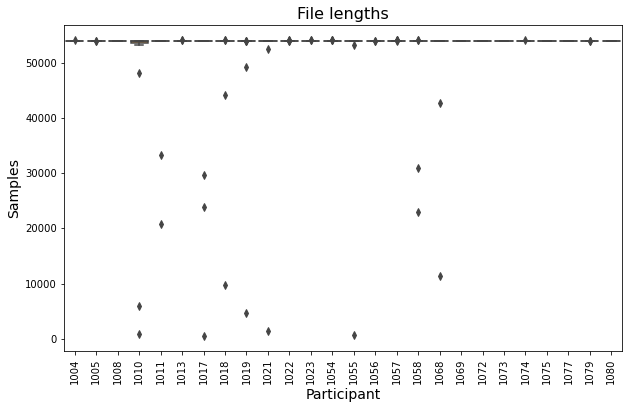

In [189]:
# dataLength_overview.sum()

dataLength_long_format = dataLength_overview.melt(var_name='Participant', value_name='Samples')


plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='Samples', data=dataLength_long_format)
#
# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Samples', fontsize=14)
plt.title('File lengths', fontsize=16)

# # Rotate x-axis labels vertically
plt.xticks(rotation=90)

plt.show()

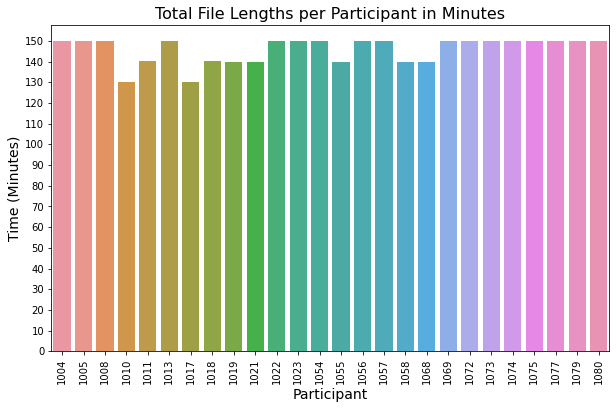

In [196]:

# Assuming dataLength_overview is your original DataFrame
fullData = dataLength_overview.sum()

# Convert the Series directly to a DataFrame
fullData_df = pd.DataFrame(fullData).reset_index()
fullData_df.columns = ['Participant', 'Samples']

# Calculate the corresponding time in minutes
fullData_df['Minutes'] = fullData_df['Samples'] / 5400  # 90 samples/sec * 60 sec/min

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for each participant showing their summed samples
sns.barplot(x='Participant', y='Minutes', data=fullData_df)

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Time (Minutes)', fontsize=14)
plt.title('Total File Lengths per Participant in Minutes', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Update y-ticks to show corresponding minutes
new_yticks = np.arange(0, fullData_df['Minutes'].max(), step=10)  # Adjust step as needed
plt.yticks(new_yticks)

plt.show()


# fixation and saccade stats and plots

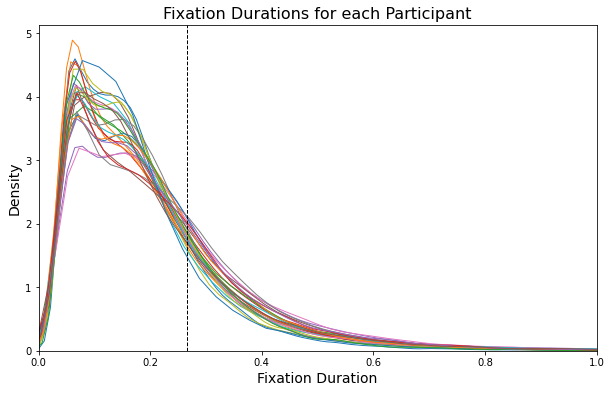

In [178]:
# Approach 1: Plot each participant's fixation durations individually with only the KDE visible
plt.figure(figsize=(10, 6))

for participant in fixation_lengths.columns:
    sns.kdeplot(fixation_lengths[participant].dropna(), label=f'Participant {participant}', linewidth=1)
    
plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Fixation Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Fixation Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'fixation_durations_participants.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

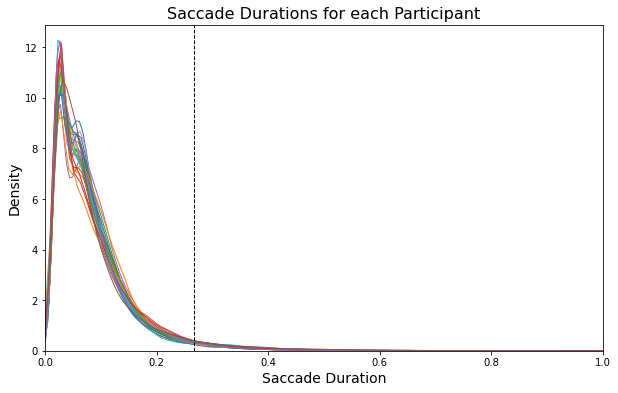

In [177]:
plt.figure(figsize=(10, 6))

for participant in saccade_lengths.columns:
    sns.kdeplot(saccade_lengths[participant].dropna(), label=f'Participant {participant}', linewidth=1)
    
plt.axvline(x=0.2666, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Saccade Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Saccade Durations for each Participant', fontsize=16)

# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'saccade_durations_participants.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

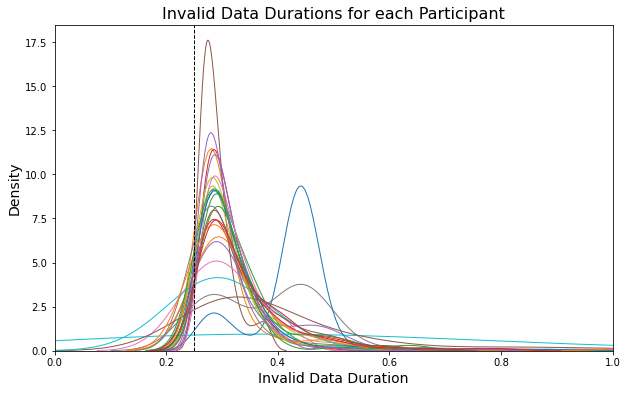

In [179]:
# check no data distributions
plt.figure(figsize=(10, 6))

for participant in noData_lengths.columns:
    sns.kdeplot(noData_lengths[participant].dropna(), label=f'Participant {participant}', linewidth=1)
    
plt.axvline(x=0.25, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')

# Limit x-axis to the range of 0 to 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Invalid Data Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Invalid Data Durations for each Participant', fontsize=16)


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'invalidData_durations_participants.png')


# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

In [78]:
# Combine fixation durations across all participants
combined_fixation_data = pd.concat([fixation_lengths[col].dropna() for col in fixation_lengths.columns])

# Combine saccade durations across all participants
combined_saccade_data = pd.concat([saccade_lengths[col].dropna() for col in saccade_lengths.columns])

combined_noData_data = pd.concat([noData_lengths[col].dropna() for col in noData_lengths.columns])

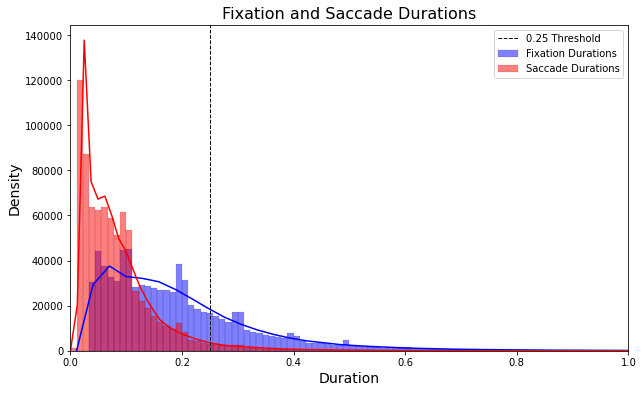

In [92]:
binwidth = 1/90 

plt.figure(figsize=(10, 6))

# Plot KDE for fixation durations in blue
sns.histplot(combined_fixation_data, kde=True, color='blue', label='Fixation Durations', binwidth=binwidth )

# Plot KDE for saccade durations in red
sns.histplot(combined_saccade_data, kde=True, color='red', label='Saccade Durations', binwidth=binwidth)

plt.axvline(x=0.25, color='black', linestyle='--', linewidth=1, label='0.25 Threshold')


# Add labels and title
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Fixation and Saccade Durations', fontsize=16)

plt.xlim(0, 1)

# Show legend
plt.legend()


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'fixation_saccade_durations_allData.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


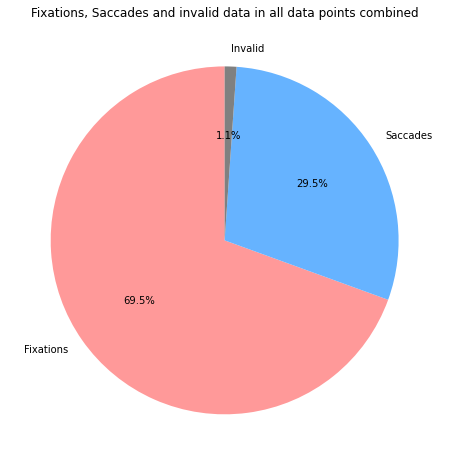

In [93]:

# Calculate the lengths
fixation_sum = combined_fixation_data.sum()
saccade_sum = combined_saccade_data.sum()
noData_sum = combined_noData_data.sum()

# Combine lengths into a list
lengths = [fixation_sum, saccade_sum, noData_sum]

# Define labels for the pie chart
labels = ['Fixations', 'Saccades', 'Invalid']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(lengths, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','grey'])
plt.title('Fixations, Saccades and invalid data in all data points combined')


# Combine the save path and filename
full_save_path = os.path.join(data_savepath_plots, 'allData_fixations_durations_invalidData.png')

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')


plt.show()

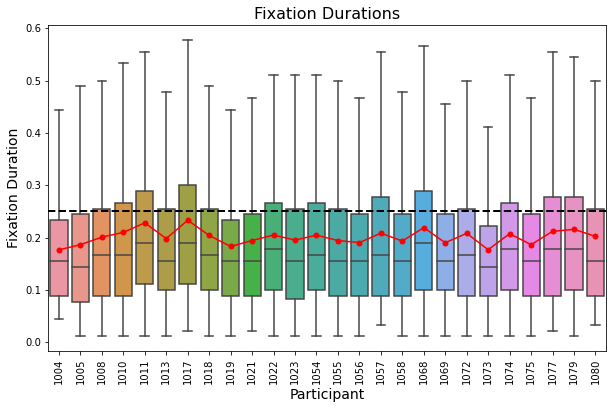

In [117]:
# Assuming you have dataframes: fixation_lengths

# Define the save path and file name separately

# Prepare data for boxplot
fixation_long_format = fixation_lengths.melt(var_name='Participant', value_name='Fixation_Duration')

plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='Fixation_Duration', data=fixation_long_format, showfliers=False)

# Calculate and plot means
means = fixation_lengths.mean()
ax.plot(range(len(means)), means, marker='o', markersize=5, color='red', linestyle='-', label='Mean')

# Plot the 0.25 threshold line
plt.axhline(y=0.25, color='black', linestyle='--', linewidth=2, label='0.25 Threshold')

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Fixation Duration', fontsize=14)
plt.title('Fixation Durations', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


filename = 'fixation_durations_boxplots.png'
full_save_path = os.path.join(data_savepath_plots, filename)

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


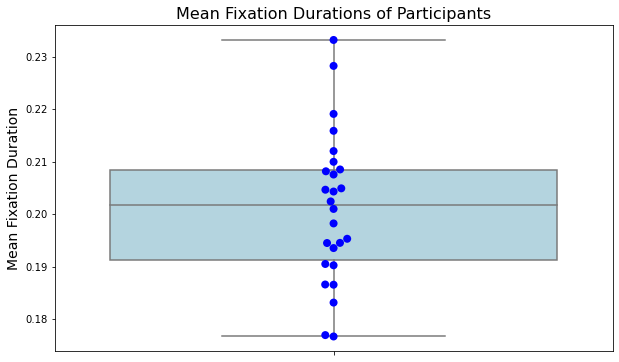

In [128]:

# Calculate the mean fixation duration for each participant
means = fixation_lengths.mean()

# Convert the means to a DataFrame for plotting
means_df = pd.DataFrame(means, columns=['Mean_Fixation_Duration'])
means_df.reset_index(inplace=True)
means_df.rename(columns={'index': 'Participant'}, inplace=True)

plt.figure(figsize=(10, 6))

# Plot boxplot of the means
ax = sns.boxplot(y='Mean_Fixation_Duration', data=means_df, color='lightblue', showfliers=False)
ax = sns.swarmplot(y='Mean_Fixation_Duration', data=means_df, color='blue', size=8)  # Add swarm plot for better visibility of points

# Add labels and title
plt.ylabel('Mean Fixation Duration', fontsize=14)
plt.title('Mean Fixation Durations of Participants', fontsize=16)

# Save the figure
filename = 'mean_fixation_durations_boxplot.png'
full_save_path = os.path.join(data_savepath_plots, filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


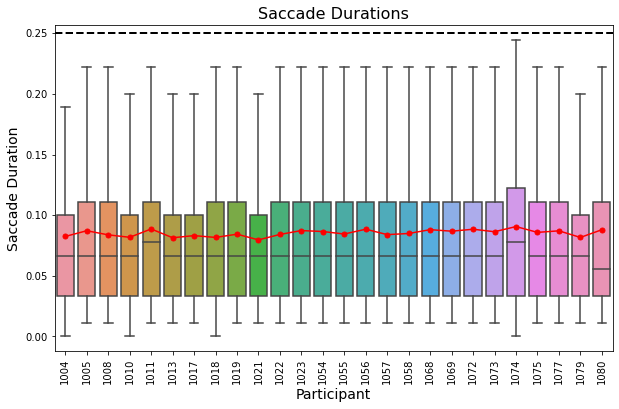

In [125]:
# Assuming you have dataframes: fixation_lengths

# Define the save path and file name separately

# Prepare data for boxplot
saccade_long_format = saccade_lengths.melt(var_name='Participant', value_name='Saccade_Duration')

plt.figure(figsize=(10, 6))

# Plot boxplots for each participant
ax = sns.boxplot(x='Participant', y='Saccade_Duration', data=saccade_long_format, showfliers=False)

# Calculate and plot means
means = saccade_lengths.mean()
ax.plot(range(len(means)), means, marker='o', markersize=5, color='red', linestyle='-', label='Mean')

# Plot the 0.25 threshold line
plt.axhline(y=0.25, color='black', linestyle='--', linewidth=2, label='0.25 Threshold')

# Add labels and title
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Saccade Duration', fontsize=14)
plt.title('Saccade Durations', fontsize=16)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)


filename = 'saccade_durations_boxplots.png'
full_save_path = os.path.join(data_savepath_plots, filename)

# Save the figure
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


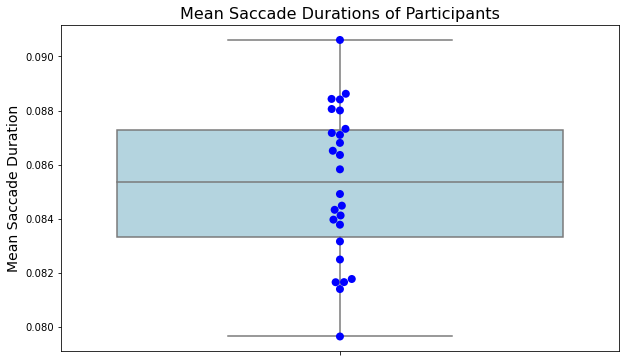

In [127]:

# Calculate the mean fixation duration for each participant
means = saccade_lengths.mean()

# Convert the means to a DataFrame for plotting
means_df = pd.DataFrame(means, columns=['Mean_Saccade_Duration'])
means_df.reset_index(inplace=True)
means_df.rename(columns={'index': 'Participant'}, inplace=True)

plt.figure(figsize=(10, 6))

# Plot boxplot of the means
ax = sns.boxplot(y='Mean_Saccade_Duration', data=means_df, color='lightblue', showfliers=False)
ax = sns.swarmplot(y='Mean_Saccade_Duration', data=means_df, color='blue', size=8)  # Add swarm plot for better visibility of points

# Add labels and title
plt.ylabel('Mean Saccade Duration', fontsize=14)
plt.title('Mean Saccade Durations of Participants', fontsize=16)

# Save the figure
filename = 'mean_saccade_durations_boxplot.png'
full_save_path = os.path.join(data_savepath_plots, filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


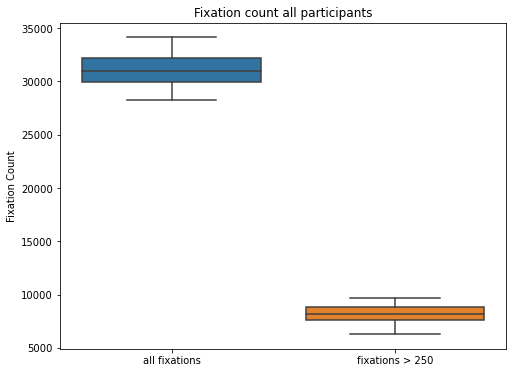

In [164]:


# Count non-NaN values in each column
non_nan_counts = fixation_lengths.notna().sum()



# Count non-NaN values greater than 250 in each column
greater_than_250_counts = fixation_lengths[fixation_lengths > 0.25].notna().sum()

noBuilding_allFix = fixation_lengths[fixation_lengths > 0.25].notna().sum()



# Prepare the data for boxplot
counts_df = pd.DataFrame({
    'all fixations': non_nan_counts,
    'fixations > 250': greater_than_250_counts
})





# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=counts_df)
plt.title('Fixation count all participants')
plt.ylabel('Fixation Count')
plt.show()

In [151]:
fixation_lengths.head()

,1004,1005,1008,1010,1011,1013,1017,1018,1019,1021,...,1058,1068,1069,1072,1073,1074,1075,1077,1079,1080
0,0.111111,0.011111,0.066667,0.133333,0.077778,0.077778,0.022222,0.011111,0.066667,0.088889,...,0.177778,0.011111,0.022222,0.266667,0.022222,0.011111,0.266667,0.066667,0.122222,0.033333
1,0.155556,0.133333,0.088889,0.411111,0.177778,0.188889,0.144444,0.166667,0.077778,0.066667,...,0.155556,0.077778,0.144444,0.200000,0.200000,0.144444,0.222222,0.222222,0.044444,0.055556
2,0.211111,0.177778,0.233333,0.244444,0.277778,0.233333,0.088889,0.111111,0.055556,0.088889,...,0.122222,0.155556,0.222222,0.411111,0.377778,0.277778,0.200000,0.322222,0.300000,0.133333
3,0.255556,0.044444,0.244444,0.066667,0.044444,0.344444,0.066667,0.122222,0.044444,0.122222,...,0.133333,0.066667,0.177778,0.244444,0.244444,0.255556,0.211111,0.188889,0.344444,0.077778
4,0.111111,0.044444,0.244444,0.200000,0.122222,0.044444,0.066667,0.233333,0.122222,0.100000,...,0.111111,0.266667,0.344444,0.400000,0.244444,0.077778,0.155556,0.244444,1.177778,0.122222


# intervals

In [130]:
intervals = pd.DataFrame()




# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    fixation_durations = []
    saccade_durations = []
    noD_durations = []
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intervals) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_interval_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for fileIndex, file in enumerate(file_pbar):

            print('process file ', file)

            # read in data
            int_data = pd.read_csv(os.path.join(data_savepath_intervals, file))
            
            
              # Add participant index, session index, and file index to the data
            int_data['Participant'] = currentPart
            int_data['Session'] = indexSess
            int_data['FileIndex'] = fileIndex

            # Append the interval data to the long-form DataFrame
            intervals = pd.concat([intervals, int_data], ignore_index=True)

# Save the final intervals DataFrame
intervals.to_csv(os.path.join(data_savepath_intervals, 'aggregated_intervals.csv'), index=False)
            




            # file = "1004_Session_1_ET_1_data_processed_gazes.csv"
            # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


#             # Variables to store start times
#             fixation_start_time = None
#             saccade_start_time = None

#             # Iterate through the DataFrame to find start and end times
#             for index, row in data.iterrows():
#                 if row['events'] == 2.0:
#                     fixation_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -2.0 and fixation_start_time is not None:
#                     fixation_durations.append((row['timeStampDataPointStart_converted'] - fixation_start_time))
#                     fixation_start_time = None
#                 elif row['events'] == 1.0:
#                     saccade_start_time = row['timeStampDataPointStart_converted']
#                 elif row['events'] == -1.0 and saccade_start_time is not None:
#                     saccade_durations.append((row['timeStampDataPointStart_converted'] - saccade_start_time))
#                     saccade_start_time = None

📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_interval_mad_wobig.csv
process file  1004_Session_1_ET_2_interval_mad_wobig.csv
process file  1004_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_interval_mad_wobig.csv
process file  1004_Session_2_ET_2_interval_mad_wobig.csv
process file  1004_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_interval_mad_wobig.csv
process file  1004_Session_3_ET_2_interval_mad_wobig.csv
process file  1004_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_interval_mad_wobig.csv
process file  1004_Session_4_ET_2_interval_mad_wobig.csv
process file  1004_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_interval_mad_wobig.csv
process file  1004_Session_5_ET_2_interval_mad_wobig.csv
process file  1004_Session_5_ET_3_interval_mad_wobig.csv
Participant 1 - participant ID 1005


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_1_ET_1_interval_mad_wobig.csv
process file  1005_Session_1_ET_2_interval_mad_wobig.csv
process file  1005_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_2_ET_1_interval_mad_wobig.csv
process file  1005_Session_2_ET_2_interval_mad_wobig.csv
process file  1005_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_3_ET_1_interval_mad_wobig.csv
process file  1005_Session_3_ET_2_interval_mad_wobig.csv
process file  1005_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_4_ET_1_interval_mad_wobig.csv
process file  1005_Session_4_ET_2_interval_mad_wobig.csv
process file  1005_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1005_Session_5_ET_1_interval_mad_wobig.csv
process file  1005_Session_5_ET_2_interval_mad_wobig.csv
process file  1005_Session_5_ET_3_interval_mad_wobig.csv
Participant 2 - participant ID 1008


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_1_ET_1_interval_mad_wobig.csv
process file  1008_Session_1_ET_2_interval_mad_wobig.csv
process file  1008_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_2_ET_1_interval_mad_wobig.csv
process file  1008_Session_2_ET_2_interval_mad_wobig.csv
process file  1008_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_3_ET_1_interval_mad_wobig.csv
process file  1008_Session_3_ET_2_interval_mad_wobig.csv
process file  1008_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_4_ET_1_interval_mad_wobig.csv
process file  1008_Session_4_ET_2_interval_mad_wobig.csv
process file  1008_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1008_Session_5_ET_1_interval_mad_wobig.csv
process file  1008_Session_5_ET_2_interval_mad_wobig.csv
process file  1008_Session_5_ET_3_interval_mad_wobig.csv
Participant 3 - participant ID 1010


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_1_ET_1_interval_mad_wobig.csv
process file  1010_Session_1_ET_2_interval_mad_wobig.csv
process file  1010_Session_1_ET_3_interval_mad_wobig.csv
process file  1010_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_2_ET_1_interval_mad_wobig.csv
process file  1010_Session_2_ET_2_interval_mad_wobig.csv
process file  1010_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_3_ET_1_interval_mad_wobig.csv
process file  1010_Session_3_ET_2_interval_mad_wobig.csv
process file  1010_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_4_ET_1_interval_mad_wobig.csv
process file  1010_Session_4_ET_2_interval_mad_wobig.csv
process file  1010_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1010_Session_5_ET_1_interval_mad_wobig.csv
process file  1010_Session_5_ET_2_interval_mad_wobig.csv
process file  1010_Session_5_ET_3_interval_mad_wobig.csv
process file  1010_Session_5_ET_4_interval_mad_wobig.csv
Participant 4 - participant ID 1011


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_1_ET_1_interval_mad_wobig.csv
process file  1011_Session_1_ET_2_interval_mad_wobig.csv
process file  1011_Session_1_ET_3_interval_mad_wobig.csv
process file  1011_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_2_ET_1_interval_mad_wobig.csv
process file  1011_Session_2_ET_2_interval_mad_wobig.csv
process file  1011_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_3_ET_1_interval_mad_wobig.csv
process file  1011_Session_3_ET_2_interval_mad_wobig.csv
process file  1011_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_4_ET_1_interval_mad_wobig.csv
process file  1011_Session_4_ET_2_interval_mad_wobig.csv
process file  1011_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1011_Session_5_ET_1_interval_mad_wobig.csv
process file  1011_Session_5_ET_2_interval_mad_wobig.csv
process file  1011_Session_5_ET_3_interval_mad_wobig.csv
Participant 5 - participant ID 1013


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_1_ET_1_interval_mad_wobig.csv
process file  1013_Session_1_ET_2_interval_mad_wobig.csv
process file  1013_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_2_ET_1_interval_mad_wobig.csv
process file  1013_Session_2_ET_2_interval_mad_wobig.csv
process file  1013_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_3_ET_1_interval_mad_wobig.csv
process file  1013_Session_3_ET_2_interval_mad_wobig.csv
process file  1013_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_4_ET_1_interval_mad_wobig.csv
process file  1013_Session_4_ET_2_interval_mad_wobig.csv
process file  1013_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1013_Session_5_ET_1_interval_mad_wobig.csv
process file  1013_Session_5_ET_2_interval_mad_wobig.csv
process file  1013_Session_5_ET_3_interval_mad_wobig.csv
Participant 6 - participant ID 1017


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 5 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_1_ET_1_interval_mad_wobig.csv
process file  1017_Session_1_ET_2_interval_mad_wobig.csv
process file  1017_Session_1_ET_3_interval_mad_wobig.csv
process file  1017_Session_1_ET_4_interval_mad_wobig.csv
process file  1017_Session_1_ET_5_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_2_ET_1_interval_mad_wobig.csv
process file  1017_Session_2_ET_2_interval_mad_wobig.csv
process file  1017_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_3_ET_1_interval_mad_wobig.csv
process file  1017_Session_3_ET_2_interval_mad_wobig.csv
process file  1017_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_4_ET_1_interval_mad_wobig.csv
process file  1017_Session_4_ET_2_interval_mad_wobig.csv
process file  1017_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1017_Session_5_ET_1_interval_mad_wobig.csv
process file  1017_Session_5_ET_2_interval_mad_wobig.csv
process file  1017_Session_5_ET_3_interval_mad_wobig.csv
Participant 7 - participant ID 1018


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_1_ET_1_interval_mad_wobig.csv
process file  1018_Session_1_ET_2_interval_mad_wobig.csv
process file  1018_Session_1_ET_3_interval_mad_wobig.csv
process file  1018_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_2_ET_1_interval_mad_wobig.csv
process file  1018_Session_2_ET_2_interval_mad_wobig.csv
process file  1018_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_3_ET_1_interval_mad_wobig.csv
process file  1018_Session_3_ET_2_interval_mad_wobig.csv
process file  1018_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_4_ET_1_interval_mad_wobig.csv
process file  1018_Session_4_ET_2_interval_mad_wobig.csv
process file  1018_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1018_Session_5_ET_1_interval_mad_wobig.csv
process file  1018_Session_5_ET_2_interval_mad_wobig.csv
process file  1018_Session_5_ET_3_interval_mad_wobig.csv
Participant 8 - participant ID 1019


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_1_ET_1_interval_mad_wobig.csv
process file  1019_Session_1_ET_2_interval_mad_wobig.csv
process file  1019_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_2_ET_1_interval_mad_wobig.csv
process file  1019_Session_2_ET_2_interval_mad_wobig.csv
process file  1019_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_3_ET_1_interval_mad_wobig.csv
process file  1019_Session_3_ET_2_interval_mad_wobig.csv
process file  1019_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_4_ET_1_interval_mad_wobig.csv
process file  1019_Session_4_ET_2_interval_mad_wobig.csv
process file  1019_Session_4_ET_3_interval_mad_wobig.csv
process file  1019_Session_4_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1019_Session_5_ET_1_interval_mad_wobig.csv
process file  1019_Session_5_ET_2_interval_mad_wobig.csv
process file  1019_Session_5_ET_3_interval_mad_wobig.csv
Participant 9 - participant ID 1021


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_1_ET_1_interval_mad_wobig.csv
process file  1021_Session_1_ET_2_interval_mad_wobig.csv
process file  1021_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_2_ET_1_interval_mad_wobig.csv
process file  1021_Session_2_ET_2_interval_mad_wobig.csv
process file  1021_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_3_ET_1_interval_mad_wobig.csv
process file  1021_Session_3_ET_2_interval_mad_wobig.csv
process file  1021_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_4_ET_1_interval_mad_wobig.csv
process file  1021_Session_4_ET_2_interval_mad_wobig.csv
process file  1021_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1021_Session_5_ET_1_interval_mad_wobig.csv
process file  1021_Session_5_ET_2_interval_mad_wobig.csv
process file  1021_Session_5_ET_3_interval_mad_wobig.csv
process file  1021_Session_5_ET_4_interval_mad_wobig.csv
Participant 10 - participant ID 1022


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_1_ET_1_interval_mad_wobig.csv
process file  1022_Session_1_ET_2_interval_mad_wobig.csv
process file  1022_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_2_ET_1_interval_mad_wobig.csv
process file  1022_Session_2_ET_2_interval_mad_wobig.csv
process file  1022_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_3_ET_1_interval_mad_wobig.csv
process file  1022_Session_3_ET_2_interval_mad_wobig.csv
process file  1022_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_4_ET_1_interval_mad_wobig.csv
process file  1022_Session_4_ET_2_interval_mad_wobig.csv
process file  1022_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1022_Session_5_ET_1_interval_mad_wobig.csv
process file  1022_Session_5_ET_2_interval_mad_wobig.csv
process file  1022_Session_5_ET_3_interval_mad_wobig.csv
Participant 11 - participant ID 1023


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_1_ET_1_interval_mad_wobig.csv
process file  1023_Session_1_ET_2_interval_mad_wobig.csv
process file  1023_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_2_ET_1_interval_mad_wobig.csv
process file  1023_Session_2_ET_2_interval_mad_wobig.csv
process file  1023_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_3_ET_1_interval_mad_wobig.csv
process file  1023_Session_3_ET_2_interval_mad_wobig.csv
process file  1023_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_4_ET_1_interval_mad_wobig.csv
process file  1023_Session_4_ET_2_interval_mad_wobig.csv
process file  1023_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1023_Session_5_ET_1_interval_mad_wobig.csv
process file  1023_Session_5_ET_2_interval_mad_wobig.csv
process file  1023_Session_5_ET_3_interval_mad_wobig.csv
Participant 12 - participant ID 1054


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_1_ET_1_interval_mad_wobig.csv
process file  1054_Session_1_ET_2_interval_mad_wobig.csv
process file  1054_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_2_ET_1_interval_mad_wobig.csv
process file  1054_Session_2_ET_2_interval_mad_wobig.csv
process file  1054_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_3_ET_1_interval_mad_wobig.csv
process file  1054_Session_3_ET_2_interval_mad_wobig.csv
process file  1054_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_4_ET_1_interval_mad_wobig.csv
process file  1054_Session_4_ET_2_interval_mad_wobig.csv
process file  1054_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1054_Session_5_ET_1_interval_mad_wobig.csv
process file  1054_Session_5_ET_2_interval_mad_wobig.csv
process file  1054_Session_5_ET_3_interval_mad_wobig.csv
Participant 13 - participant ID 1055


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_1_ET_1_interval_mad_wobig.csv
process file  1055_Session_1_ET_2_interval_mad_wobig.csv
process file  1055_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_2_ET_1_interval_mad_wobig.csv
process file  1055_Session_2_ET_2_interval_mad_wobig.csv
process file  1055_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_3_ET_1_interval_mad_wobig.csv
process file  1055_Session_3_ET_2_interval_mad_wobig.csv
process file  1055_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_4_ET_1_interval_mad_wobig.csv
process file  1055_Session_4_ET_2_interval_mad_wobig.csv
process file  1055_Session_4_ET_3_interval_mad_wobig.csv
process file  1055_Session_4_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1055_Session_5_ET_1_interval_mad_wobig.csv
process file  1055_Session_5_ET_2_interval_mad_wobig.csv
process file  1055_Session_5_ET_3_interval_mad_wobig.csv
Participant 14 - participant ID 1056


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_1_ET_1_interval_mad_wobig.csv
process file  1056_Session_1_ET_2_interval_mad_wobig.csv
process file  1056_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_2_ET_1_interval_mad_wobig.csv
process file  1056_Session_2_ET_2_interval_mad_wobig.csv
process file  1056_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_3_ET_1_interval_mad_wobig.csv
process file  1056_Session_3_ET_2_interval_mad_wobig.csv
process file  1056_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_4_ET_1_interval_mad_wobig.csv
process file  1056_Session_4_ET_2_interval_mad_wobig.csv
process file  1056_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1056_Session_5_ET_1_interval_mad_wobig.csv
process file  1056_Session_5_ET_2_interval_mad_wobig.csv
process file  1056_Session_5_ET_3_interval_mad_wobig.csv
Participant 15 - participant ID 1057


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_1_ET_1_interval_mad_wobig.csv
process file  1057_Session_1_ET_2_interval_mad_wobig.csv
process file  1057_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_2_ET_1_interval_mad_wobig.csv
process file  1057_Session_2_ET_2_interval_mad_wobig.csv
process file  1057_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_3_ET_1_interval_mad_wobig.csv
process file  1057_Session_3_ET_2_interval_mad_wobig.csv
process file  1057_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_4_ET_1_interval_mad_wobig.csv
process file  1057_Session_4_ET_2_interval_mad_wobig.csv
process file  1057_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1057_Session_5_ET_1_interval_mad_wobig.csv
process file  1057_Session_5_ET_2_interval_mad_wobig.csv
process file  1057_Session_5_ET_3_interval_mad_wobig.csv
Participant 16 - participant ID 1058


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_1_ET_1_interval_mad_wobig.csv
process file  1058_Session_1_ET_2_interval_mad_wobig.csv
process file  1058_Session_1_ET_3_interval_mad_wobig.csv
process file  1058_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_2_ET_1_interval_mad_wobig.csv
process file  1058_Session_2_ET_2_interval_mad_wobig.csv
process file  1058_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_3_ET_1_interval_mad_wobig.csv
process file  1058_Session_3_ET_2_interval_mad_wobig.csv
process file  1058_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_4_ET_1_interval_mad_wobig.csv
process file  1058_Session_4_ET_2_interval_mad_wobig.csv
process file  1058_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1058_Session_5_ET_1_interval_mad_wobig.csv
process file  1058_Session_5_ET_2_interval_mad_wobig.csv
process file  1058_Session_5_ET_3_interval_mad_wobig.csv
Participant 17 - participant ID 1068


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_1_ET_1_interval_mad_wobig.csv
process file  1068_Session_1_ET_2_interval_mad_wobig.csv
process file  1068_Session_1_ET_3_interval_mad_wobig.csv
process file  1068_Session_1_ET_4_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_2_ET_1_interval_mad_wobig.csv
process file  1068_Session_2_ET_2_interval_mad_wobig.csv
process file  1068_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_3_ET_1_interval_mad_wobig.csv
process file  1068_Session_3_ET_2_interval_mad_wobig.csv
process file  1068_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_4_ET_1_interval_mad_wobig.csv
process file  1068_Session_4_ET_2_interval_mad_wobig.csv
process file  1068_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1068_Session_5_ET_1_interval_mad_wobig.csv
process file  1068_Session_5_ET_2_interval_mad_wobig.csv
process file  1068_Session_5_ET_3_interval_mad_wobig.csv
Participant 18 - participant ID 1069


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_1_ET_1_interval_mad_wobig.csv
process file  1069_Session_1_ET_2_interval_mad_wobig.csv
process file  1069_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_2_ET_1_interval_mad_wobig.csv
process file  1069_Session_2_ET_2_interval_mad_wobig.csv
process file  1069_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_3_ET_1_interval_mad_wobig.csv
process file  1069_Session_3_ET_2_interval_mad_wobig.csv
process file  1069_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_4_ET_1_interval_mad_wobig.csv
process file  1069_Session_4_ET_2_interval_mad_wobig.csv
process file  1069_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1069_Session_5_ET_1_interval_mad_wobig.csv
process file  1069_Session_5_ET_2_interval_mad_wobig.csv
process file  1069_Session_5_ET_3_interval_mad_wobig.csv
Participant 19 - participant ID 1072


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_1_ET_1_interval_mad_wobig.csv
process file  1072_Session_1_ET_2_interval_mad_wobig.csv
process file  1072_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_2_ET_1_interval_mad_wobig.csv
process file  1072_Session_2_ET_2_interval_mad_wobig.csv
process file  1072_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_3_ET_1_interval_mad_wobig.csv
process file  1072_Session_3_ET_2_interval_mad_wobig.csv
process file  1072_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_4_ET_1_interval_mad_wobig.csv
process file  1072_Session_4_ET_2_interval_mad_wobig.csv
process file  1072_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1072_Session_5_ET_1_interval_mad_wobig.csv
process file  1072_Session_5_ET_2_interval_mad_wobig.csv
process file  1072_Session_5_ET_3_interval_mad_wobig.csv
Participant 20 - participant ID 1073


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_1_ET_1_interval_mad_wobig.csv
process file  1073_Session_1_ET_2_interval_mad_wobig.csv
process file  1073_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_2_ET_1_interval_mad_wobig.csv
process file  1073_Session_2_ET_2_interval_mad_wobig.csv
process file  1073_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_3_ET_1_interval_mad_wobig.csv
process file  1073_Session_3_ET_2_interval_mad_wobig.csv
process file  1073_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_4_ET_1_interval_mad_wobig.csv
process file  1073_Session_4_ET_2_interval_mad_wobig.csv
process file  1073_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1073_Session_5_ET_1_interval_mad_wobig.csv
process file  1073_Session_5_ET_2_interval_mad_wobig.csv
process file  1073_Session_5_ET_3_interval_mad_wobig.csv
Participant 21 - participant ID 1074


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_1_ET_1_interval_mad_wobig.csv
process file  1074_Session_1_ET_2_interval_mad_wobig.csv
process file  1074_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_2_ET_1_interval_mad_wobig.csv
process file  1074_Session_2_ET_2_interval_mad_wobig.csv
process file  1074_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_3_ET_1_interval_mad_wobig.csv
process file  1074_Session_3_ET_2_interval_mad_wobig.csv
process file  1074_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_4_ET_1_interval_mad_wobig.csv
process file  1074_Session_4_ET_2_interval_mad_wobig.csv
process file  1074_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1074_Session_5_ET_1_interval_mad_wobig.csv
process file  1074_Session_5_ET_2_interval_mad_wobig.csv
process file  1074_Session_5_ET_3_interval_mad_wobig.csv
Participant 22 - participant ID 1075


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_1_ET_1_interval_mad_wobig.csv
process file  1075_Session_1_ET_2_interval_mad_wobig.csv
process file  1075_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_2_ET_1_interval_mad_wobig.csv
process file  1075_Session_2_ET_2_interval_mad_wobig.csv
process file  1075_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_3_ET_1_interval_mad_wobig.csv
process file  1075_Session_3_ET_2_interval_mad_wobig.csv
process file  1075_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_4_ET_1_interval_mad_wobig.csv
process file  1075_Session_4_ET_2_interval_mad_wobig.csv
process file  1075_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1075_Session_5_ET_1_interval_mad_wobig.csv
process file  1075_Session_5_ET_2_interval_mad_wobig.csv
process file  1075_Session_5_ET_3_interval_mad_wobig.csv
Participant 23 - participant ID 1077


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_1_ET_1_interval_mad_wobig.csv
process file  1077_Session_1_ET_2_interval_mad_wobig.csv
process file  1077_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_2_ET_1_interval_mad_wobig.csv
process file  1077_Session_2_ET_2_interval_mad_wobig.csv
process file  1077_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_3_ET_1_interval_mad_wobig.csv
process file  1077_Session_3_ET_2_interval_mad_wobig.csv
process file  1077_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_4_ET_1_interval_mad_wobig.csv
process file  1077_Session_4_ET_2_interval_mad_wobig.csv
process file  1077_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1077_Session_5_ET_1_interval_mad_wobig.csv
process file  1077_Session_5_ET_2_interval_mad_wobig.csv
process file  1077_Session_5_ET_3_interval_mad_wobig.csv
Participant 24 - participant ID 1079


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_1_ET_1_interval_mad_wobig.csv
process file  1079_Session_1_ET_2_interval_mad_wobig.csv
process file  1079_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_2_ET_1_interval_mad_wobig.csv
process file  1079_Session_2_ET_2_interval_mad_wobig.csv
process file  1079_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_3_ET_1_interval_mad_wobig.csv
process file  1079_Session_3_ET_2_interval_mad_wobig.csv
process file  1079_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_4_ET_1_interval_mad_wobig.csv
process file  1079_Session_4_ET_2_interval_mad_wobig.csv
process file  1079_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1079_Session_5_ET_1_interval_mad_wobig.csv
process file  1079_Session_5_ET_2_interval_mad_wobig.csv
process file  1079_Session_5_ET_3_interval_mad_wobig.csv
Participant 25 - participant ID 1080


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_1_ET_1_interval_mad_wobig.csv
process file  1080_Session_1_ET_2_interval_mad_wobig.csv
process file  1080_Session_1_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_2_ET_1_interval_mad_wobig.csv
process file  1080_Session_2_ET_2_interval_mad_wobig.csv
process file  1080_Session_2_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_3_ET_1_interval_mad_wobig.csv
process file  1080_Session_3_ET_2_interval_mad_wobig.csv
process file  1080_Session_3_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_4_ET_1_interval_mad_wobig.csv
process file  1080_Session_4_ET_2_interval_mad_wobig.csv
process file  1080_Session_4_ET_3_interval_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1080_Session_5_ET_1_interval_mad_wobig.csv
process file  1080_Session_5_ET_2_interval_mad_wobig.csv
process file  1080_Session_5_ET_3_interval_mad_wobig.csv


In [132]:
intervals.head()

,index,start,end,start_idx,end_idx,total_vels,thresh,Participant,Session,FileIndex
0,0,0.000000,0.133333,0,12,596.657913,25.631436,1004,1,0
1,4,0.177778,0.877778,16,79,2573.402313,26.992140,1004,1,0
2,10,0.933333,1.677778,84,151,1155.323648,33.160137,1004,1,0
3,12,1.700000,1.911111,153,172,823.342669,7.023075,1004,1,0
4,16,1.944444,2.188889,175,197,1018.578097,55.131253,1004,1,0


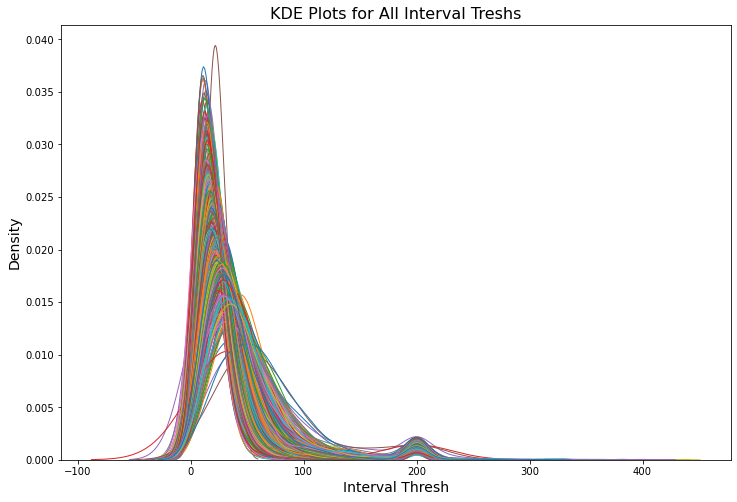

In [135]:

# Assuming the `intervals` DataFrame is already created from previous steps

plt.figure(figsize=(12, 8))

# Loop through each unique combination of Participant, Session, and FileIndex
grouped_intervals = intervals.groupby(['Participant', 'Session', 'FileIndex'])

for (participant, session, file_index), group in grouped_intervals:
    sns.kdeplot(group['thresh'].dropna(), label=f'P{participant}_S{session}_F{file_index}', linewidth=1)
    
# Add labels and title
plt.xlabel('Interval Thresh', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('KDE Plots for All Interval Treshs', fontsize=16)



# Save the figure
savepath = os.path.join(data_savepath_plots, 'all_intervals_thresh_individual.png')
plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


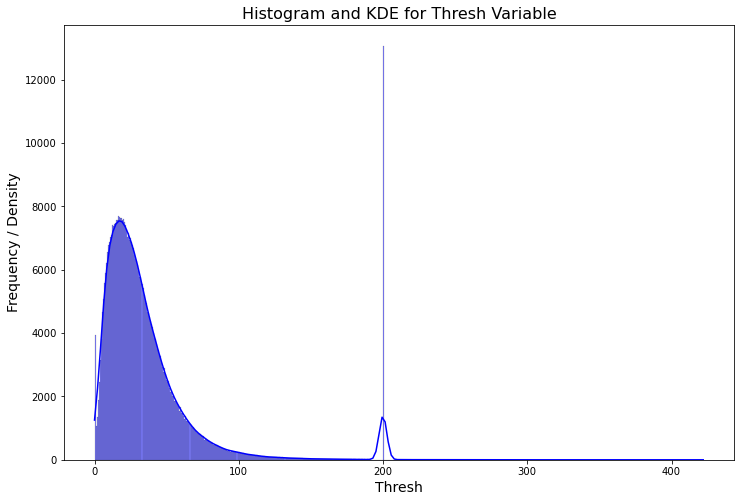

In [137]:
# Extract the 'thresh' values from intervals DataFrame
thresh_values = intervals['thresh'].dropna()

# Create a Figure
plt.figure(figsize=(12, 8))

# Plot Histogram with KDE
sns.histplot(thresh_values, kde=True, color='blue')

# Add labels and title
plt.xlabel('Thresh', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.title('Histogram and KDE for Thresh Variable', fontsize=16)

# Save the figure
savepath = os.path.join(data_savepath_intervals, 'histogram_thresh_allFiles.png')
plt.savefig(savepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [147]:
print(np.max(intervals['thresh']))

larger200 = intervals['thresh']> 200
print(sum(larger200))
print(sum(larger200)/len(larger200))

421.99187936380974
397
0.0008474431551354629


# stats for Debbies data

In [167]:
goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
fixation_durations2 = []
saccade_durations2 = []

fixation_start_time = None
saccade_start_time = None

# Iterate through the DataFrame to find start and end times
for index, row in goodData.iterrows():
    if row['events'] == 2.0:
        fixation_start_time = row['time']
    elif row['events'] == -2.0 and fixation_start_time is not None:
        fixation_durations2.append((row['time'] - fixation_start_time))
        fixation_start_time = None
    elif row['events'] == 1.0:
        saccade_start_time = row['time']
    elif row['events'] == -1.0 and saccade_start_time is not None:
        saccade_durations2.append((row['time'] - saccade_start_time))
        saccade_start_time = None

PermissionError: [Errno 13] Permission denied: 'E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv'

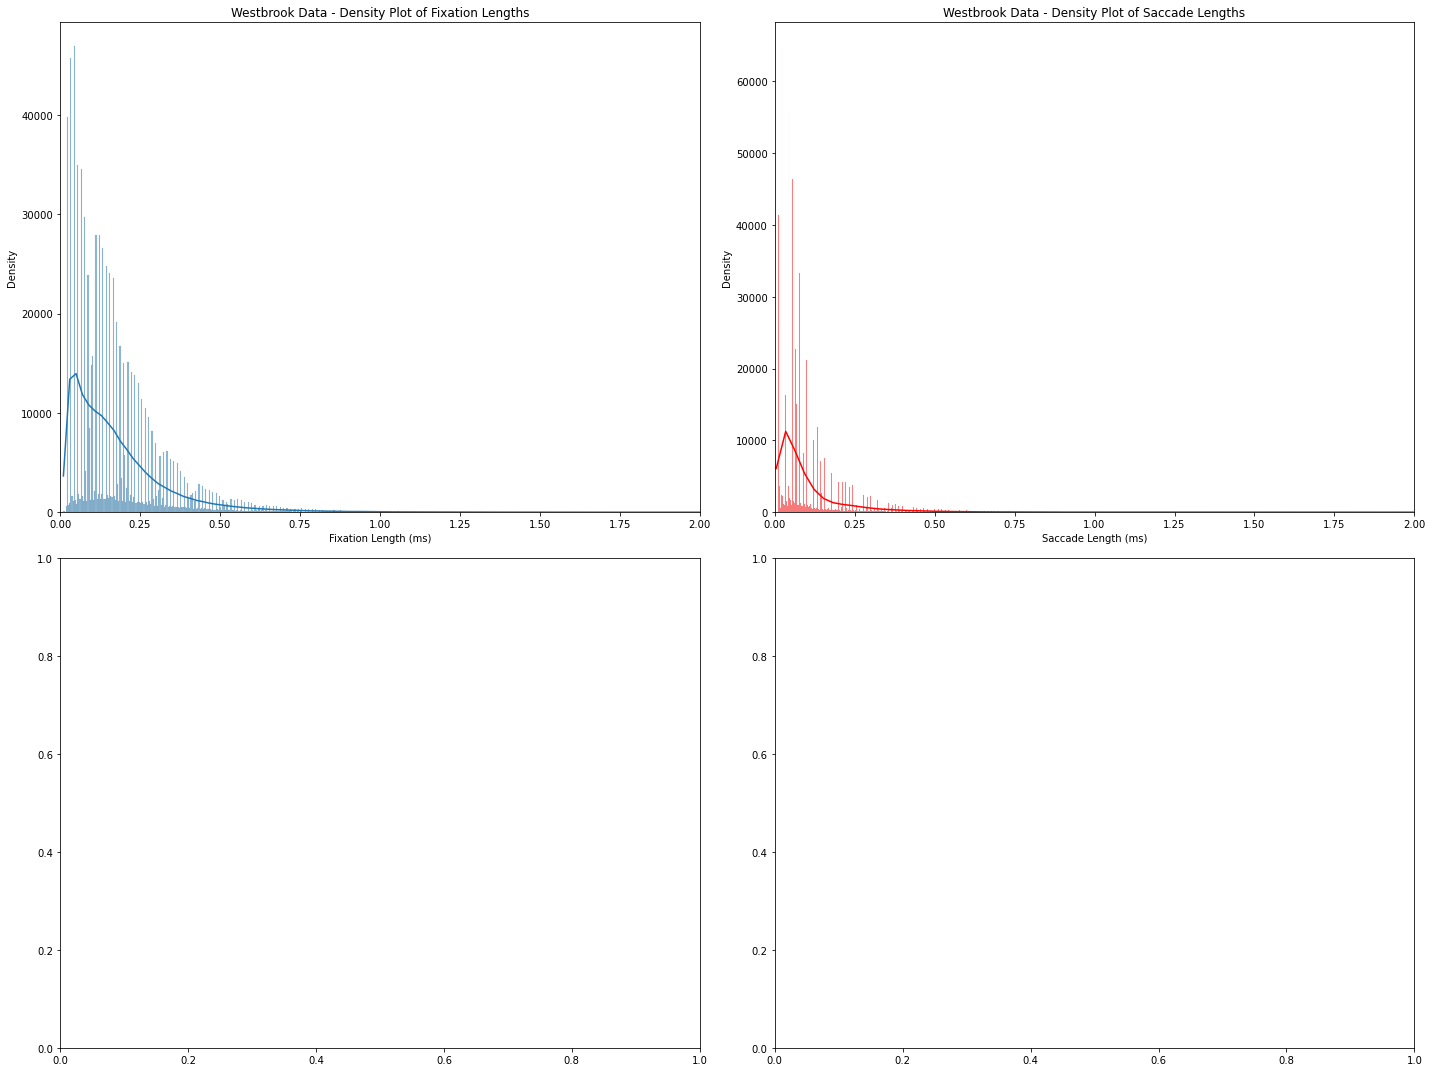

In [168]:
# Step 2: Create a density plot and histogram of fixation and saccade lengths
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# axs[0].hist(fixation_durations,  bins=155,color='blue', alpha=0.7, label='Fixation Lengths')
sns.histplot(fixation_durations, kde=True, ax = axs[0,0])
axs[0,0].set_title('Westbrook Data - Density Plot of Fixation Lengths')
axs[0,0].set_xlabel('Fixation Length (ms)')
axs[0,0].set_ylabel('Density')
axs[0,0].set_xlim(0,2)

# axs[1].hist(saccade_durations, bins=155,  color='red', alpha=0.7, label='Saccade Lengths')
sns.histplot(saccade_durations, kde=True,color='red', ax = axs[0,1])
axs[0,1].set_title('Westbrook Data - Density Plot of Saccade Lengths')
axs[0,1].set_xlabel('Saccade Length (ms)')
axs[0,1].set_ylabel('Density')
axs[0,1].set_xlim(0,2)


# # axs[0].hist(fixation_durations,  bins=155,color='blue', alpha=0.7, label='Fixation Lengths')
# sns.histplot(fixation_durations2, kde=True, ax = axs[1,0])
# axs[1,0].set_title('Debbies Data - Density Plot of Fixation Lengths')
# axs[1,0].set_xlabel('Fixation Length (ms)')
# axs[1,0].set_ylabel('Density')
# axs[1,0].set_xlim(0,2)

# # axs[1].hist(saccade_durations, bins=155,  color='red', alpha=0.7, label='Saccade Lengths')
# sns.histplot(saccade_durations2, kde=True, color='red',ax = axs[1,1])
# axs[1,1].set_title('Debbies Data - Density Plot of Saccade Lengths')
# axs[1,1].set_xlabel('Saccade Length (ms)')
# axs[1,1].set_ylabel('Density')
# axs[1,1].set_xlim(0,2)

plt.tight_layout()
plt.show()

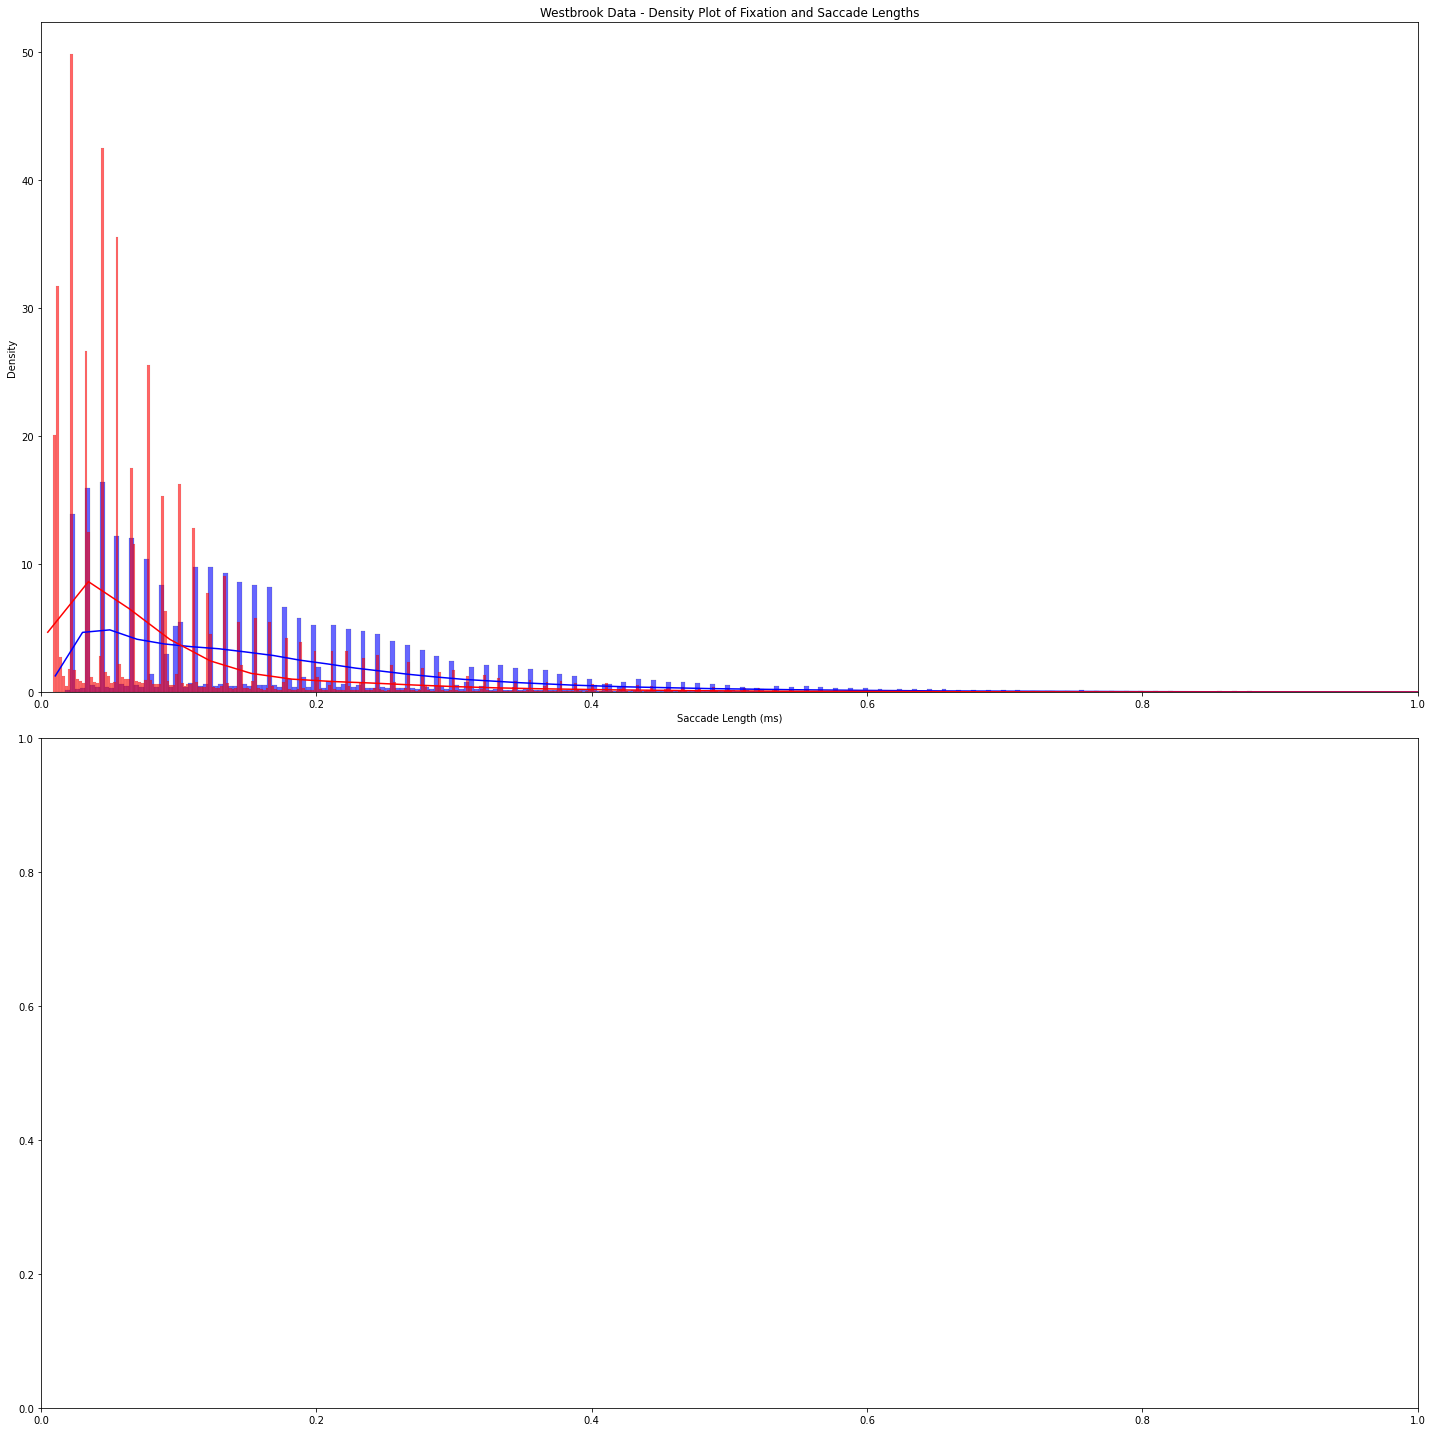

In [169]:


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

# Plot histogram and density plot for fixation durations
sns.histplot(fixation_durations, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[0] )
sns.histplot(saccade_durations, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[0])

axs[0].set_title('Westbrook Data - Density Plot of Fixation and Saccade Lengths')
axs[0].set_xlabel('Saccade Length (ms)')
axs[0].set_ylabel('Density')
axs[0].set_xlim(0,1)


# sns.histplot(fixation_durations2, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[1] )
# sns.histplot(saccade_durations2, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[1])

# axs[1].set_title('Debbies Data - Density Plot of Fixation and Saccade Lengths')
# axs[1].set_xlabel('Saccade Length (ms)')
# axs[1].set_ylabel('Density')
# axs[1].set_xlim(0,1)
# plt.legend()


# Show plot
plt.tight_layout()
plt.show()

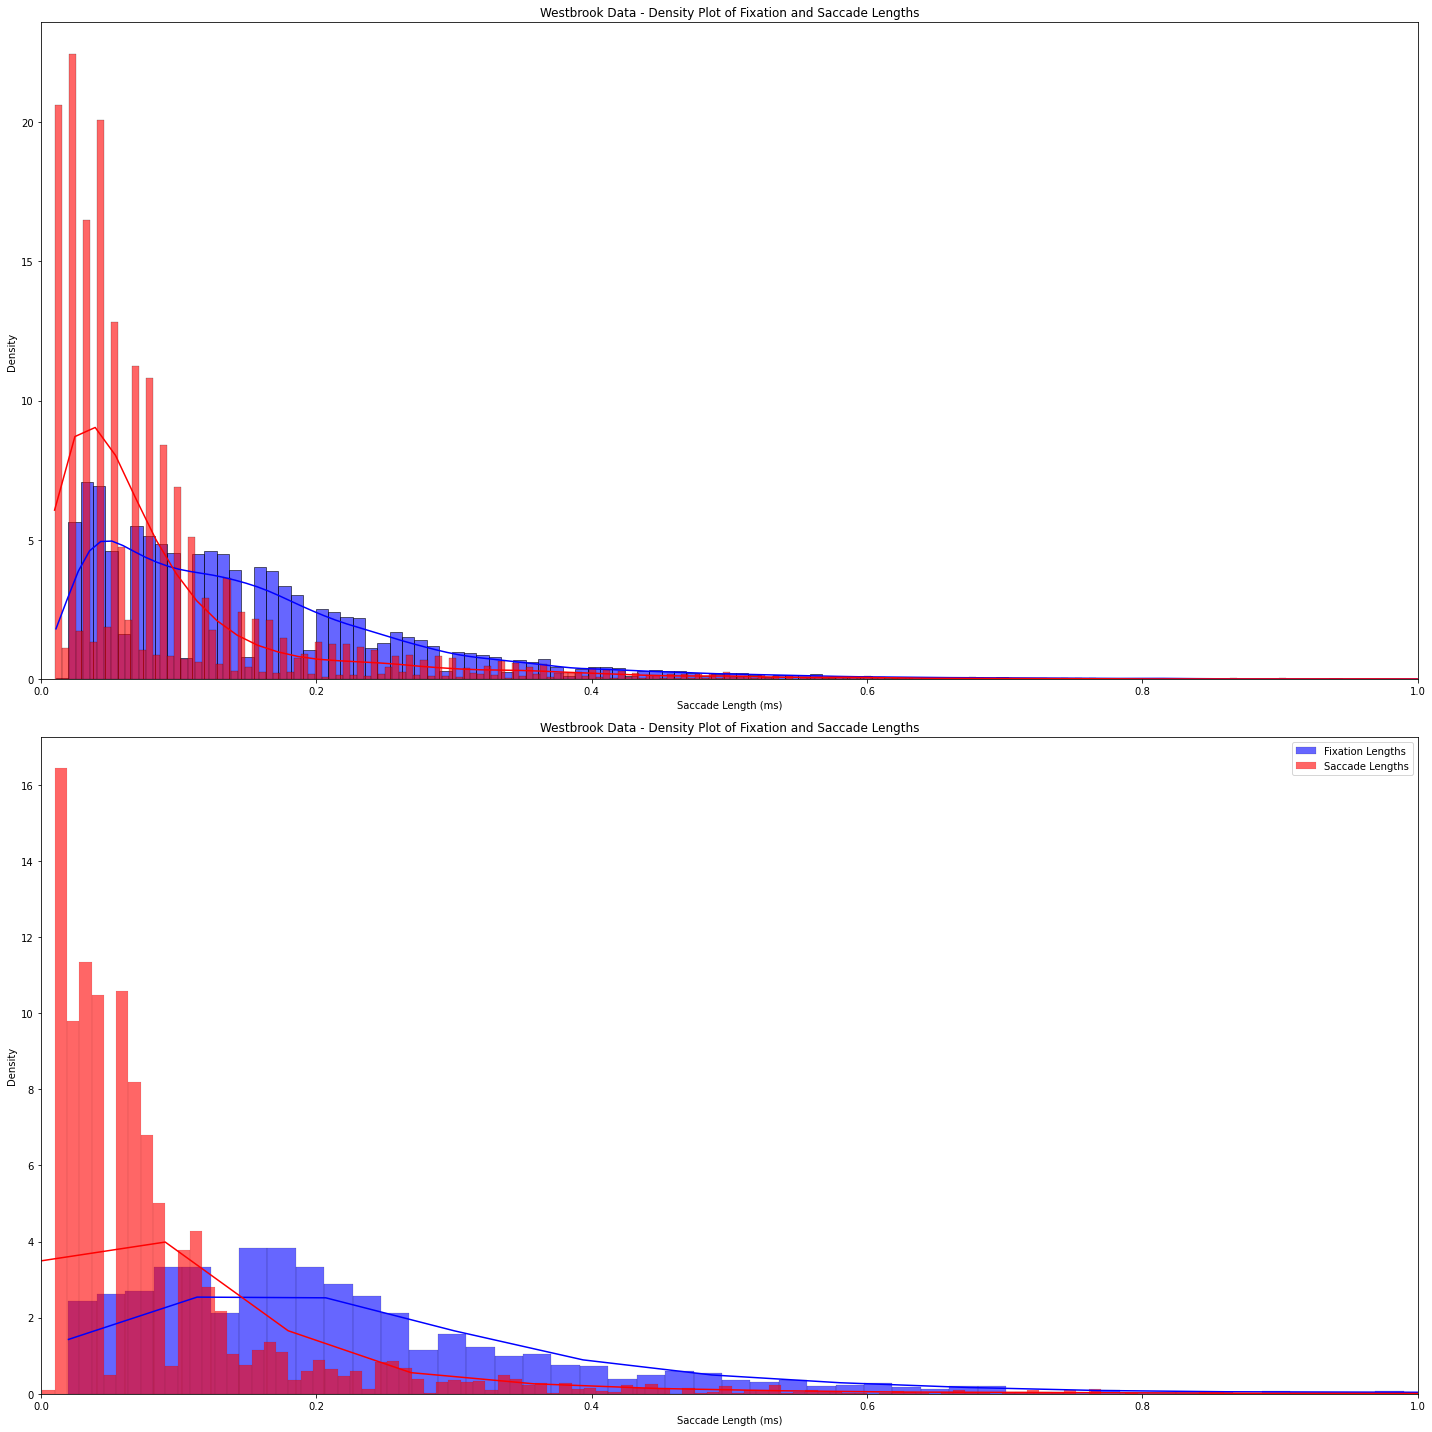

In [221]:


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

# Plot histogram and density plot for fixation durations
sns.histplot(fixation_durations, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[0] )
sns.histplot(saccade_durations, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[0])

axs[0].set_title('Westbrook Data - Density Plot of Fixation and Saccade Lengths')
axs[0].set_xlabel('Saccade Length (ms)')
axs[0].set_ylabel('Density')
axs[0].set_xlim(0,1)


sns.histplot(fixation_durations2, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[1] )
sns.histplot(saccade_durations2, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[1])

axs[1].set_title('Debbies Data - Density Plot of Fixation and Saccade Lengths')
axs[1].set_xlabel('Saccade Length (ms)')
axs[1].set_ylabel('Density')
axs[1].set_xlim(0,1)
plt.legend()


# Show plot
plt.tight_layout()
plt.show()

mean fixation duration (ms) =  158.9314601384161
mean saccade duration  (ms) =  96.09192686124473
-----------------------
median fixation duration (ms) =  125.48995018005371
median saccade duration  (ms) =  55.56011199950106
-----------------------
33202
27172
-----------------------
Sum fixation durations =  5276.842339515685
Sum saccade durations =  2611.009836673739
Sum all durations =  7887.852176189424
-----------------------
Fraction fixation durations of total data =  0.6689834218045523
Fraction saccade durations of total data =  0.33101657819544766


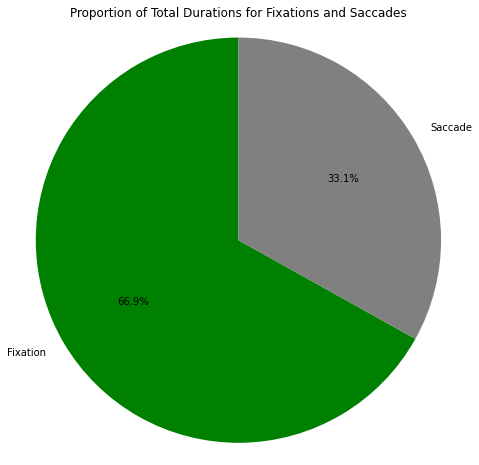

In [206]:

print("mean fixation duration (ms) = ", np.mean(fixation_durations)*1000)
print("mean saccade duration  (ms) = ",np.mean(saccade_durations)*1000)

print("-----------------------")
print("median fixation duration (ms) = ",np.median(fixation_durations)*1000)
print("median saccade duration  (ms) = ",np.median(saccade_durations)*1000)

print("-----------------------")

print(len(fixation_durations))
print(len(saccade_durations))


sum_fixation = sum(fixation_durations)
sum_saccade = sum(saccade_durations)
total_durations = sum_fixation + sum_saccade

print("-----------------------")
print("Sum fixation durations = ",sum_fixation)
print("Sum saccade durations = ", sum_saccade)
print("Sum all durations = ",total_durations)

print("-----------------------")
print("Fraction fixation durations of total data = ", (sum_fixation/total_durations))
print("Fraction saccade durations of total data = ", (sum_saccade / total_durations))

# Step 2: Create a pie chart
labels = ['Fixation', 'Saccade']
sizes = [sum_fixation, sum_saccade]
colors = ['green', 'grey']
explode = (0.1, 0)  # explode the first slice for emphasis

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle= 90)
plt.title('Proportion of Total Durations for Fixations and Saccades')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Show plot
plt.show()

mean fixation duration (ms) =  242.03439515341043
mean saccade duration  (ms) =  104.81775426219792
-----------------------
median fixation duration (ms) =  184.00000000008276
median saccade duration  (ms) =  56.00000000004002
-----------------------
5117
5103
-----------------------
Sum fixation durations =  1238.4900000000011
Sum saccade durations =  534.884999999996
Sum all durations =  1773.3749999999973
-----------------------
Fraction fixation durations of total data =  0.6983802072319747
Fraction saccade durations of total data =  0.3016197927680253


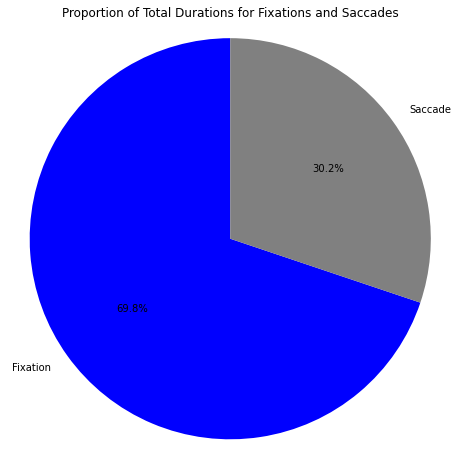

In [226]:

print("mean fixation duration (ms) = ", np.mean(fixation_durations2)*1000)
print("mean saccade duration  (ms) = ",np.mean(saccade_durations2)*1000)

print("-----------------------")
print("median fixation duration (ms) = ",np.median(fixation_durations2)*1000)
print("median saccade duration  (ms) = ",np.median(saccade_durations2)*1000)

print("-----------------------")

print(len(fixation_durations2))
print(len(saccade_durations2))


sum_fixation = sum(fixation_durations2)
sum_saccade = sum(saccade_durations2)
total_durations = sum_fixation + sum_saccade

print("-----------------------")
print("Sum fixation durations = ",sum_fixation)
print("Sum saccade durations = ", sum_saccade)
print("Sum all durations = ",total_durations)

print("-----------------------")
print("Fraction fixation durations of total data = ", (sum_fixation/total_durations))
print("Fraction saccade durations of total data = ", (sum_saccade / total_durations))

# Step 2: Create a pie chart
labels = ['Fixation', 'Saccade']
sizes = [sum_fixation, sum_saccade]
colors = ['blue', 'grey']
explode = (0.1, 0)  # explode the first slice for emphasis

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle= 90)
plt.title('Proportion of Total Durations for Fixations and Saccades')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Show plot
plt.show()

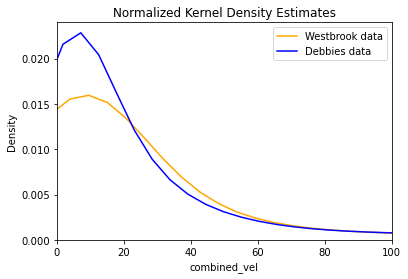

In [223]:
variable_name = 'combined_vel'

sns.kdeplot(data[variable_name], label='Westbrook data', color='orange')
sns.kdeplot(goodData[variable_name], label='Debbies data', color='blue')



plt.xlabel(variable_name)
plt.ylabel('Density')
plt.title('Normalized Kernel Density Estimates')
plt.legend()

plt.xlim(0, 100)

plt.show()

In [232]:
file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

goodInterval = pd.read_csv('E:/WestbrookProject/DebbiesData//interval_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')


(0.0, 250.0)

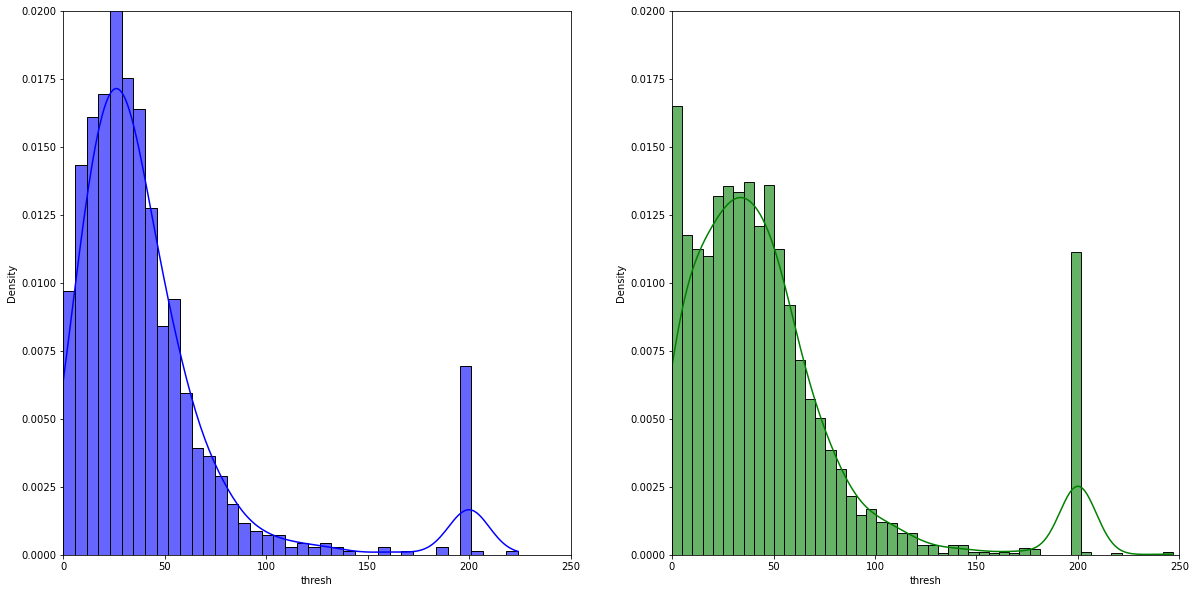

In [241]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.histplot(int_data["thresh"], bins='auto', kde=True, color='blue', label='Threshs', alpha=0.6, stat="density", ax = axs[0])
axs[0].set_ylim(0, 0.02)
axs[0].set_xlim(0, 250)
sns.histplot(goodInterval["thresh"], bins='auto', kde=True, color='green', label='Threshs', alpha=0.6, stat="density",ax = axs[1])
axs[1].set_ylim(0 ,0.02)
axs[1].set_xlim(0, 250)

In [231]:
print('--------- median all velocities----------')
print(np.nanmedian(data['combined_vel']))
print(np.nanmedian(goodData['combined_vel']))

print('--------- mean all velocities----------')
print(np.mean(data['combined_vel']))
print(np.mean(goodData['combined_vel']))


print('--------- 0s in velocities----------')
print((data['combined_vel']== 0).sum()/len(data))
print((goodData['combined_vel']== 0).sum()/len(goodData))


print('--------- NaNs in velocities----------')
print(data['combined_vel'].isna().sum()/len(data))
print(goodData['combined_vel'].isna().sum()/len(goodData))

--------- median all velocities----------
10.616655872568824
10.67012299410869
--------- mean all velocities----------
56.52722392317094
45.063388349829836
--------- 0s in velocities----------
0.0005747727035217891
0.0019456094081023822
--------- NaNs in velocities----------
0.004807189884000418
0.013662501621341173


---------------------------------
max sampling rate 1  201.6201509397683
max sampling rate 2  1000.0000002510205
---------------------------------
mean sampling rate 1  63.764955510773426
mean sampling rate 2  85.79712172495128
---------------------------------
median sampling rate 1  87.64243475353658
median sampling rate 2  90.90909090912662
---------------------------------


Text(0.5, 1.0, 'both sampling rates')

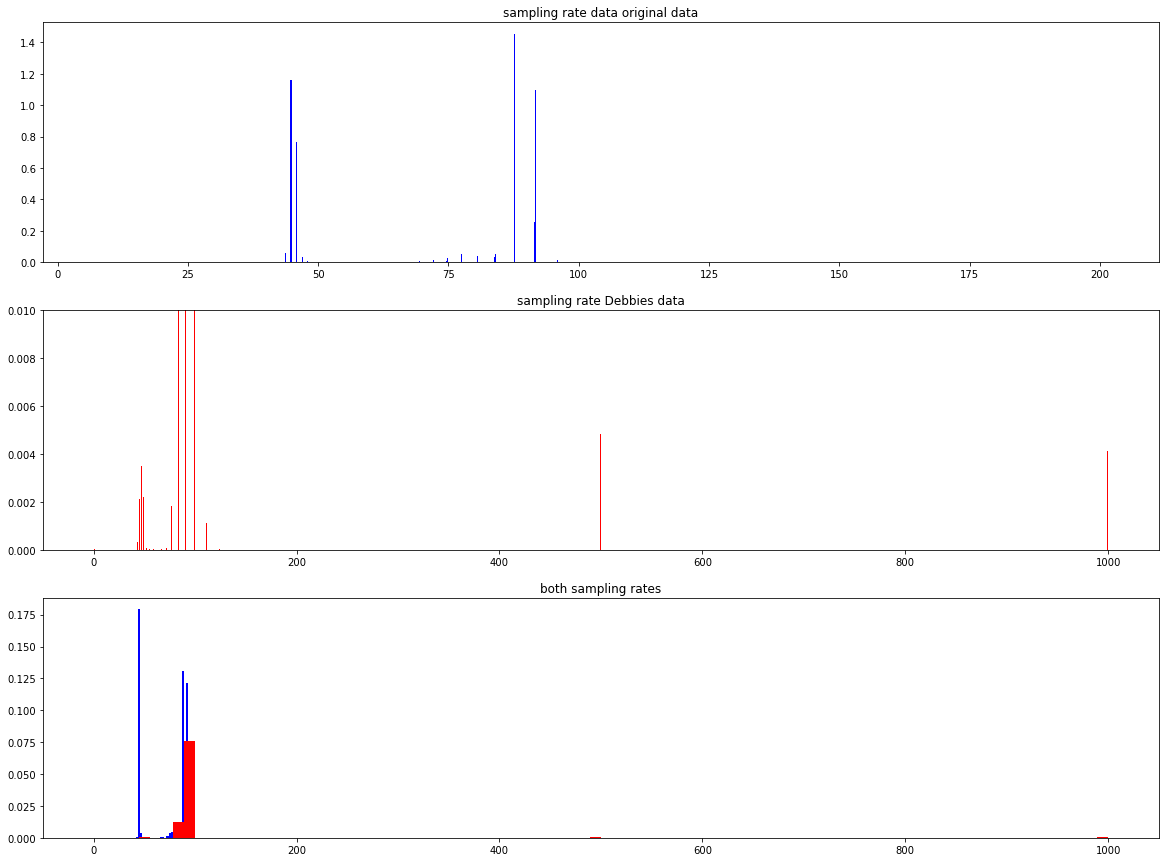

In [265]:
samplingRate1 = data['timeStampDataPointStart'].diff()
samplingRate2 = goodData['time'].diff()

print("---------------------------------")

print("max sampling rate 1 ", 1/np.nanmin(samplingRate1))
print("max sampling rate 2 ", 1/np.nanmin(samplingRate2))
print("---------------------------------")

print("mean sampling rate 1 ", 1/np.nanmean(samplingRate1))
print("mean sampling rate 2 ", 1/np.nanmean(samplingRate2))
print("---------------------------------")

print("median sampling rate 1 ", 1/np.nanmedian(samplingRate1))
print("median sampling rate 2 ", 1/np.nanmedian(samplingRate2))

print("---------------------------------")



fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))

axes[0].hist(1/samplingRate1, color='blue', bins = 1000, density = True)
axes[0].set_title('sampling rate data original data')


axes[1].hist(1/samplingRate2, color= 'red', bins = 1000, density = True)

axes[1].set_title('sampling rate Debbies data')
axes[1].set_ylim(0, 0.01)

axes[2].hist(1/samplingRate1, color='blue', bins = 90, density = True)
axes[2].hist(1/samplingRate2, color= 'red', bins = 90, density = True)

axes[2].set_title('both sampling rates')

MemoryError: Unable to allocate 106. TiB for an array with shape (14501269310888,) and data type float64

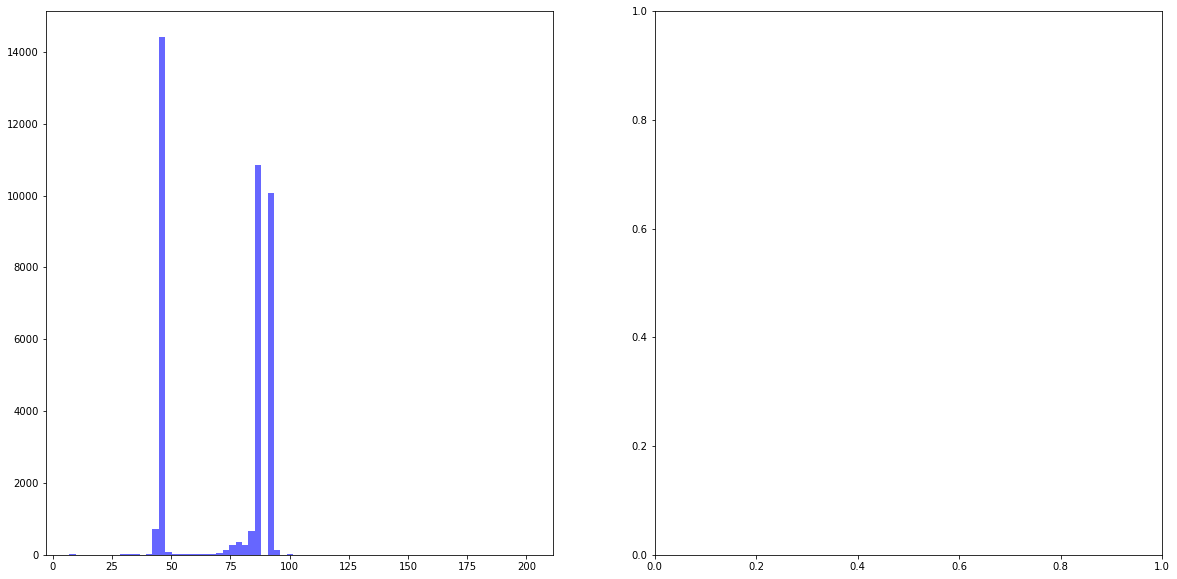

In [277]:
# Create a single subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot histograms and density plots for both datasets on the same axis
axs[0].hist(1/samplingRate1, bins='auto', color='blue',  alpha=0.6)
axs[1].hist(1/samplingRate2, bins='auto', color='red',  alpha=0.6)
# # Set titles and labels
# ax[0].set_title('Density Plot of Sampling Rates')
# ax[0].set_xlabel('Sampling Rate (ms)')
# ax[0].set_ylabel('Density')
# ax[0].legend()

# Show plot
plt.tight_layout()
plt.show()

In [140]:
file= "1008_Session_1_ET_1_data_processed_gazes.csv"
data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))

In [136]:

pd.set_option('display.max_columns', None)

# # Assuming 'data' is your DataFrame
data_head = data.head(55)

# Display head horizontally
with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
    display(data.iloc[100:170])



,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,goodData,long_events
0,0.000000,0.00000,1.620048e+09,1.620048e+09,1.620048e+09,0.890653,0.983545,4.963711,4.486682,31.0,31.0,3.0,-59.009783,2.406623,34.677778,0.253288,-0.141500,0.955491,-0.051065,-0.123540,0.989582,-58.952024,2.407876,34.681662,0.268104,-0.137186,0.952069,-0.035721,-0.119908,0.990699,-59.014553,2.406419,34.677969,0.248464,-0.143172,0.956533,-0.056050,-0.124992,0.989154,-58.981634,2.401428,34.712397,0.299869,-0.015910,0.952444,0.951782,0.045788,-0.298895,0.911639,17.452760,2.624739,-0.038907,0.997484,0.028913,-59.020839,0.857525,34.743407,-58

In [141]:
data_old = data.copy()

In [180]:
time = data["timeStampRS"].tolist()

# get individual coordinates
# position
Xcorr_position = data["eyePositionCombinedWorld_x"].tolist()
Ycorr_position = data["eyePositionCombinedWorld_y"].tolist()
Zcorr_position = data["eyePositionCombinedWorld_z"].tolist()
subj = list(zip(Xcorr_position, Ycorr_position, Zcorr_position))

# hpoo
hpooX = data["processedCollider_hitPointOnObject_x"].tolist()
hpooY = data["processedCollider_hitPointOnObject_y"].tolist()
hpooZ = data["processedCollider_hitPointOnObject_z"].tolist()

hpoo = list(zip(hpooX, hpooY, hpooZ))

# v_gaze_vec: get difference in hpoo
v_vX = pd.DataFrame(hpooX).apply(lambda x: x.diff())[0].tolist()
v_vY = pd.DataFrame(hpooY).apply(lambda x: x.diff())[0].tolist()
v_vZ = pd.DataFrame(hpooZ).apply(lambda x: x.diff())[0].tolist()

# get difference in time:
ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()

v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]
# display(np.linalg.norm(gaze_vec[1]))

# v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
# v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||:
# z1 = (<v_gaze_vec(t), gaze_vec(t)>)
z1 = [
    np.array(v_gaze_vec[t]).dot(np.array(gaze_vec[t]))
    for t in range(len(v_vX))
]

# z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
z = [z1[t] * np.array(gaze_vec[t]) for t in range(len(v_vX))]

# ||v_gaze_vec(t) - z||
v_gaze_inplane = [
    np.linalg.norm((np.array(v_gaze_vec[t]) - z[t]).tolist())
    for t in range(len(v_gaze_vec))
]
# w_gaze(t) = arctan2(||subject_vec(t) - hpoo_vec(t)||, v_gaze_inplane)

# sub_hpoo = ||subject_vec(t) - hpoo_vec(t)||
sub_hpoo = [
    np.linalg.norm(np.array(subj[t]) - np.array(hpoo[t]))
    for t in range(len(hpoo))
]

# arctan2(v_gaze_inplane, sub_hpoo)
w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()

# turn angle of radians into degrees
w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
# w_gaze = [(w*180/math.pi) for idx,w in enumerate(w_gaze)]

# add 0 to first sample, since NaN will throw an error in the Savitzky-Golay filter
w_gaze[0]=0

# save df --> to facilitate runtime, save data only in last processing function
data["combined_vel3"] = w_gaze

In [195]:
data.iloc[210:240]

,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH
210,2.333333,2.33219,1.620048e+09,1.620048e+09,1.620048e+09,0.994674,0.994558,4.216385,3.963233,31.0,31.0,3.0,-59.043156,2.419906,34.718983,0.279226,0.235931,0.931067,-0.065214,0.157181,0.985655,-59.040675,2.419856,34.719117,0.279897,0.236308,0.930770,-0.064468,0.157533,0.985648,-59.103033,2.418822,34.714891,0.264598,0.228341,0.937212,-0.081333,0.150143,0.985560,-59.070865,2.414201,34.749512,0.355082,0.082916,0.931347,0.932916,0.035555,-0.358845,355.309965,20.873470,2.044597,-0.062856,0.996106,-0.064717,-59.110854,0.858833,34.796396,-58.956406,1.916139,34.969

In [144]:
data_old.head(10)

,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,goodData,long_events
0,0.000000,0.00000,1.620048e+09,1.620048e+09,1.620048e+09,0.890653,0.983545,4.963711,4.486682,31.0,31.0,3.0,-59.009783,2.406623,34.677778,0.253288,-0.141500,0.955491,-0.051065,-0.123540,0.989582,-58.952024,2.407876,34.681662,0.268104,-0.137186,0.952069,-0.035721,-0.119908,0.990699,-59.014553,2.406419,34.677969,0.248464,-0.143172,0.956533,-0.056050,-0.124992,0.989154,-58.981634,2.401428,34.712397,0.299869,-0.015910,0.952444,0.951782,0.045788,-0.298895,0.911639,17.452760,2.624739,-0.038907,0.997484,0.028913,-59.020839,0.857525,34.743407,-58

In [145]:
nan_indexes = data[data['eyeOpennessLeft'].isna()].index.tolist()

In [146]:
print(nan_indexes[:50])

[]


In [198]:
data.columns[110:120]

Index(['processedCollider_NH_hitPointOnObject_x',
       'processedCollider_NH_hitPointOnObject_y',
       'processedCollider_NH_hitPointOnObject_z',
       'processedCollider_NH_hitObjectColliderBoundsCenter_x',
       'processedCollider_NH_hitObjectColliderBoundsCenter_y',
       'processedCollider_NH_hitObjectColliderBoundsCenter_z',
       'replacedRows_NH', 'processedCollider_NH_IsNH', 'cleanData', 'isBlink'],
      dtype='object')

In [201]:
data['processedCollider_NH_IsNH'].head(50)

0     0.0
1     NaN
2     0.0
3     NaN
4     0.0
5     0.0
6     NaN
7     0.0
8     NaN
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    NaN
15    0.0
16    NaN
17    0.0
18    NaN
19    0.0
20    NaN
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    NaN
27    0.0
28    0.0
29    NaN
30    0.0
31    NaN
32    0.0
33    NaN
34    0.0
35    NaN
36    0.0
37    0.0
38    NaN
39    0.0
40    0.0
41    0.0
42    1.0
43    1.0
44    NaN
45    0.0
46    NaN
47    NaN
48    NaN
49    NaN
Name: processedCollider_NH_IsNH, dtype: float64